# P7 SCORING: Exploratory data analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from fonctions_eda import *
import bokeh
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import HoverTool, LinearAxis, Range1d, ColumnDataSource, Span
from bokeh.models.annotations import Label
from bokeh.layouts import row, column
from bokeh.palettes import Spectral3, Spectral4, Spectral5, Spectral6, Spectral7, \
                            Spectral8, Spectral9, Spectral10, Spectral11, viridis
from bokeh.transform import factor_cmap
from bokeh.io import show
bokeh.io.reset_output()
bokeh.io.output_notebook()
from contextlib import contextmanager
import pickle
import time
import gc
import os
import sys
#import warnings
#warnings.simplefilter(action='ignore', category=FutureWarning)

Loading BokehJS ...

This project was made with Python 3.8.8, Matplotlib 3.4.2, Pandas 1.2.4, Numpy 1.20.1, Seaborn 0.11.1., Bokeh 2.4.1. Chek your version number:

In [2]:
print("Python", sys.version_info.major, ".", sys.version_info.minor)
print("Matplotlib", mpl.__version__)
print("Pandas", pd.__version__)
print("Nympy", np.__version__)
print("Seaborn", sns.__version__)
print("Bokeh", bokeh.__version__)

Python 3 . 8
Matplotlib 3.4.2
Pandas 1.2.4
Nympy 1.20.1
Seaborn 0.11.1
Bokeh 2.4.1


The EDA of this notebook is built from several kaggle kernels, modified and re-arranged for this project :
* https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction/notebook
* https://www.kaggle.com/gpreda/home-credit-default-risk-extensive-eda
* https://www.kaggle.com/codename007/home-credit-complete-eda-feature-importance

Feature engineering is partly taken from (laso re-arranged):
* https://www.kaggle.com/jsaguiar/lightgbm-with-simple-features/script

NaN/correlations cleaning and PCA is my own work. Modeling, API, dashbord and deployment are also entirely personal work.

In [3]:
# For a better visualisation:
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 400)
pd.set_option('display.float_format', '{:.4f}'.format)
plt.rcParams.update({"figure.titlesize":16, "axes.titlesize":15, "axes.labelsize":14, "xtick.labelsize":14, 
    "ytick.labelsize":14})

## 1. Load dataset

Add the path to the file containing the .csv of the project.

In [4]:
path_to_csv = "data/"

In [5]:
path_app_train = os.path.join(path_to_csv, "application_train.csv")
path_app_test = os.path.join(path_to_csv, "application_test.csv")
path_bureau = os.path.join(path_to_csv, "bureau.csv")
path_bureau_bal = os.path.join(path_to_csv, "bureau_balance.csv")
path_credit_card = os.path.join(path_to_csv, "credit_card_balance.csv")
path_description = os.path.join(path_to_csv, "HomeCredit_columns_description.csv")
path_installements= os.path.join(path_to_csv, "installments_payments.csv")
path_pos_cash = os.path.join(path_to_csv, "POS_CASH_balance.csv")
path_previous_app = os.path.join(path_to_csv, "previous_application.csv")
path_confusion_cost = os.path.join(path_to_csv, "confusion_costs.png")

In [6]:
app_train = pd.read_csv(path_app_train, encoding="utf-8")
app_test = pd.read_csv(path_app_test, encoding="utf-8")
bureau = pd.read_csv(path_bureau, encoding="utf-8")
bureau_bal = pd.read_csv(path_bureau_bal, encoding="utf-8")
credit_card = pd.read_csv(path_credit_card, encoding="utf-8")
descriptions = pd.read_csv(path_description)
installments = pd.read_csv(path_installements, encoding="utf-8")
pos_cash = pd.read_csv(path_pos_cash, encoding="utf-8")
previous_app = pd.read_csv(path_previous_app, encoding="utf-8")

## 2. Basic info & overview

The data is provided by [Home Credit](http://www.homecredit.net/about-us.aspx), a service dedicated to provided lines of credit (loans) to the unbanked population. Predicting whether or not a client will repay a loan or have difficulty is a critical business need, and Home Credit is hosting this competition on Kaggle to see what sort of models the machine learning community can develop to help them in this task. 

There are 7 different sources of data:

* application_train/application_test: the main training and testing data with information about each loan application at Home Credit. Every loan has its own row and is identified by the feature `SK_ID_CURR`. The training application data comes with the `TARGET` indicating 0: the loan was repaid or 1: the loan was not repaid. 
* bureau: data concerning client's previous credits from other financial institutions. Each previous credit has its own row in bureau, but one loan in the application data can have multiple previous credits.
* bureau_balance: monthly data about the previous credits in bureau. Each row is one month of a previous credit, and a single previous credit can have multiple rows, one for each month of the credit length. 
* previous_application: previous applications for loans at Home Credit of clients who have loans in the application data. Each current loan in the application data can have multiple previous loans. Each previous application has one row and is identified by the feature `SK_ID_PREV`. 
* POS_CASH_BALANCE: monthly data about previous point of sale or cash loans clients have had with Home Credit. Each row is one month of a previous point of sale or cash loan, and a single previous loan can have many rows.
* credit_card_balance: monthly data about previous credit cards clients have had with Home Credit. Each row is one month of a credit card balance, and a single credit card can have many rows.
* installments_payment: payment history for previous loans at Home Credit. There is one row for every made payment and one row for every missed payment. 

This diagram shows how all of the data is related:

![image](https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png)

In [7]:
df_list = [app_test, app_train, bureau, bureau_bal, credit_card, installments, pos_cash, previous_app]
df_names_list = ["Application test", "Application train", "Bureau", "Bureau balance", "Credit card balance",
     "Installements payments", "POS CASH balance", "Previous application"]
subsets_list = ["SK_ID_CURR", "SK_ID_CURR", "SK_ID_CURR", "SK_ID_BUREAU", "SK_ID_PREV", "SK_ID_PREV", 
    "SK_ID_PREV", "SK_ID_CURR"]

In [8]:
info_data_multi(df_list, df_names_list, subsets_list)

nb lines  nb columns       size  nb duplicates  \
Application test           48744         121    5898024              0   
Application train         307511         122   37516342              0   
Bureau                   1716428          17   29179276        1410617   
Bureau balance          27299925           3   81899775       26482530   
Credit card balance      3840312          23   88327176        3736005   
Installements payments  13605401           8  108843208       12607649   
POS CASH balance        10001358           8   80010864        9065033   
Previous application     1670214          37   61797918        1331357   

                       subsets for duplicates  
Application test                   SK_ID_CURR  
Application train                  SK_ID_CURR  
Bureau                             SK_ID_CURR  
Bureau balance                   SK_ID_BUREAU  
Credit card balance                SK_ID_PREV  
Installements payments             SK_ID_PREV  
POS CASH balance                   SK_ID_PREV  
Previous application               SK_ID_CURR

### 2.1. Descriptions

In [9]:
descriptions.head()

Unnamed: 0                         Table                 Row  \
0           1  application_{train|test}.csv          SK_ID_CURR   
1           2  application_{train|test}.csv              TARGET   
2           5  application_{train|test}.csv  NAME_CONTRACT_TYPE   
3           6  application_{train|test}.csv         CODE_GENDER   
4           7  application_{train|test}.csv        FLAG_OWN_CAR   

                                         Description Special  
0                           ID of loan in our sample     NaN  
1  Target variable (1 - client with payment diffi...     NaN  
2        Identification if loan is cash or revolving     NaN  
3                               Gender of the client     NaN  
4                      Flag if the client owns a car     NaN

### 2.2. Application train and test

In [10]:
app_train.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL   AMT_CREDIT  AMT_ANNUITY  \
0               Y             0       202500.0000  406597.5000   24700.5000   
1               N             0       270000.0000 1293502.5000   35698.5000   
2               Y             0        67500.0000  135000.0000    6750.0000   
3               Y             0       135000.0000  312682.5000   29686.5000   
4               Y             0       121500.0000  513000.0000   21865.5000   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0      351000.0000   Unaccompanied          Working   
1     1129500.0000          Family    State servant   
2      135000.0000   Unaccompanied          Working   
3      297000.0000   Unaccompanied          Working   
4      513000.0000   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                      0.0188       -9461           -637         -3648.0000   
1                      0.0035      -16765          -1188         -1186.0000   
2                      0.0100      -19046           -225         -4260.0000   
3                      0.0080      -19005          -3039         -9833.0000   
4                      0.0287      -19932          -3038         -4311.0000   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531      26.0000           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers           1.0000   
1                 1           1           0      Core staff           2.0000   
2                 1           1           0        Laborers           1.0000   
3                 1           0           0        Laborers           2.0000   
4                 1           0           0      Core staff           1.0000   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                  

In [11]:
app_test.head()

SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100001         Cash loans           F            N               Y   
1      100005         Cash loans           M            N               Y   
2      100013         Cash loans           M            Y               Y   
3      100028         Cash loans           F            N               Y   
4      100038         Cash loans           M            Y               N   

   CNT_CHILDREN  AMT_INCOME_TOTAL   AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0       135000.0000  568800.0000   20560.5000      450000.0000   
1             0        99000.0000  222768.0000   17370.0000      180000.0000   
2             0       202500.0000  663264.0000   69777.0000      630000.0000   
3             2       315000.0000 1575000.0000   49018.5000     1575000.0000   
4             1       180000.0000  625500.0000   32067.0000      625500.0000   

  NAME_TYPE_SUITE NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0   Unaccompanied          Working               Higher education   
1   Unaccompanied          Working  Secondary / secondary special   
2             NaN          Working               Higher education   
3   Unaccompanied          Working  Secondary / secondary special   
4   Unaccompanied          Working  Secondary / secondary special   

  NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  \
0            Married  House / apartment                      0.0188   
1            Married  House / apartment                      0.0358   
2            Married  House / apartment                      0.0191   
3            Married  House / apartment                      0.0264   
4            Married  House / apartment                      0.0100   

   DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
0      -19241          -2329         -5170.0000             -812          NaN   
1      -18064          -4469         -9118.0000            -1623          NaN   
2      -20038          -4458         -2175.0000            -3503       5.0000   
3      -13976          -1866         -2000.0000            -4208          NaN   
4      -13040          -2191         -4000.0000            -4262      16.0000   

   FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
0           1               1                0                 1           0   
1           1               1                0                 1           0   
2           1               1                0                 1           0   
3           1               1                0                 1           1   
4           1               1                1                 1           0   

   FLAG_EMAIL     OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
0           1                 NaN           2.0000                     2   
1           0  Low-skill Laborers           2.0000                     2   
2           0             Drivers           2.0000                     2   
3           0         Sales staff           4.0000                     2   
4           0                 NaN           3.0000                     2   

   REGION_RATING_CLIENT_W_CITY WEEKDAY_APPR_PROCESS_START  \
0                            2                    TUESDAY   
1                            2                     FRIDAY   
2                            2                     MONDAY   
3                            2                  WEDNESDAY   
4                            2                     FRIDAY   

   HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
0                       18                           0   
1                        9                           0   
2                       14                           0   
3                       11                           0   
4                        5                           0   

   REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
0             

In [12]:
app_train.columns.values

array(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
       'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE',
       'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START',
       'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1',
       'EXT_SOURCE_2', 'EXT_SOURCE_3',

In [13]:
app_train["AMT_CREDIT"].median()*2/100

10270.62

In [14]:
nan_col(app_train)

% NaN  % dispo
SK_ID_CURR                    0.0000 100.0000
TARGET                        0.0000 100.0000
NAME_CONTRACT_TYPE            0.0000 100.0000
CODE_GENDER                   0.0000 100.0000
FLAG_OWN_CAR                  0.0000 100.0000
FLAG_OWN_REALTY               0.0000 100.0000
CNT_CHILDREN                  0.0000 100.0000
AMT_INCOME_TOTAL              0.0000 100.0000
AMT_CREDIT                    0.0000 100.0000
AMT_ANNUITY                   0.0039  99.9961
AMT_GOODS_PRICE               0.0904  99.9096
NAME_TYPE_SUITE               0.4201  99.5799
NAME_INCOME_TYPE              0.0000 100.0000
NAME_EDUCATION_TYPE           0.0000 100.0000
NAME_FAMILY_STATUS            0.0000 100.0000
NAME_HOUSING_TYPE             0.0000 100.0000
REGION_POPULATION_RELATIVE    0.0000 100.0000
DAYS_BIRTH                    0.0000 100.0000
DAYS_EMPLOYED                 0.0000 100.0000
DAYS_REGISTRATION             0.0000 100.0000
DAYS_ID_PUBLISH               0.0000 100.0000
OWN_CAR_AGE                  65.9908  34.0092
FLAG_MOBIL                    0.0000 100.0000
FLAG_EMP_PHONE                0.0000 100.0000
FLAG_WORK_PHONE               0.0000 100.0000
FLAG_CONT_MOBILE              0.0000 100.0000
FLAG_PHONE                    0.0000 100.0000
FLAG_EMAIL                    0.0000 100.0000
OCCUPATION_TYPE              31.3455  68.6545
CNT_FAM_MEMBERS               0.0007  99.9993
REGION_RATING_CLIENT          0.0000 100.0000
REGION_RATING_CLIENT_W_CITY   0.0000 100.0000
WEEKDAY_APPR_PROCESS_START    0.0000 100.0000
HOUR_APPR_PROCESS_START       0.0000 100.0000
REG_REGION_NOT_LIVE_REGION    0.0000 100.0000
REG_REGION_NOT_WORK_REGION    0.0000 100.0000
LIVE_REGION_NOT_WORK_REGION   0.0000 100.0000
REG_CITY_NOT_LIVE_CITY        0.0000 100.0000
REG_CITY_NOT_WORK_CITY        0.0000 100.0000
LIVE_CITY_NOT_WORK_CITY       0.0000 100.0000
ORGANIZATION_TYPE             0.0000 100.0000
EXT_SOURCE_1                 56.3811  43.6189
EXT_SOURCE_2                  0.2146  99.7854
EXT_SOURCE_3                 19.8253  80.1747
APARTMENTS_AVG               50.7497  49.2503
BASEMENTAREA_AVG             58.5160  41.4840
YEARS_BEGINEXPLUATATION_AVG  48.7810  51.2190
YEARS_BUILD_AVG              66.4978  33.5022
COMMONAREA_AVG               69.8723  30.1277
ELEVATORS_AVG                53.2960  46.7040
ENTRANCES_AVG                50.3488  49.6512
FLOORSMAX_AVG                49.7608  50.2392
FLOORSMIN_AVG                67.8486  32.1514
LANDAREA_AVG                 59.3767  40.6233
LIVINGAPARTMENTS_AVG         68.3550  31.6450
LIVINGAREA_AVG               50.1933  49.8067
NONLIVINGAPARTMENTS_AVG      69.4330  30.5670
NONLIVINGAREA_AVG            55.1792  44.8208
APARTMENTS_MODE              50.7497  49.2503
BASEMENTAREA_MODE            58.5160  41.4840
YEARS_BEGINEXPLUATATION_MODE 48.7810  51.2190
YEARS_BUILD_MODE             66.4978  33.5022
COMMONAREA_MODE              69.8723  30.1277
ELEVATORS_MODE               53.2960  46.7040
ENTRANCES_MODE               50.3488  49.6512
FLOORSMAX_MODE               49.7608  50.2392
FLOORSMIN_MODE               67.8486  32.1514
LANDAREA_MODE                59.3767  40.6233
LIVINGAPARTMENTS_MODE        68.3550  31.6450
LIVINGAREA_MODE              50.1933  49.8067
NONLIVINGAPARTMENTS_MODE     69.4330  30.5670
NONLIVINGAREA_MODE           55.1792  44.8208
APARTMENTS_MEDI              50.7497  49.2503
BASEMENTAREA_MEDI            58.5160  41.4840
YEARS_BEGINEXPLUATATION_MEDI 48.7810  51.2190
YEARS_BUILD_MEDI             66.4978  33.5022
COMMONAREA_MEDI              69.8723  30.1277
ELEVATORS_MEDI               53.2960  46.7040
ENTRANCES_MEDI               50.3488  49.6512
FLOORSMAX_MEDI               49.7608  50.2392
FLOORSMIN_MEDI               67.8486  32.1514
LANDAREA_MEDI                59.3767  40.6233
LIVINGAPARTMENTS_MEDI        68.3550  31.6450
LIVINGAREA_MEDI              50.1933  49.8067
NONLIVINGAPARTMENTS_MEDI     69.4330  30.5670
NONLIVINGAREA_MEDI           55.1792  44.8208
FONDKAPREMONT_MODE           

In [15]:
nan_col(app_test)

% NaN  % dispo
SK_ID_CURR                    0.0000 100.0000
NAME_CONTRACT_TYPE            0.0000 100.0000
CODE_GENDER                   0.0000 100.0000
FLAG_OWN_CAR                  0.0000 100.0000
FLAG_OWN_REALTY               0.0000 100.0000
CNT_CHILDREN                  0.0000 100.0000
AMT_INCOME_TOTAL              0.0000 100.0000
AMT_CREDIT                    0.0000 100.0000
AMT_ANNUITY                   0.0492  99.9508
AMT_GOODS_PRICE               0.0000 100.0000
NAME_TYPE_SUITE               1.8689  98.1311
NAME_INCOME_TYPE              0.0000 100.0000
NAME_EDUCATION_TYPE           0.0000 100.0000
NAME_FAMILY_STATUS            0.0000 100.0000
NAME_HOUSING_TYPE             0.0000 100.0000
REGION_POPULATION_RELATIVE    0.0000 100.0000
DAYS_BIRTH                    0.0000 100.0000
DAYS_EMPLOYED                 0.0000 100.0000
DAYS_REGISTRATION             0.0000 100.0000
DAYS_ID_PUBLISH               0.0000 100.0000
OWN_CAR_AGE                  66.2892  33.7108
FLAG_MOBIL                    0.0000 100.0000
FLAG_EMP_PHONE                0.0000 100.0000
FLAG_WORK_PHONE               0.0000 100.0000
FLAG_CONT_MOBILE              0.0000 100.0000
FLAG_PHONE                    0.0000 100.0000
FLAG_EMAIL                    0.0000 100.0000
OCCUPATION_TYPE              32.0142  67.9858
CNT_FAM_MEMBERS               0.0000 100.0000
REGION_RATING_CLIENT          0.0000 100.0000
REGION_RATING_CLIENT_W_CITY   0.0000 100.0000
WEEKDAY_APPR_PROCESS_START    0.0000 100.0000
HOUR_APPR_PROCESS_START       0.0000 100.0000
REG_REGION_NOT_LIVE_REGION    0.0000 100.0000
REG_REGION_NOT_WORK_REGION    0.0000 100.0000
LIVE_REGION_NOT_WORK_REGION   0.0000 100.0000
REG_CITY_NOT_LIVE_CITY        0.0000 100.0000
REG_CITY_NOT_WORK_CITY        0.0000 100.0000
LIVE_CITY_NOT_WORK_CITY       0.0000 100.0000
ORGANIZATION_TYPE             0.0000 100.0000
EXT_SOURCE_1                 42.1221  57.8779
EXT_SOURCE_2                  0.0164  99.9836
EXT_SOURCE_3                 17.7827  82.2173
APARTMENTS_AVG               49.0050  50.9950
BASEMENTAREA_AVG             56.7065  43.2935
YEARS_BEGINEXPLUATATION_AVG  46.8899  53.1101
YEARS_BUILD_AVG              65.2757  34.7243
COMMONAREA_AVG               68.7161  31.2839
ELEVATORS_AVG                51.6761  48.3239
ENTRANCES_AVG                48.3731  51.6269
FLOORSMAX_AVG                47.8438  52.1562
FLOORSMIN_AVG                66.6051  33.3949
LANDAREA_AVG                 57.9641  42.0359
LIVINGAPARTMENTS_AVG         67.2493  32.7507
LIVINGAREA_AVG               48.3177  51.6823
NONLIVINGAPARTMENTS_AVG      68.4125  31.5875
NONLIVINGAREA_AVG            53.5122  46.4878
APARTMENTS_MODE              49.0050  50.9950
BASEMENTAREA_MODE            56.7065  43.2935
YEARS_BEGINEXPLUATATION_MODE 46.8899  53.1101
YEARS_BUILD_MODE             65.2757  34.7243
COMMONAREA_MODE              68.7161  31.2839
ELEVATORS_MODE               51.6761  48.3239
ENTRANCES_MODE               48.3731  51.6269
FLOORSMAX_MODE               47.8438  52.1562
FLOORSMIN_MODE               66.6051  33.3949
LANDAREA_MODE                57.9641  42.0359
LIVINGAPARTMENTS_MODE        67.2493  32.7507
LIVINGAREA_MODE              48.3177  51.6823
NONLIVINGAPARTMENTS_MODE     68.4125  31.5875
NONLIVINGAREA_MODE           53.5122  46.4878
APARTMENTS_MEDI              49.0050  50.9950
BASEMENTAREA_MEDI            56.7065  43.2935
YEARS_BEGINEXPLUATATION_MEDI 46.8899  53.1101
YEARS_BUILD_MEDI             65.2757  34.7243
COMMONAREA_MEDI              68.7161  31.2839
ELEVATORS_MEDI               51.6761  48.3239
ENTRANCES_MEDI               48.3731  51.6269
FLOORSMAX_MEDI               47.8438  52.1562
FLOORSMIN_MEDI               66.6051  33.3949
LANDAREA_MEDI                57.9641  42.0359
LIVINGAPARTMENTS_MEDI        67.2493  32.7507
LIVINGAREA_MEDI              48.3177  51.6823
NONLIVINGAPARTMENTS_MEDI     68.4125  31.5875
NONLIVINGAREA_MEDI           53.5122  46.4878
FONDKAPREMONT_MODE           67.2842  32.7158
HOUSETYPE_MODE               

### 2.3. Bureau

In [16]:
bureau.head()

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   
3      215354       5714465        Active      currency 1         -203   
4      215354       5714466        Active      currency 1         -629   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0            -153.0000          -153.0000   
1                   0            1075.0000                NaN   
2                   0             528.0000                NaN   
3                   0                  NaN                NaN   
4                   0            1197.0000                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0      91323.0000   
1                     NaN                   0     225000.0000   
2                     NaN                   0     464323.5000   
3                     NaN                   0      90000.0000   
4              77674.5000                   0    2700000.0000   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0               0.0000                   NaN                  0.0000   
1          171342.0000                   NaN                  0.0000   
2                  NaN                   NaN                  0.0000   
3                  NaN                   NaN                  0.0000   
4                  NaN                   NaN                  0.0000   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0  Consumer credit                -131          NaN  
1      Credit card                 -20          NaN  
2  Consumer credit                 -16          NaN  
3      Credit card                 -16          NaN  
4  Consumer credit                 -21          NaN

In [17]:
bureau.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB


In [18]:
nan_col(bureau)

% NaN  % dispo
SK_ID_CURR              0.0000 100.0000
SK_ID_BUREAU            0.0000 100.0000
CREDIT_ACTIVE           0.0000 100.0000
CREDIT_CURRENCY         0.0000 100.0000
DAYS_CREDIT             0.0000 100.0000
CREDIT_DAY_OVERDUE      0.0000 100.0000
DAYS_CREDIT_ENDDATE     6.1496  93.8504
DAYS_ENDDATE_FACT      36.9170  63.0830
AMT_CREDIT_MAX_OVERDUE 65.5133  34.4867
CNT_CREDIT_PROLONG      0.0000 100.0000
AMT_CREDIT_SUM          0.0008  99.9992
AMT_CREDIT_SUM_DEBT    15.0119  84.9881
AMT_CREDIT_SUM_LIMIT   34.4774  65.5226
AMT_CREDIT_SUM_OVERDUE  0.0000 100.0000
CREDIT_TYPE             0.0000 100.0000
DAYS_CREDIT_UPDATE      0.0000 100.0000
AMT_ANNUITY            71.4735  28.5265

### 2.4. Bureau balance

In [19]:
bureau_bal.head()

SK_ID_BUREAU  MONTHS_BALANCE STATUS
0       5715448               0      C
1       5715448              -1      C
2       5715448              -2      C
3       5715448              -3      C
4       5715448              -4      C

In [20]:
bureau_bal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   SK_ID_BUREAU    int64 
 1   MONTHS_BALANCE  int64 
 2   STATUS          object
dtypes: int64(2), object(1)
memory usage: 624.8+ MB


In [21]:
nan_col(bureau_bal)

% NaN  % dispo
SK_ID_BUREAU   0.0000 100.0000
MONTHS_BALANCE 0.0000 100.0000
STATUS         0.0000 100.0000

### 2.5. POS CASH balance

In [22]:
pos_cash.head()

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
0     1803195      182943             -31         48.0000   
1     1715348      367990             -33         36.0000   
2     1784872      397406             -32         12.0000   
3     1903291      269225             -35         48.0000   
4     2341044      334279             -35         36.0000   

   CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                45.0000               Active       0           0  
1                35.0000               Active       0           0  
2                 9.0000               Active       0           0  
3                42.0000               Active       0           0  
4                35.0000               Active       0           0

In [23]:
pos_cash.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SK_ID_PREV             int64  
 1   SK_ID_CURR             int64  
 2   MONTHS_BALANCE         int64  
 3   CNT_INSTALMENT         float64
 4   CNT_INSTALMENT_FUTURE  float64
 5   NAME_CONTRACT_STATUS   object 
 6   SK_DPD                 int64  
 7   SK_DPD_DEF             int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 610.4+ MB


In [24]:
nan_col(pos_cash)

% NaN  % dispo
SK_ID_PREV            0.0000 100.0000
SK_ID_CURR            0.0000 100.0000
MONTHS_BALANCE        0.0000 100.0000
CNT_INSTALMENT        0.2607  99.7393
CNT_INSTALMENT_FUTURE 0.2608  99.7392
NAME_CONTRACT_STATUS  0.0000 100.0000
SK_DPD                0.0000 100.0000
SK_DPD_DEF            0.0000 100.0000

### 2.6. Previous application

In [25]:
previous_app.head()

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans    1730.4300       17145.0000   
1     2802425      108129         Cash loans   25188.6150      607500.0000   
2     2523466      122040         Cash loans   15060.7350      112500.0000   
3     2819243      176158         Cash loans   47041.3350      450000.0000   
4     1784265      202054         Cash loans   31924.3950      337500.0000   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0  17145.0000            0.0000       17145.0000                   SATURDAY   
1 679671.0000               NaN      607500.0000                   THURSDAY   
2 136444.5000               NaN      112500.0000                    TUESDAY   
3 470790.0000               NaN      450000.0000                     MONDAY   
4 404055.0000               NaN      337500.0000                   THURSDAY   

   HOUR_APPR_PROCESS_START FLAG_LAST_APPL_PER_CONTRACT  \
0                       15                           Y   
1                       11                           Y   
2                       11                           Y   
3                        7                           Y   
4                        9                           Y   

   NFLAG_LAST_APPL_IN_DAY  RATE_DOWN_PAYMENT  RATE_INTEREST_PRIMARY  \
0                       1             0.0000                 0.1828   
1                       1                NaN                    NaN   
2                       1                NaN                    NaN   
3                       1                NaN                    NaN   
4                       1                NaN                    NaN   

   RATE_INTEREST_PRIVILEGED NAME_CASH_LOAN_PURPOSE NAME_CONTRACT_STATUS  \
0                    0.8673                    XAP             Approved   
1                       NaN                    XNA             Approved   
2                       NaN                    XNA             Approved   
3                       NaN                    XNA             Approved   
4                       NaN                Repairs              Refused   

   DAYS_DECISION      NAME_PAYMENT_TYPE CODE_REJECT_REASON  NAME_TYPE_SUITE  \
0            -73  Cash through the bank                XAP              NaN   
1           -164                    XNA                XAP    Unaccompanied   
2           -301  Cash through the bank                XAP  Spouse, partner   
3           -512  Cash through the bank                XAP              NaN   
4           -781  Cash through the bank                 HC              NaN   

  NAME_CLIENT_TYPE NAME_GOODS_CATEGORY NAME_PORTFOLIO NAME_PRODUCT_TYPE  \
0         Repeater              Mobile            POS               XNA   
1         Repeater                 XNA           Cash            x-sell   
2         Repeater                 XNA           Cash            x-sell   
3         Repeater                 XNA           Cash            x-sell   
4         Repeater                 XNA           Cash           walk-in   

              CHANNEL_TYPE  SELLERPLACE_AREA NAME_SELLER_INDUSTRY  \
0             Country-wide                35         Connectivity   
1           Contact center                -1                  XNA   
2  Credit and cash offices                -1                  XNA   
3  Credit and cash offices                -1                  XNA   
4  Credit and cash offices                -1                  XNA   

   CNT_PAYMENT NAME_YIELD_GROUP       PRODUCT_COMBINATION  DAYS_FIRST_DRAWING  \
0      12.0000           middle  POS mobile with interest         365243.0000   
1      36.0000       low_action          Cash X-Sell: low         365243.0000   
2      12.0000             high         Cash X-Sell: high         365243.0000   
3      12.0000           middle       Cash X-Sell: middle         365243.0000   
4      24.0000             high         Cash Street: high                 NaN   

   D

In [26]:
previous_app.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 12  RATE_DOWN_PAYMENT            774370 non-nu

In [27]:
nan_col(previous_app)

% NaN  % dispo
SK_ID_PREV                   0.0000 100.0000
SK_ID_CURR                   0.0000 100.0000
NAME_CONTRACT_TYPE           0.0000 100.0000
AMT_ANNUITY                 22.2867  77.7133
AMT_APPLICATION              0.0000 100.0000
AMT_CREDIT                   0.0001  99.9999
AMT_DOWN_PAYMENT            53.6365  46.3635
AMT_GOODS_PRICE             23.0818  76.9182
WEEKDAY_APPR_PROCESS_START   0.0000 100.0000
HOUR_APPR_PROCESS_START      0.0000 100.0000
FLAG_LAST_APPL_PER_CONTRACT  0.0000 100.0000
NFLAG_LAST_APPL_IN_DAY       0.0000 100.0000
RATE_DOWN_PAYMENT           53.6365  46.3635
RATE_INTEREST_PRIMARY       99.6437   0.3563
RATE_INTEREST_PRIVILEGED    99.6437   0.3563
NAME_CASH_LOAN_PURPOSE       0.0000 100.0000
NAME_CONTRACT_STATUS         0.0000 100.0000
DAYS_DECISION                0.0000 100.0000
NAME_PAYMENT_TYPE            0.0000 100.0000
CODE_REJECT_REASON           0.0000 100.0000
NAME_TYPE_SUITE             49.1198  50.8802
NAME_CLIENT_TYPE             0.0000 100.0000
NAME_GOODS_CATEGORY          0.0000 100.0000
NAME_PORTFOLIO               0.0000 100.0000
NAME_PRODUCT_TYPE            0.0000 100.0000
CHANNEL_TYPE                 0.0000 100.0000
SELLERPLACE_AREA             0.0000 100.0000
NAME_SELLER_INDUSTRY         0.0000 100.0000
CNT_PAYMENT                 22.2864  77.7136
NAME_YIELD_GROUP             0.0000 100.0000
PRODUCT_COMBINATION          0.0207  99.9793
DAYS_FIRST_DRAWING          40.2981  59.7019
DAYS_FIRST_DUE              40.2981  59.7019
DAYS_LAST_DUE_1ST_VERSION   40.2981  59.7019
DAYS_LAST_DUE               40.2981  59.7019
DAYS_TERMINATION            40.2981  59.7019
NFLAG_INSURED_ON_APPROVAL   40.2981  59.7019

### 2.7. Installments payments

In [28]:
installments.head()

SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  \
0     1054186      161674                  1.0000                      6   
1     1330831      151639                  0.0000                     34   
2     2085231      193053                  2.0000                      1   
3     2452527      199697                  1.0000                      3   
4     2714724      167756                  1.0000                      2   

   DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  AMT_PAYMENT  
0       -1180.0000          -1187.0000       6948.3600    6948.3600  
1       -2156.0000          -2156.0000       1716.5250    1716.5250  
2         -63.0000            -63.0000      25425.0000   25425.0000  
3       -2418.0000          -2426.0000      24350.1300   24350.1300  
4       -1383.0000          -1366.0000       2165.0400    2160.5850

In [29]:
installments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_PREV              int64  
 1   SK_ID_CURR              int64  
 2   NUM_INSTALMENT_VERSION  float64
 3   NUM_INSTALMENT_NUMBER   int64  
 4   DAYS_INSTALMENT         float64
 5   DAYS_ENTRY_PAYMENT      float64
 6   AMT_INSTALMENT          float64
 7   AMT_PAYMENT             float64
dtypes: float64(5), int64(3)
memory usage: 830.4 MB


In [30]:
nan_col(installments)

% NaN  % dispo
SK_ID_PREV             0.0000 100.0000
SK_ID_CURR             0.0000 100.0000
NUM_INSTALMENT_VERSION 0.0000 100.0000
NUM_INSTALMENT_NUMBER  0.0000 100.0000
DAYS_INSTALMENT        0.0000 100.0000
DAYS_ENTRY_PAYMENT     0.0214  99.9786
AMT_INSTALMENT         0.0000 100.0000
AMT_PAYMENT            0.0214  99.9786

### 2.8. Credit card balance

In [31]:
credit_card.head()

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  AMT_BALANCE  \
0     2562384      378907              -6      56.9700   
1     2582071      363914              -1   63975.5550   
2     1740877      371185              -7   31815.2250   
3     1389973      337855              -4  236572.1100   
4     1891521      126868              -1  453919.4550   

   AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  \
0                   135000                    0.0000              877.5000   
1                    45000                 2250.0000             2250.0000   
2                   450000                    0.0000                0.0000   
3                   225000                 2250.0000             2250.0000   
4                   450000                    0.0000            11547.0000   

   AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  \
0                      0.0000                  877.5000   
1                      0.0000                    0.0000   
2                      0.0000                    0.0000   
3                      0.0000                    0.0000   
4                      0.0000                11547.0000   

   AMT_INST_MIN_REGULARITY  AMT_PAYMENT_CURRENT  AMT_PAYMENT_TOTAL_CURRENT  \
0                1700.3250            1800.0000                  1800.0000   
1                2250.0000            2250.0000                  2250.0000   
2                2250.0000            2250.0000                  2250.0000   
3               11795.7600           11925.0000                 11925.0000   
4               22924.8900           27000.0000                 27000.0000   

   AMT_RECEIVABLE_PRINCIPAL  AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  \
0                    0.0000         0.0000                0.0000   
1                60175.0800     64875.5550            64875.5550   
2                26926.4250     31460.0850            31460.0850   
3               224949.2850    233048.9700           233048.9700   
4               443044.3950    453919.4550           453919.4550   

   CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  CNT_DRAWINGS_OTHER_CURRENT  \
0                    0.0000                     1                      0.0000   
1                    1.0000                     1                      0.0000   
2                    0.0000                     0                      0.0000   
3                    1.0000                     1                      0.0000   
4                    0.0000                     1                      0.0000   

   CNT_DRAWINGS_POS_CURRENT  CNT_INSTALMENT_MATURE_CUM NAME_CONTRACT_STATUS  \
0                    1.0000                    35.0000               Active   
1                    0.0000                    69.0000               Active   
2                    0.0000                    30.0000               Active   
3                    0.0000                    10.0000               Active   
4                    1.0000                   101.0000               Active   

   SK_DPD  SK_DPD_DEF  
0       0           0  
1       0           0  
2       0           0  
3       0           0  
4       0           0

In [32]:
credit_card.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   SK_ID_PREV                  int64  
 1   SK_ID_CURR                  int64  
 2   MONTHS_BALANCE              int64  
 3   AMT_BALANCE                 float64
 4   AMT_CREDIT_LIMIT_ACTUAL     int64  
 5   AMT_DRAWINGS_ATM_CURRENT    float64
 6   AMT_DRAWINGS_CURRENT        float64
 7   AMT_DRAWINGS_OTHER_CURRENT  float64
 8   AMT_DRAWINGS_POS_CURRENT    float64
 9   AMT_INST_MIN_REGULARITY     float64
 10  AMT_PAYMENT_CURRENT         float64
 11  AMT_PAYMENT_TOTAL_CURRENT   float64
 12  AMT_RECEIVABLE_PRINCIPAL    float64
 13  AMT_RECIVABLE               float64
 14  AMT_TOTAL_RECEIVABLE        float64
 15  CNT_DRAWINGS_ATM_CURRENT    float64
 16  CNT_DRAWINGS_CURRENT        int64  
 17  CNT_DRAWINGS_OTHER_CURRENT  float64
 18  CNT_DRAWINGS_POS_CURRENT    float64
 19  CNT_INSTALMENT_MATURE

In [33]:
nan_col(credit_card)

% NaN  % dispo
SK_ID_PREV                  0.0000 100.0000
SK_ID_CURR                  0.0000 100.0000
MONTHS_BALANCE              0.0000 100.0000
AMT_BALANCE                 0.0000 100.0000
AMT_CREDIT_LIMIT_ACTUAL     0.0000 100.0000
AMT_DRAWINGS_ATM_CURRENT   19.5249  80.4751
AMT_DRAWINGS_CURRENT        0.0000 100.0000
AMT_DRAWINGS_OTHER_CURRENT 19.5249  80.4751
AMT_DRAWINGS_POS_CURRENT   19.5249  80.4751
AMT_INST_MIN_REGULARITY     7.9482  92.0518
AMT_PAYMENT_CURRENT        19.9981  80.0019
AMT_PAYMENT_TOTAL_CURRENT   0.0000 100.0000
AMT_RECEIVABLE_PRINCIPAL    0.0000 100.0000
AMT_RECIVABLE               0.0000 100.0000
AMT_TOTAL_RECEIVABLE        0.0000 100.0000
CNT_DRAWINGS_ATM_CURRENT   19.5249  80.4751
CNT_DRAWINGS_CURRENT        0.0000 100.0000
CNT_DRAWINGS_OTHER_CURRENT 19.5249  80.4751
CNT_DRAWINGS_POS_CURRENT   19.5249  80.4751
CNT_INSTALMENT_MATURE_CUM   7.9482  92.0518
NAME_CONTRACT_STATUS        0.0000 100.0000
SK_DPD                      0.0000 100.0000
SK_DPD_DEF                  0.0000 100.0000

### 2.9. Convert days into years

For readability, we will convert the days columns into years (floats).

In [34]:
app_train.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL   AMT_CREDIT  AMT_ANNUITY  \
0               Y             0       202500.0000  406597.5000   24700.5000   
1               N             0       270000.0000 1293502.5000   35698.5000   
2               Y             0        67500.0000  135000.0000    6750.0000   
3               Y             0       135000.0000  312682.5000   29686.5000   
4               Y             0       121500.0000  513000.0000   21865.5000   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0      351000.0000   Unaccompanied          Working   
1     1129500.0000          Family    State servant   
2      135000.0000   Unaccompanied          Working   
3      297000.0000   Unaccompanied          Working   
4      513000.0000   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                      0.0188       -9461           -637         -3648.0000   
1                      0.0035      -16765          -1188         -1186.0000   
2                      0.0100      -19046           -225         -4260.0000   
3                      0.0080      -19005          -3039         -9833.0000   
4                      0.0287      -19932          -3038         -4311.0000   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531      26.0000           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers           1.0000   
1                 1           1           0      Core staff           2.0000   
2                 1           1           0        Laborers           1.0000   
3                 1           0           0        Laborers           2.0000   
4                 1           0           0      Core staff           1.0000   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                  

In [35]:
col_dates = app_train[["DAYS_BIRTH", "DAYS_EMPLOYED", "DAYS_REGISTRATION", "DAYS_ID_PUBLISH"]]

col_dates["DAYS_BIRTH_y"] = col_dates["DAYS_BIRTH"]/365
col_dates["DAYS_EMPLOYED_y"] = col_dates["DAYS_EMPLOYED"]/365
col_dates["DAYS_REGISTRATION_y"] = col_dates["DAYS_REGISTRATION"]/365
col_dates["DAYS_ID_PUBLISH_y"] = col_dates["DAYS_ID_PUBLISH"]/365


<ipython-input-35-f60e774b9aa4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col_dates["DAYS_BIRTH_y"] = col_dates["DAYS_BIRTH"]/365
<ipython-input-35-f60e774b9aa4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col_dates["DAYS_EMPLOYED_y"] = col_dates["DAYS_EMPLOYED"]/365
<ipython-input-35-f60e774b9aa4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

In [36]:
col_dates

DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  \
0            -9461           -637         -3648.0000            -2120   
1           -16765          -1188         -1186.0000             -291   
2           -19046           -225         -4260.0000            -2531   
3           -19005          -3039         -9833.0000            -2437   
4           -19932          -3038         -4311.0000            -3458   
...            ...            ...                ...              ...   
307506       -9327           -236         -8456.0000            -1982   
307507      -20775         365243         -4388.0000            -4090   
307508      -14966          -7921         -6737.0000            -5150   
307509      -11961          -4786         -2562.0000             -931   
307510      -16856          -1262         -5128.0000             -410   

        DAYS_BIRTH_y  DAYS_EMPLOYED_y  DAYS_REGISTRATION_y  DAYS_ID_PUBLISH_y  
0           -25.9205          -1.7452              -9.9945            -5.8082  
1           -45.9315          -3.2548              -3.2493            -0.7973  
2           -52.1808          -0.6164             -11.6712            -6.9342  
3           -52.0685          -8.3260             -26.9397            -6.6767  
4           -54.6082          -8.3233             -11.8110            -9.4740  
...              ...              ...                  ...                ...  
307506      -25.5534          -0.6466             -23.1671            -5.4301  
307507      -56.9178        1000.6658             -12.0219           -11.2055  
307508      -41.0027         -21.7014             -18.4575           -14.1096  
307509      -32.7699         -13.1123              -7.0192            -2.5507  
307510      -46.1808          -3.4575             -14.0493            -1.1233  

[307511 rows x 8 columns]

## 3. Target and categorical features distributions

We will first have a look at our target and categorical features distributions.

In [37]:
def plot_stats(df, feature, label_rotation=False, horizontal_layout=True, return_df=False):
    """
    """
    temp = df[feature].value_counts()
    data = pd.DataFrame({feature: temp.index,'Number of contracts': temp.values})
    data["Percentage of contracts"] = data["Number of contracts"]*100/(data["Number of contracts"].sum())

    # Calculate the percentage of target=1 per category value
    cat_perc = df[[feature, 'TARGET']].groupby([feature],as_index=False).mean()
    cat_perc["TARGET"] = cat_perc["TARGET"]*100
    
    if(horizontal_layout):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,14))

    sns.set_style("darkgrid")

    s = sns.barplot(ax=ax1, x = feature, y="Percentage of contracts", data=data)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(), rotation=90)
    ax1.set_title(f"Percentage of contracts by \n {feature} category")

    s = sns.barplot(ax=ax2, x = feature, y='TARGET', order=cat_perc[feature], data=cat_perc)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    ax2.set_title('Percentage of non-repaid loans for each category (%)')
    ax2.set_ylabel('% of target with value=1')
    ax2.set_xlabel(feature)

    if return_df:
        return cat_perc

In [38]:
# Get number and calculate percentage for each target
data = pd.DataFrame(app_train["TARGET"].value_counts()).reset_index()
data.rename(columns={"TARGET": "count", "index": "TARGET"}, inplace=True)
data["TARGET"] = data["TARGET"].astype(str)
data["perc"] = data["count"]/data["count"].sum()*100
data["color"] = ["steelblue", "coral"]
source=ColumnDataSource(data)

# Keep % of default contracts in a variable for futur use
perc_default = data["perc"][1]

p = figure(title="Application loans (0: repayed, 1: default)\ntrain dataset",
            background_fill_color="#EAEAF2",
            x_range=list(data["TARGET"]),
            height=400,
            width=400)
bars = p.vbar(source=source, x="TARGET", top="count", width=0.8, color="color", hover_line_color="white")
p.left[0].formatter.use_scientific = False
p.yaxis.axis_label = "Count of clients"
p.xaxis.axis_label = "Targets"
p.ygrid.grid_line_color = "white"
p.y_range.start = 0
p.xgrid.grid_line_color = None

p.add_tools(HoverTool(tooltips=[("Count:", "@count"), ("Percentage:", "@perc")], 
                            renderers = [bars]))

show(p)

In [39]:
def plot_stats(df, feature, label_rotation=False, vertical_layout=False, plot_height=400, plot_width=400, return_df=False):
    """
    Plot the percentage of each class of a given feature for the whole dataset.
    Plot the % of defaults contract IN each class.
    Display counts and percentages with hover tools.
    Return the df containing the % if needed.
    """
    # Get count and percentage of each class
    temp = df[feature].value_counts()
    data = pd.DataFrame({feature: temp.index,"number_contracts": temp.values})
    data["percentage_contracts"] = data["number_contracts"]*100/(data["number_contracts"].sum())
    n_classes = len(data[feature])
    # Sort to have same order on the 2 plots
    data.sort_values(by=feature, inplace=True)
    # Convert feature classes to string for proper display
    data[feature] = data[feature].astype(str)
    # Add colors for plotting
    if n_classes==2:
        data["colors"] = ["steelblue", "coral"]
    elif n_classes<=10:
        my_pal = sns.color_palette("muted")
        data["colors"] = list(my_pal.as_hex())[:n_classes]
    elif n_classes>10:
        data["colors"] = list(viridis(n_classes))

    # Count number of default in each class
    count_defaults = df[df["TARGET"]==1][[feature, "TARGET"]].groupby(feature,as_index=False).count()

    # Calculate the percentage of target=1 for each class
    cat_perc = df[[feature, 'TARGET']].groupby([feature],as_index=False).mean()
    cat_perc["TARGET"] = cat_perc["TARGET"]*100
    cat_perc.rename(columns={"TARGET": "perc_defaults"}, inplace=True)
    cat_perc["count_defaults"] = count_defaults["TARGET"]
    cat_perc.sort_values(by=feature, inplace=True)
    cat_perc[feature].fillna("Unknown")
    cat_perc[feature] = cat_perc[feature].astype(str)
    # Add color for plotting
    if n_classes==2:
        cat_perc["colors"] = ["steelblue", "coral"]
    elif n_classes<=10:
        cat_perc["colors"] = list(my_pal.as_hex())[:n_classes]
    elif n_classes>10:
        cat_perc["colors"] = list(viridis(n_classes))

    # Make column data sources
    feature_classes = list(data[feature].astype(str))
    source_contracts=ColumnDataSource(data)
    source_defaults = ColumnDataSource(cat_perc)

    # Set-up figures attributs
    p_contracts = figure(title=f"Percentage of total contracts by \n {feature} class",
                background_fill_color="#EAEAF2",
                x_range=feature_classes,
                height=plot_height,
                width=plot_width)

    p_defaults = figure(title="Percentage of non-repaid loans in each class",
                background_fill_color="#EAEAF2",
                x_range=feature_classes,
                height=plot_height,
                width=plot_width)

    # Plot total percentage of contracts
    bars_contracts = p_contracts.vbar(source=source_contracts,
                            x=feature,
                            top="percentage_contracts",
                            width=0.8,
                            color="colors",
                            line_color=None,
                            hover_line_color="white",
                            hover_line_width=2)
    p_contracts.xaxis.axis_label = feature
    p_contracts.yaxis.axis_label = "Percentage of total contracts"
    p_contracts.ygrid.grid_line_color = "white"
    p_contracts.y_range.start = 0
    p_contracts.xgrid.grid_line_color = None

    p_contracts.add_tools(HoverTool(tooltips=[("Count:", "@number_contracts"), 
                                            ("Percentage:", "@percentage_contracts")], 
                                renderers = [bars_contracts]))

    # Plot percentage of contracts for target=1
    bars_defaults = p_defaults.vbar(source=source_defaults,
                            x=feature,
                            top="perc_defaults",
                            width=0.8,
                            color="colors",
                            line_color=None,
                            hover_line_color="white",
                            hover_line_width=2)
    hline = Span(location=perc_default, dimension="width", line_color="black", line_width=2, line_dash="dashed")
    txt = Label(text="Mean", x_units="screen", x=10, y=perc_default, text_color="black")
    p_defaults.xaxis.axis_label = feature
    p_defaults.yaxis.axis_label = "Percentage of target=1"
    p_defaults.ygrid.grid_line_color = "white"
    p_defaults.y_range.start = 0
    p_defaults.xgrid.grid_line_color = None

    p_defaults.add_layout(hline)
    p_defaults.add_layout(txt)
    p_defaults.add_tools(HoverTool(tooltips=[("Count:", "@count_defaults"), 
                                            ("Percentage:", "@perc_defaults")], 
                                renderers = [bars_defaults]))
                                
    # Display according to plot orientation
    if label_rotation is True:
        p_contracts.xaxis.major_label_orientation = 1.55
        p_defaults.xaxis.major_label_orientation = 1.55
        if vertical_layout is True:
            show(column(p_contracts, p_defaults))
        else:
            show(row(p_contracts, p_defaults))
    else:
        if vertical_layout is True:
            show(column(p_contracts, p_defaults))
        else:
            show(row(p_contracts, p_defaults))

    if return_df:
        return cat_perc

### 3.1. Target distribution

The largest part of our data is about loans that were repaid (0), and only a small part made defaut (1). We are therefore dealing with very unbalanced data.

### 3.2. Contract type

In [40]:
plot_stats(app_train, 'NAME_CONTRACT_TYPE')

Contract type *Revolving loans* are just a small fraction (10%) from the total number of loans; in the same time, a larger amount of *Revolving loans*, comparing with their frequency, are not repaid.

### 3.3. Client gender

Let's see the gender of the clients and also, on a separate plot, the percent of the loans (by client gender) with TARGET value 1 (not returned loan).

In [41]:
plot_stats(app_train, 'CODE_GENDER')

The number of female clients is almost double  the number of male clients. Looking to the percent of defaulted credits, males have a higher chance of not returning their loans (~10%), comparing with women (~7%).

### 3.4. Flag own car and flag own real estate

Let's inspect the  flags that tell us if a client owns a car or real estate and, on separate plots, the percent of the loans value of these flags) with TARGET value 1 (not returned loan).

In [42]:
plot_stats(app_train, 'FLAG_OWN_CAR')
plot_stats(app_train, 'FLAG_OWN_REALTY')

The clients that owns a car are almost a half of the ones that doesn't own one. The clients that owns a car are less likely to not repay a car that the ones that own. Both categories have not-repayment rates around 8%.

The clients that owns real estate are more than double of the ones that doesn't own. Both categories (owning real estate or not owning) have not-repayment rates less than 8%.


### 3.5. Family status of client

In [43]:
plot_stats(app_train, 'NAME_FAMILY_STATUS', label_rotation=True, plot_height=500)

Most of clients are married, followed by Single/not married and civil marriage.

In terms of percentage of not repayment of loan, Civil marriage has the highest percent of not repayment (10%), with Widow the lowest (exception being *Unknown*).

### 3.6. Number of children

Let's see what is the distribution of the number of children of the clients.

In [44]:
plot_stats(app_train, 'CNT_CHILDREN')

Most of the clients taking a loan have no children. The number of loans associated with the clients with one children are 4 times smaller, the number of loans associated with the clients with two children are 8 times smaller; clients with 3, 4 or more children are much more rare. 

As for repayment, clients with no children, 1, 2, 3, and 5 children have percents of no repayment around the average (10%). The clients with 4 and 6 children are above average in terms of percent of not paid back loans (over 25% for families with 6 children).

As for clients with 9 or 11 children, the percent of loans not repaid is 100%.



### 3.7. Number of family members of client

In [45]:
plot_stats(app_train, 'CNT_FAM_MEMBERS')

Clients with family members of 2 are most numerous, followed by 1 (single persons), 3 (families with one child) and 4.

Clients with family size of 11 and 13 have 100% not repayment rate. Other families with 10 or 8 members have percents of not repayment of loans over 30%. Families with 6 or less members have repayment rates close to the 10% average.


### 3.8. Income type of client

Let's investigate the numbers of clients with different income type. As well, let's see the percent of not returned loans per income type of applicants.

In [46]:
plot_stats(app_train, 'NAME_INCOME_TYPE', label_rotation=True, plot_height=500)

Most of applicants for loans are income from *Working*, followed by *Commercial associate*, *Pensioner* and *State servant*.

The applicants with the type of income *Maternity leave* have almost 40% ratio of not returning loans, followed by *Unemployed* (37%). The rest of types of incomes are under the average of 10% for not returning loans.


### 3.9. Ocupation of client

In [47]:
plot_stats(app_train, 'OCCUPATION_TYPE', label_rotation=True, plot_height=500, plot_width=500)

Most of the loans are taken by *Laborers*, followed by *Sales staff*. *IT staff* take the lowest amount of loans.

The category with highest percent of not repaid loans are *Low-skill Laborers* (above 17%), followed by *Drivers* and *Waiters/barmen staff*, *Security staff*, *Laborers* and *Cooking staff*.

### 3.10. Organization type

In [48]:
plot_stats(app_train, 'ORGANIZATION_TYPE',label_rotation=True, vertical_layout=True, plot_width=900, plot_height=500)

Oraganizations with highest percent of loans not repaid are *Transport: type 3* (16%), *Industry: type 13* (13.5%), *Industry: type 8* (12.5%) and *Restaurant* (less than 12%).

### 3.11. Education type of the client

In [49]:
plot_stats(app_train, 'NAME_EDUCATION_TYPE', label_rotation=True, plot_height=550)

Majority of the clients have Secondary / secondary special education, followed by clients with Higher education. Only a very small number having an academic degree.

The Lower secondary category, although rare, have the largest rate of not returning the loan (11%). The people with Academic degree have less than 2% not-repayment rate.


### 3.12. Type of the housing of client

In [50]:
plot_stats(app_train, 'NAME_HOUSING_TYPE', label_rotation=True, plot_height=500)

Over 250,000 applicants for credits registered their housing as House/apartment. Following categories have a very small number of clients (With parents, Municipal appartment).

From these categories, *Rented apartment* and *With parents* have higher than 10% not-repayment rate.

### 3.13. Name type suite

In [51]:
plot_stats(app_train, 'NAME_TYPE_SUITE', label_rotation=True, plot_height=500)

## 4. Numerical features distributions

### 4.1. Total income, credit, annuity, goods price distributions

In [52]:
# Source: https://stackoverflow.com/questions/11882393/matplotlib-disregard-outliers-when-plotting (see references)

def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)
    if med_abs_deviation==0:
        med_abs_deviation += 1

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

In [53]:
def plot_distrib(df, feature, color="navy", hover_color="orange", negative=False, filter_outliers=False, thresh=3.5):
       """"
       Plot histogram and density distribution of a numeric variable.
       Return display of bokeh plot.
       """
       # Get a clean variable without NaN
       feature_clean = df[feature].dropna()

       # Filter outliers if needed
       if filter_outliers:
              feature_clean = feature_clean[~is_outlier(feature_clean, thresh=thresh)]

       # To change sign of feature if needed (for days features)
       if negative:
              feature_clean = -feature_clean

       # Compute histogram and density
       density, edges = np.histogram(feature_clean, density=True, bins=50)
       hist, _ = np.histogram(feature_clean, bins=50)
       kde = stats.gaussian_kde(feature_clean)
       data_source = pd.DataFrame({"edges_left": edges[:-1], "edges_right": edges[1:], "density":density, "hist":hist})
       source = ColumnDataSource(data=data_source)

       # Get extremas for secondary axe
       xmin = feature_clean.min()
       xmax = feature_clean.max()
       y2min = hist.min()
       y2max = hist.max() + 2000
       x = np.linspace(xmin, xmax, num=200)
       y2 = np.linspace(y2min, y2max, 10)

       # Plot
       p = figure(title=f"Distribution of {feature}", plot_width=700, plot_height=500)
       qr = p.quad(top="density", bottom=0, line_color="white", left="edges_left", right="edges_right",
              fill_color=color, hover_fill_color=hover_color, legend_label="50 bins histogram", 
              alpha=0.5, hover_alpha=1, source=source)
       p.line(x, kde(x), line_color=color, line_width=2, alpha=0.7, legend_label="Probability density function")

       p.extra_y_ranges = {"count": Range1d(start=y2min, end=y2max)} #range_padding ?
       p.xaxis.axis_label = feature

       p.add_tools(HoverTool(tooltips=[("Between:", "@edges_left"), ("and:", "@edges_right"), ("Count:", "@hist")], 
                            renderers = [qr]))

       p.y_range.start = 0
       #p.y_range_end = 
       p.legend.location = "top_right"
       p.yaxis.axis_label = "Density"
       p.grid.grid_line_color="grey"
       p.xgrid.grid_line_color=None
       p.ygrid.grid_line_alpha=0.5
       p.add_layout(LinearAxis(y_range_name="count", axis_label="Count"), "right")

       show(p)

In [54]:
# Plot distribution of multiple features, with TARGET = 1/0 on the same graph
def plot_distribution_comp(df, features_list, colors_list):

    n_vars = len(features_list)
    t1 = df.loc[df['TARGET'] != 0]
    t0 = df.loc[df['TARGET'] == 0]

    sns.set_style('whitegrid')
    
    fig, ax = plt.subplots(n_vars, 2, figsize=(10, 4*n_vars), tight_layout=True)

    for n, feature, color in zip(range(len(features_list)), features_list, colors_list):
        sns.kdeplot(ax=ax[n, 0], x=t1[feature], bw_method=0.5, label="TARGET = 1", color=color)
        sns.kdeplot(ax=ax[n, 1], x=t0[feature], bw_method=0.5, label="TARGET = 0", color=color)
        ax[n, 0].set_xlabel(feature)
        ax[n, 1].set_xlabel(feature)
        ax[n, 0].set_ylabel("Density for target=1")
        ax[n, 1].set_ylabel("Density for target=0")

Let's plot the distribution of total income for the clients.

In [55]:
plot_distrib(app_train, "AMT_INCOME_TOTAL")

There are a few extrem values that make the plot difficult to read. Let's filter outliers.

In [56]:
plot_distrib(app_train, "AMT_INCOME_TOTAL", filter_outliers=True, thresh=6)

<ipython-input-52-cf54378a33ef>:26: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  points = points[:,None]


Most clients have an income between 25 000 and 500 000 \$ with maximums around 100 000 - 125 000 \$.

### 4.2. Credit distribution

Let's plot the credit distribution.

In [57]:
plot_distrib(app_train, "AMT_CREDIT", "green" ,"seagreen")

### 4.3. Annuity distribution

Let's plot the annuity distribution.

In [58]:
plot_distrib(app_train, "AMT_ANNUITY", "tomato", "seagreen")

### 4.4. Goods price

Let's plot the good price distribution.

In [59]:
plot_distrib(app_train, "AMT_GOODS_PRICE", "peru", "brown")

### 4.5. Days from birth distribution

Let's plot the distribution number of years from birth.

In [60]:
plot_distrib(col_dates, "DAYS_BIRTH_y", "plum", "darkorchid", True)

The age range is between approximative 20 and 68 years, with most clients around 40.

### 4.6. Days employed distribution

Let's represent the distribution of number of years employed.

In [61]:
plot_distrib(col_dates, "DAYS_EMPLOYED_y", "firebrick", "red", True)

*Days employed* are negative in the original dataset. Values of 1000 (-1000 in the above graph) most probably corresponds to unknown values. We will need to drop those lines.

### 4.7. Days of registration distribution

Let's plot the distribution of `DAYS_REGISTRATION` converted in years.

In [62]:
plot_distrib(col_dates, "DAYS_REGISTRATION_y", "darkolivegreen", "green", True)

For most clients, registration was made during the last 30 years. Distribution is bi-model with a pic for recent clients (< 3 years) and a secondary maximum around 10-12 years.

### 4.8. Days ID publish distribution

Let's plot the distribution of DAYS_ID_PUBLISH converted in years.

In [63]:
plot_distrib(col_dates, "DAYS_ID_PUBLISH_y", "skyblue", "dodgerblue", True)

### 4.9. Comparison of interval values with TARGET = 1 and TARGET = 0

Let's compare the distribution of interval values ploted above for values of **TARGET = 1** and **TARGET = 0**

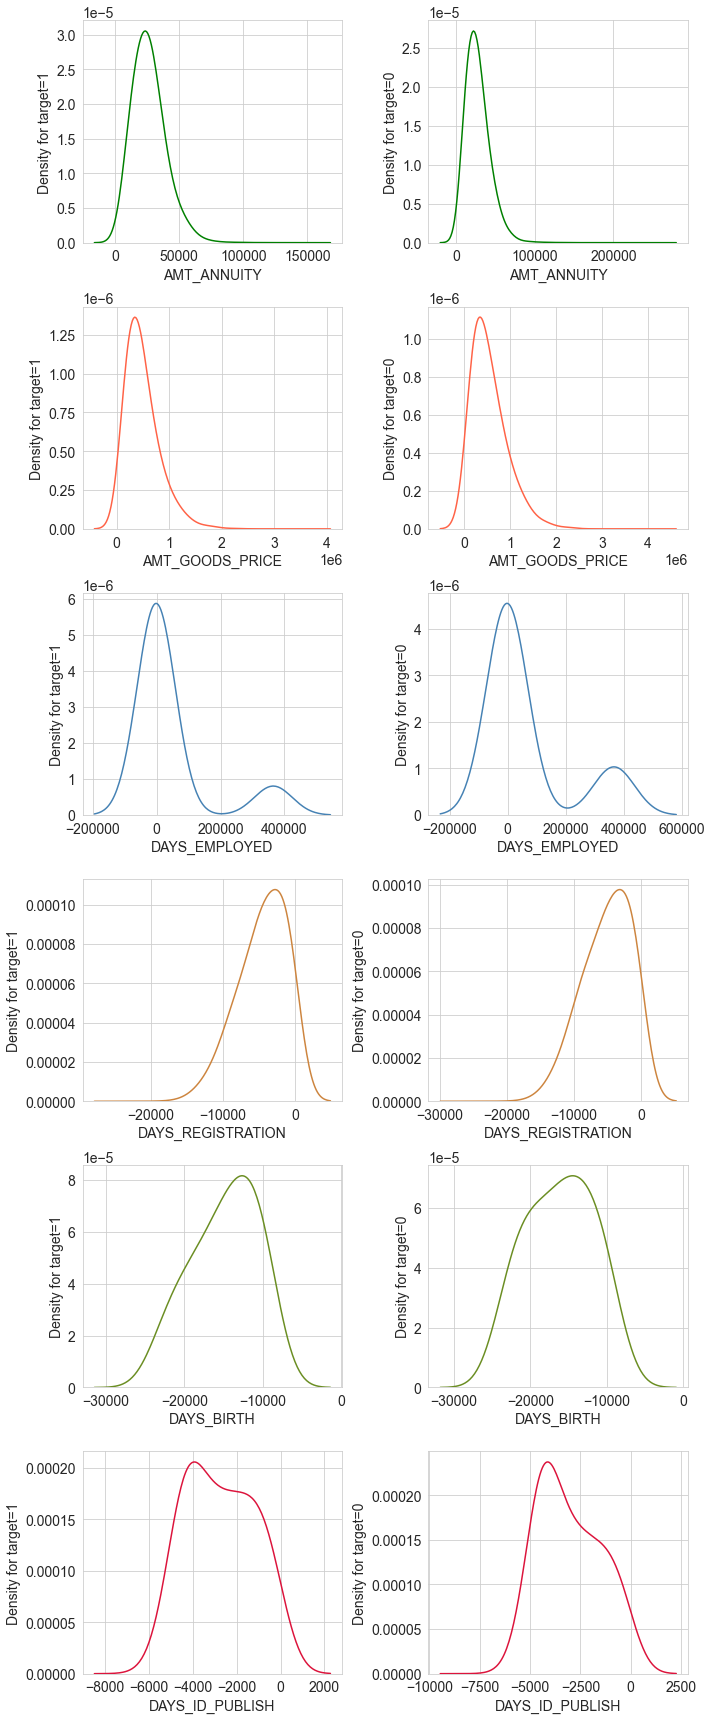

In [64]:
vars_to_plot = ['AMT_ANNUITY','AMT_GOODS_PRICE','DAYS_EMPLOYED', 'DAYS_REGISTRATION','DAYS_BIRTH','DAYS_ID_PUBLISH']
colors = ["green", "tomato", "steelblue", "peru", "olivedrab", "crimson"]
plot_distribution_comp(app_train, vars_to_plot, colors);

### 4.10. Region registered not live region and not work region

Let's represent the values of region registered and not live region and region registered and not work region.

In [65]:
plot_stats(app_train, 'REG_REGION_NOT_LIVE_REGION')
plot_stats(app_train, 'REG_REGION_NOT_WORK_REGION')

Very few people are registered in not live or not work region. Generally, the rate of not return is slightly larger for these cases than in the rest (slightly above 8% compared with approx. 8%)

### 4.11. City registered not live city and not work city

Let's represent the values of City registered not live city and not work city.

In [66]:
plot_stats(app_train, 'REG_CITY_NOT_LIVE_CITY')
plot_stats(app_train, 'REG_CITY_NOT_WORK_CITY')

Generally, much more people register in the city they live or work (a larger number register differently in the working city than living city).

The ones that register in different city than the working or living city are more frequently not-repaying the loans than the ones that register same city (work 11% or live 12%).

## 5. Bureau data

Bureau data contains all client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in the sample). For every loan in the sample, there are as many rows as number of credits the client had in Credit Bureau before the application date. **SK_ID_CURR** is the key connecting *application_train*|*test* data with *bureau* data.

Let's merge *application_train* with *bureau*.

In [67]:
app_bureau_train = app_train.merge(bureau, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='inner')

In [68]:
print("The resulting dataframe `application_bureau_train` has ",app_bureau_train.shape[0]," rows and ", 
      app_bureau_train.shape[1]," columns.")

The resulting dataframe `application_bureau_train` has  1465325  rows and  138  columns.


Creating a specific dataframe for date in day and transform them to years.

In [69]:
app_bureau_train.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100002       1         Cash loans           M            N   
2      100002       1         Cash loans           M            N   
3      100002       1         Cash loans           M            N   
4      100002       1         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY_x  \
0               Y             0       202500.0000 406597.5000     24700.5000   
1               Y             0       202500.0000 406597.5000     24700.5000   
2               Y             0       202500.0000 406597.5000     24700.5000   
3               Y             0       202500.0000 406597.5000     24700.5000   
4               Y             0       202500.0000 406597.5000     24700.5000   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0      351000.0000   Unaccompanied          Working   
1      351000.0000   Unaccompanied          Working   
2      351000.0000   Unaccompanied          Working   
3      351000.0000   Unaccompanied          Working   
4      351000.0000   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1  Secondary / secondary special  Single / not married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special  Single / not married  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                      0.0188       -9461           -637         -3648.0000   
1                      0.0188       -9461           -637         -3648.0000   
2                      0.0188       -9461           -637         -3648.0000   
3                      0.0188       -9461           -637         -3648.0000   
4                      0.0188       -9461           -637         -3648.0000   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1            -2120          NaN           1               1                0   
2            -2120          NaN           1               1                0   
3            -2120          NaN           1               1                0   
4            -2120          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers           1.0000   
1                 1           1           0        Laborers           1.0000   
2                 1           1           0        Laborers           1.0000   
3                 1           1           0        Laborers           1.0000   
4                 1           1           0        Laborers           1.0000   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     2                            2   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                  WEDNESDAY                       10   
2                  WEDNESDAY                       10   
3                  WEDNESDAY                       10   
4                  WEDNESDAY                       10   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2            

In [70]:
app_bureau_train_dates = app_bureau_train[["DAYS_CREDIT", "CREDIT_DAY_OVERDUE", "DAYS_CREDIT_ENDDATE", 
                           "DAYS_ENDDATE_FACT", "DAYS_CREDIT_UPDATE"]]

In [71]:
app_bureau_train_dates["DAYS_CREDIT_y"] = app_bureau_train_dates["DAYS_CREDIT"]/365
app_bureau_train_dates["CREDIT_DAY_OVERDUE_y"] = app_bureau_train_dates["CREDIT_DAY_OVERDUE"]/365
app_bureau_train_dates["DAYS_CREDIT_ENDDATE_y"] = app_bureau_train_dates["DAYS_CREDIT_ENDDATE"]/365
app_bureau_train_dates["DAYS_ENDDATE_FACT_y"] = app_bureau_train_dates["DAYS_ENDDATE_FACT"]/365
app_bureau_train_dates["DAYS_CREDIT_UPDATE_y"] = app_bureau_train_dates["DAYS_CREDIT_UPDATE"]/365

<ipython-input-71-24c3b30e3e7f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_bureau_train_dates["DAYS_CREDIT_y"] = app_bureau_train_dates["DAYS_CREDIT"]/365
<ipython-input-71-24c3b30e3e7f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_bureau_train_dates["CREDIT_DAY_OVERDUE_y"] = app_bureau_train_dates["CREDIT_DAY_OVERDUE"]/365
<ipython-input-71-24c3b30e3e7f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

Let's now analize the *application_bureau_train* data.

### 5.1. Credit status

Let's see the credit status distribution. We show first the number of credits per category (could be *Closed*, *Active*, *Sold* and *Bad debt*).

In [72]:
plot_stats(app_bureau_train, 'CREDIT_ACTIVE')

In [73]:
bureau_credit_status = bureau.groupby("CREDIT_ACTIVE").mean()
bureau_credit_status = bureau_credit_status[["CREDIT_DAY_OVERDUE", "AMT_CREDIT_SUM_OVERDUE"]]
bureau_credit_status

CREDIT_DAY_OVERDUE  AMT_CREDIT_SUM_OVERDUE
CREDIT_ACTIVE                                            
Active                     1.8103                 89.7392
Bad debt                 313.6190              45818.0271
Closed                     0.1047                  2.6816
Sold                      21.9364                709.0496

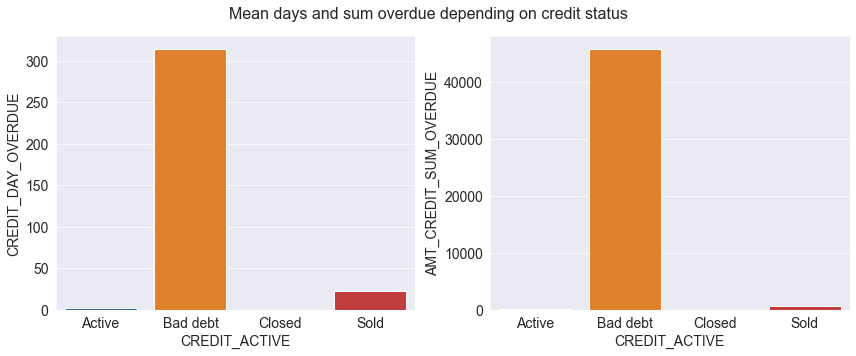

In [74]:
sns.set_style("darkgrid")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), tight_layout=True)
fig.suptitle("Mean days and sum overdue depending on credit status")

sns.barplot(ax=ax1, data=bureau_credit_status, y="CREDIT_DAY_OVERDUE", x=bureau_credit_status.index)
sns.barplot(ax=ax2, data=bureau_credit_status, y="AMT_CREDIT_SUM_OVERDUE", x=bureau_credit_status.index);

Most of the credits registered at the Credit Bureau are in the status *Closed* (~900K). On the second place are the *Active* credits ( a bit under 600K). *Sold* and *Bad debt* are just a few.

In the same time, as percent having **TARGET = 1** from total number per category, clients with credits registered to the Credit Bureau with *Bad debt* have 20%  default on the currrent applications. 


Clients with credits *Sold*, *Active* and *Closed* have percent of **TARGET = 1** (default credit) equal or less than 10% (10% being the rate overall). The smallest rate of default credit have the clients with credits registered at the Credit Bureau with *Closed* credits.

That means the former registered credit history (as registered at Credit Bureau) is a strong predictor for the dafault credit, since the percent of applications defaulting with a history of *Bad debt* is twice as large as for *Sold* or *Active* and almost three times larger as for *Closed*.

### 5.2. Credit currency

Let's check now the number of credits registered at the Credit Bureau with different currencies. Also, let's check procent of defaulting credits (for current applications) per different currencies of credits credits registered at the Credit Bureau in the past for the same client.

In [75]:
plot_stats(app_bureau_train, 'CREDIT_CURRENCY')

In [76]:
bureau_currency = bureau.groupby("CREDIT_CURRENCY").mean()
bureau_currency = bureau_currency[["CREDIT_DAY_OVERDUE", "AMT_CREDIT_SUM_OVERDUE"]]
bureau_currency

CREDIT_DAY_OVERDUE  AMT_CREDIT_SUM_OVERDUE
CREDIT_CURRENCY                                            
currency 1                   0.8188                 37.9432
currency 2                   0.0000                  0.9118
currency 3                   0.0000                  0.0000
currency 4                   0.0000                  0.0000

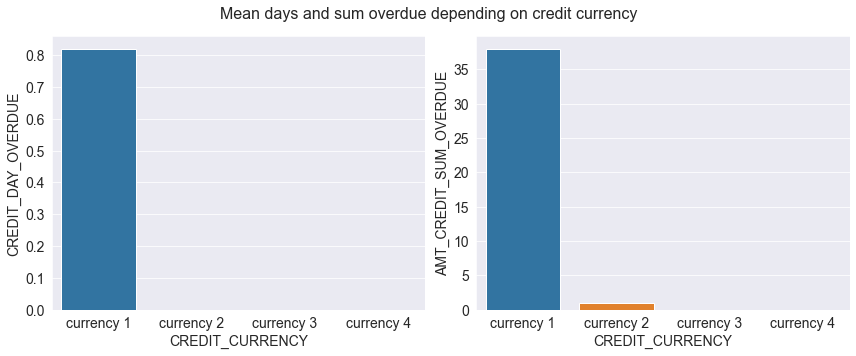

In [77]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), tight_layout=True)
fig.suptitle("Mean days and sum overdue depending on credit currency")

sns.barplot(ax=ax1, data=bureau_currency, y="CREDIT_DAY_OVERDUE", x=bureau_currency.index)
sns.barplot(ax=ax2, data=bureau_currency, y="AMT_CREDIT_SUM_OVERDUE", x=bureau_currency.index);

Credits are mostly in *currency_1*.

Depending on the currency, the percent of clients defaulting is quite different. Starting with *currency_3*, then *currency_1* and *currency_2*, the percent of clients defaulting is 11%, 8% and 5%. Percent of defaulting applications for clients that have credits registered with *currency_4* is close to 0.

### 5.3. Credit type

Let's check now the credit types for credits registered at the Credit Bureau.

In [78]:
perc_previous_credit_type = plot_stats(app_bureau_train, 'CREDIT_TYPE', 
                                    label_rotation=True, return_df=True,
                                    plot_height=600)

Majority of historical credits registered at the Credit Bureau are *Consumer credit* and *Credit card*. Smaller number of credits are *Car loan*, *Mortgage* and *Microloan*.

Looking now to the types of historical credits registered at the Credit Bureau, there are few types with a high percent of current credit defaults, as following:  
* *Loan for the purchase of equipment* - with over 20% current credits defaults;  
* *Microloan* - with over 20% current credits defaults;  
* *Loan for working capital replenishement* - with over 12% current credits defaults.  


We will create a score between 0 and 10 proportional to the default % of previous credit types. 0 is the lowest default risk, 10 the highest.

### 5.4. Duration of credit (DAYS_CREDIT_y)

Let's check the distribution of number of years for the credit (registered at the Credit bureau).

In [79]:
plot_distrib(app_bureau_train_dates, "DAYS_CREDIT_y", "goldenrod", "orange", True)

The credit duration (in days) is ranging between about 8 years (with a local sadle around 7 years) and with a increasing frequence for shorter number of days - and with a peak around 1 year.

### 5.5. Credit overdue (CREDIT_DAY_OVERDUE)

Let's check the distribution of number of days for the credit overdue (registered at the Credit bureau).

In [80]:
plot_distrib(app_bureau_train_dates, "CREDIT_DAY_OVERDUE_y", "darkslategrey", "teal")

Most of the credits have 0 or close to 0 days overdue. The maximum number of credit days overdue is ~ 7 years and a half.

### 5.6. Credit sum  (AMT_CREDIT_SUM)

In [81]:
plot_distrib(app_bureau_train, "AMT_CREDIT_SUM", "blue", "slateblue")

The distribution of the AMT_CREDIT_SUM shows a concentration of the credits for the lower credit sum range.

Let's remove the outliers so that we can see better the distribution around 0.

In [82]:
plot_distrib(app_bureau_train, "AMT_CREDIT_SUM", "saddlebrown", "chocolate", filter_outliers=True)

<ipython-input-52-cf54378a33ef>:26: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  points = points[:,None]


We can observe that the distribution function shows several peaks and the maximum concentration of the values is around 20,000 but we also see several other peaks at higher values.

### 5.7. Credit sum limit (AMT_CREDIT_SUM_LIMIT)

In [83]:
plot_distrib(app_bureau_train, "AMT_CREDIT_SUM_LIMIT", "brown", "tomato")

In [84]:
plot_distrib(app_bureau_train, "AMT_CREDIT_SUM_LIMIT", "brown", "tomato", filter_outliers=True, thresh=10)

<ipython-input-52-cf54378a33ef>:26: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  points = points[:,None]


An overwhelming majority of values for this feture are 0.

### 5.8. Comparison of interval values with TARGET = 1 and TARGET = 0

Let's compare the distribution of interval values ploted above for values of **TARGET = 1** and **TARGET = 0**

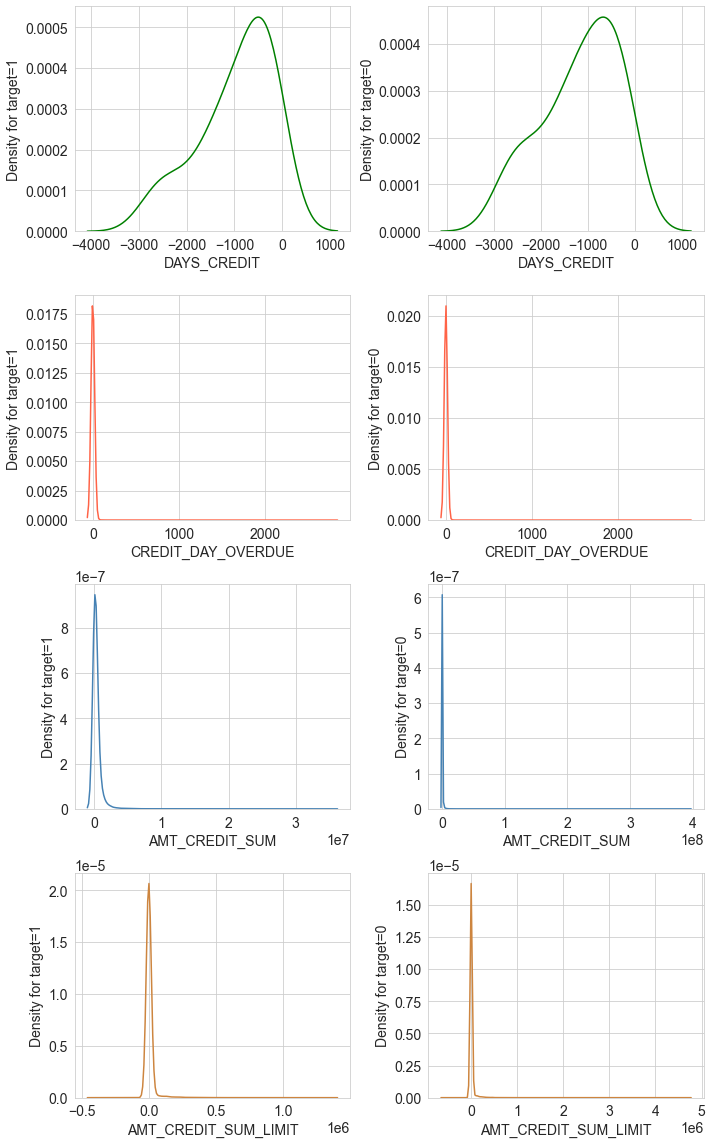

In [85]:
vars_to_plot = ['DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_LIMIT']
colors = ["green", "tomato", "steelblue", "peru"]
plot_distribution_comp(app_bureau_train, vars_to_plot, colors)

Densities are very similar, with a slight variation for `DAYS_CREDIT` with more very negative values (around 2000 - 3000 days).

## 6. Previous application data


The dataframe *previous_application* contains information about all previous applications for Home Credit loans of clients who have loans in the sample. There is one row for each previous application related to loans in our data sample. **SK_ID_CURR** is the key connecting *application_train*|*test* data with *previous_application* data.

Let's merge *application_train* with *previous_application*.

In [86]:
app_prev_train = app_train.merge(previous_app, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='inner')

In [87]:
print("The resulting dataframe `application_prev_train` has ", app_prev_train.shape[0]," rows and ", 
      app_prev_train.shape[1]," columns.")

The resulting dataframe `application_prev_train` has  1413701  rows and  158  columns.


### 6.1. Contract type

In [88]:
plot_stats(app_prev_train, "NAME_CONTRACT_TYPE_y", label_rotation=True, plot_height=450)

There are 4 types of contract in the previous application data: *Cash loans*, *Consumer loans*, *Revolving loans*, *XNA*. *Cash loans* and *Consumer loans* are almost the same number (~45%) whilst *Revolving loans* are ~10% and only a few hundreds *XNA*.

The percent of defauls loans for clients with previous applications is different for the type of previous applications contracts, decreasing from ~20% for *XNA* to ~10% for *Revolving loans*, then ~ 9.5% for *Cash loans* and ~7.5% for *Consumer loans*.

### 6.2. Cash loan purpose

Let's look to the cash loan purpose, in the case of cash loans.

In [89]:
perc_cash_loan_purpose = plot_stats(app_prev_train, "NAME_CASH_LOAN_PURPOSE", label_rotation=True, 
    return_df=True, plot_height=550)

Besides not identifed/not available categories, *Repairs*, *Other*, *Urgent needs*, *Buying a used car*, *Building a house or an annex* accounts for the largest number of contracts.


In terms of percent of defaults for current applications in the sample, clients with history of previous applications have largest percents of defaults when in their history are previous applications for cash loans for *Refusal to name the goal* - ~23% (which makes a lot of sense), *Hobby* (20%), *Car repairs* (~18%).

### 6.3. Contract status

Let's look to the contract status.

In [90]:
plot_stats(app_prev_train, "NAME_CONTRACT_STATUS", label_rotation=True, plot_height=450)

Most previous applications contract statuses are *Approved* (~60%), *Canceled* and *Refused* (~19%). There are only ~1% in status *Unused offer*.

In terms of percent of defaults for current applications in the sample, clients with history of previous applications have largest percents of defaults when in their history contract statuses are *Refused* (12%), followed by *Canceled* (9%), *Unused offer* (~8%) and *Approved* (lowest percent of defaults in current applictions, with less than 8%).

### 6.4. Payment type

Let's check the payment type.

In [91]:
plot_stats(app_prev_train, "NAME_PAYMENT_TYPE", label_rotation=True, plot_height=600)

Most of the previous applications were paid with *Cash through the bank* (>60%). Payments using *Non-cash from your account* or *Cashless from the account of the employer* are much rare. These three types of payments in previous applications results in allmost the same percent of defaults for current clients (~8% each).

### 6.5. Client type

Let's check the client type for previous applications.

In [92]:
plot_stats(app_prev_train, "NAME_CLIENT_TYPE")

Most of the previous applications have client type *Repeater* (>70%), ~19% are *New* and <10% are *Refreshed*.

In terms of default percent for current applications of clients with history of previous applications, current clients with previous applications have values of percent of defaults ranging from from 8.5%, 8.25% and 7% corresponding to client types in the past *New*, *Repeater* and *Refreshed*, respectivelly.

### 6.6. Purpose of previous application

In [93]:
perc_name_cash_loan_purpose = plot_stats(app_prev_train, "NAME_CASH_LOAN_PURPOSE", label_rotation=True, 
    return_df=True, plot_height=550)

More than 50% of cash loans havea *XAP* purpose (?). The impact on target is variable, an do not seem significant (few clients), except for *repairs* and *urgent needs* that have a higher percentage of default (13 and 15% instead of the mean 8%).

### 6.7. Code for rejection reason in previous application.

In [94]:
perc_code_reject_reason = plot_stats(app_prev_train, "CODE_REJECT_REASON", label_rotation=True, 
    return_df=True, plot_height=450)

Code of rejection reason of previous application is *XAP* for more than 80% of clients. The risk of default is significantly higher when the code is *SCOFR*, *LIMIT* or *HC*.

### 6.8. What kind of goods did the client apply for in the previous application

In [95]:
plot_stats(app_prev_train, "NAME_GOODS_CATEGORY", label_rotation=True, plot_height=500)

Most clients who made a previous loan to buy goods use it for mobile phones, electronics, computers, and audio/video devices. The risk of default increases slightly when the credit is used for insurances or auto accessories and is significantly lower when used for fitness or tourism.

### 6.9. Name yield group

In [96]:
perc_name_yield_group = plot_stats(app_prev_train, "NAME_YIELD_GROUP", label_rotation=True, 
    return_df=True, plot_height=450)

The proportion of classes of `NAME_YIELD_GROUP` is rather equilibrated, except a very low amount of *low_action* (<5 %). The risk of default corresponds quite well to the class: lower than mean for *low_action*, higher for *high*, etc.

### 6.10. Product combination

In [97]:
perc_product_combination = plot_stats(app_prev_train, "PRODUCT_COMBINATION", label_rotation=True, 
    return_df=True, plot_height=550)

The most common type of `PRODUCT_COMBINATION` are *Cash*, *POS household with interest* and *POS mobile with interest*. Overall, all types of *Card* and *Cash street* products have a higher risk of default whereas *POS* type have a mean or lower risk.

### 6.11. Channel type

In [98]:
perc_channel_type = plot_stats(app_prev_train, "CHANNEL_TYPE", label_rotation=True, 
    return_df=True, plot_height=500)

More than 40% of loans are made through *Credit and cash offices*. The risk of default is increased for *AP+ (Cash loan)* and *Contact center*.

### 6.12. Name seller industry

In [99]:
perc_name_seller_industry = plot_stats(app_prev_train, "NAME_SELLER_INDUSTRY", label_rotation=True, 
    return_df=True, plot_height=500)

The largest part of credit made trough industry sellers concern *Consumer electronics* and *Connectivity*. The risk of default is increased with *Auto technology*, *Connectivity* and *Jewelry* and lower than mean risk with *Clothing* and *Tourism*.

### 6.13. Name goods category

In [100]:
perc_name_goods_category = plot_stats(app_prev_train, "NAME_GOODS_CATEGORY", label_rotation=True, 
    return_df=True, plot_height=500)

Most previous loans registered at the Bureau were made for *Mobiles*, *Consumer Electronics*, *Computers* and *Audio/Video* goods. The risk of default is increased for *Auto accessories* and *Homewares* and decreased for *Fitness* and *Tourism*.

## 7. POS_CASH balance

In [101]:
pos_cash.head()

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
0     1803195      182943             -31         48.0000   
1     1715348      367990             -33         36.0000   
2     1784872      397406             -32         12.0000   
3     1903291      269225             -35         48.0000   
4     2341044      334279             -35         36.0000   

   CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                45.0000               Active       0           0  
1                35.0000               Active       0           0  
2                 9.0000               Active       0           0  
3                42.0000               Active       0           0  
4                35.0000               Active       0           0

In [102]:
app_train_pos = app_train.merge(pos_cash, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='inner')

In [103]:
print("The resulting dataframe `app_train_pos` has ", app_train_pos.shape[0]," rows and ", 
      app_train_pos.shape[1]," columns.")

The resulting dataframe `app_train_pos` has  8543375  rows and  129  columns.


In [104]:
plot_stats(app_train_pos, "NAME_CONTRACT_STATUS", label_rotation=True, plot_height=500)

More than 80% of credits are *Active*. The risk of default is greatly increased when the credit is *Amortized debt*, *Canceled*, slightly increased with *Demand* of *Returned to the store*. 

## 8. Merging datasets and feature engineering

Most features are created by applying min, max, mean, sum and var functions to grouped tables. 
All tables are joined with the application DF using the SK_ID_CURR key (except bureau_balance).
The following key ideas were used:
* Divide or subtract important features to get rates (like annuity and income)
* Modularity: one function for each table (except bureau_balance and application_test)
* Categorical variables to merge are replaced by the score between 0 and 10 calculated in the EDA and based on the % of the clients belonging to the classes who made default.
* Categorical variable of the application_train dataset are left untouch (encoded later in the modeling part).

### 8.1. Transform important categorical features

In [105]:
perc_previous_credit_type

CREDIT_TYPE  perc_defaults  \
0                           Another type of loan         7.1429   
1                                       Car loan         5.5731   
2                      Cash loan (non-earmarked)         4.3478   
3                                Consumer credit         7.4837   
4                                    Credit card         8.8009   
5                               Interbank credit         0.0000   
6                  Loan for business development         6.1592   
7   Loan for purchase of shares (margin lending)         0.0000   
8             Loan for the purchase of equipment        23.5294   
9         Loan for working capital replenishment        12.7321   
10                                     Microloan        20.6441   
11                          Mobile operator loan         0.0000   
12                                      Mortgage         4.9978   
13                              Real estate loan         0.0000   
14                          Unknown type of loan         6.1441   

    count_defaults   colors  
0          61.0000  #440154  
1        1324.0000  #481A6C  
2           1.0000  #46317E  
3       80046.0000  #3F4788  
4       30262.0000  #365A8C  
5         106.0000  #2E6D8E  
6           4.0000  #277E8E  
7          48.0000  #208F8C  
8        1859.0000  #1EA087  
9         780.0000  #2BB17D  
10         29.0000  #49C16D  
11             NaN  #70CE56  
12             NaN  #9DD93A  
13             NaN  #CDE01D  
14             NaN  #FDE724

In [106]:
def categorical_to_ordinal(df, feature):
    """
    Transform a categorical feature into a numeric one (score).
    The created score (between 0 and 10) is proportional to the % of previous application with credit default.
    10 means the highest default risk, 0 the lowest.
    Return a dataframe with mean values for target=1 (non-repaid loans) and corresponding scores,
    and a dictionnary with classes and score.
    """
    score_name = "SCORE_" + feature
    # Making a score
    df.sort_values(by="perc_defaults", ascending=False, inplace=True)
    df[score_name] = df["perc_defaults"]*10/df["perc_defaults"].max()
    
    # Create a dict with score values for future mapping
    score_df = df.set_index(feature)
    score_df.drop(columns=["perc_defaults", "count_defaults", "colors"], axis=1, inplace=True)
    score_dict = score_df.to_dict("index")
    keys = list(score_dict.keys())
    values = [score_dict[k][score_name] for k in keys]
    score_dict = {k:v for k, v in zip(keys, values)}
    score_dict

    return df, score_dict

#### 8.1.1. Bureau and bureau balance

Following our exploration analysis, we will create ordinal categorical features and numerical features based on the % of clients with non-repaid loans for this category. A higher value will always mean a higher risk of default.

Categorical features with little or no impact on default risk will be dropped.

In [107]:
# Mapping ordinal categorical features
categ_bb_status = {"X": np.nan,
                    "C": 0,
                    "0": 0,
                    "1": 1,
                    "2": 2,
                    "3": 3,
                    "4": 4,
                    "5": 5}
categ_b_currency = {"currency 4": 0,
                    "currency 2": 1,
                    "currency 1": 2,
                    "currency 3": 3}
categ_b_credit_active = {"Closed": 0,
                    "Active": 1,
                    "Sold": 1,
                    "Bad debt": 2}

In [108]:
# Making a score from % of non-repaid loans
perc_previous_credit_type, score_credit_type = categorical_to_ordinal(perc_previous_credit_type, "CREDIT_TYPE")

In [109]:
# Example of score
# perc_defaults = % of non repaid-loans with this CREDIT_TYPE category
# Score_credit_type = attributed score (between 0 and 10)
perc_previous_credit_type

CREDIT_TYPE  perc_defaults  \
8             Loan for the purchase of equipment        23.5294   
10                                     Microloan        20.6441   
9         Loan for working capital replenishment        12.7321   
4                                    Credit card         8.8009   
3                                Consumer credit         7.4837   
0                           Another type of loan         7.1429   
6                  Loan for business development         6.1592   
14                          Unknown type of loan         6.1441   
1                                       Car loan         5.5731   
12                                      Mortgage         4.9978   
2                      Cash loan (non-earmarked)         4.3478   
5                               Interbank credit         0.0000   
7   Loan for purchase of shares (margin lending)         0.0000   
11                          Mobile operator loan         0.0000   
13                              Real estate loan         0.0000   

    count_defaults   colors  SCORE_CREDIT_TYPE  
8        1859.0000  #1EA087            10.0000  
10         29.0000  #49C16D             8.7737  
9         780.0000  #2BB17D             5.4111  
4       30262.0000  #365A8C             3.7404  
3       80046.0000  #3F4788             3.1806  
0          61.0000  #440154             3.0357  
6           4.0000  #277E8E             2.6177  
14             NaN  #FDE724             2.6112  
1        1324.0000  #481A6C             2.3686  
12             NaN  #9DD93A             2.1240  
2           1.0000  #46317E             1.8478  
5         106.0000  #2E6D8E             0.0000  
7          48.0000  #208F8C             0.0000  
11             NaN  #70CE56             0.0000  
13             NaN  #CDE01D             0.0000

In [110]:
# Dict for futur mapping
score_credit_type

{'Loan for the purchase of equipment': 10.0,
 'Microloan': 8.773736812881733,
 'Loan for working capital replenishment': 5.411140583554377,
 'Credit card': 3.740362887629307,
 'Consumer credit': 3.180556464505755,
 'Another type of loan': 3.0357142857142856,
 'Loan for business development': 2.617664148750727,
 'Unknown type of loan': 2.6112288135593222,
 'Car loan': 2.3685650545102495,
 'Mortgage': 2.12404690203114,
 'Cash loan (non-earmarked)': 1.847826086956522,
 'Interbank credit': 0.0,
 'Loan for purchase of shares (margin lending)': 0.0,
 'Mobile operator loan': 0.0,
 'Real estate loan': 0.0}

In [111]:
# Replacing categorical features by numerical/ordinal ones in bureau and bureau balance datasets
bureau_all_num = bureau.copy()
bureau_bal_all_num = bureau_bal.copy()

features = ["CREDIT_ACTIVE", "CREDIT_CURRENCY", "CREDIT_TYPE"]
scores = [categ_b_credit_active, categ_b_currency, score_credit_type]

for feature, score in zip(features, scores):
    bureau_all_num[feature] = bureau_all_num[feature].map(score)

bureau_bal_all_num["STATUS"] = bureau_bal_all_num["STATUS"].map(categ_bb_status)

In [112]:
bureau_all_num.head()

SK_ID_CURR  SK_ID_BUREAU  CREDIT_ACTIVE  CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462              0                2         -497   
1      215354       5714463              1                2         -208   
2      215354       5714464              1                2         -203   
3      215354       5714465              1                2         -203   
4      215354       5714466              1                2         -629   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0            -153.0000          -153.0000   
1                   0            1075.0000                NaN   
2                   0             528.0000                NaN   
3                   0                  NaN                NaN   
4                   0            1197.0000                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0      91323.0000   
1                     NaN                   0     225000.0000   
2                     NaN                   0     464323.5000   
3                     NaN                   0      90000.0000   
4              77674.5000                   0    2700000.0000   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0               0.0000                   NaN                  0.0000   
1          171342.0000                   NaN                  0.0000   
2                  NaN                   NaN                  0.0000   
3                  NaN                   NaN                  0.0000   
4                  NaN                   NaN                  0.0000   

   CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0       3.1806                -131          NaN  
1       3.7404                 -20          NaN  
2       3.1806                 -16          NaN  
3       3.7404                 -16          NaN  
4       3.1806                 -21          NaN

In [113]:
bureau_bal_all_num.head()

SK_ID_BUREAU  MONTHS_BALANCE  STATUS
0       5715448               0  0.0000
1       5715448              -1  0.0000
2       5715448              -2  0.0000
3       5715448              -3  0.0000
4       5715448              -4  0.0000

#### 8.1.2. Previous applications

Same procedure as for bureau and bureau balance datasets.

In [114]:
# Defining ordinal categories depending on default risk
categ_prev_name_contract_type = {"XNA": 4,
                                "Revolvng loans": 2,
                                "Cash loans": 1,
                                "Consumer loans": 0}
categ_prev_name_contract_status = {"Refused": 3,
                                "Canceled": 2,
                                "Unused offer": 1,
                                "Approved": 0}
categ_prev_name_yield_group = {"XNA": 3,
                                "High": 3,
                                "middle": 2,
                                "low_normal": 1,
                                "low_action": 0}
categ_prev_name_product_type = {"walk-in":1,
                                "XNA": 0,
                                "x-sell": 3}
categ_prev_flag_last_appl_per_contract = {"N": 1, "Y": 0}

In [115]:
# Making scores from categories proportional to default risk
perc_code_reject_reason, score_code_reject_reason = categorical_to_ordinal(perc_code_reject_reason, "CODE_REJECT_REASON")
perc_name_cash_loan_purpose, score_name_cash_loan_purpose = categorical_to_ordinal(perc_name_cash_loan_purpose, 
                                                                                "NAME_CASH_LOAN_PURPOSE")
perc_product_combination, score_product_combination = categorical_to_ordinal(perc_product_combination, "PRODUCT_COMBINATION")
perc_channel_type, score_channel_type = categorical_to_ordinal(perc_channel_type, "CHANNEL_TYPE")
perc_name_seller_industry, score_name_seller_industry = categorical_to_ordinal(perc_name_seller_industry, "NAME_SELLER_INDUSTRY")
perc_name_goods_category, score_name_goods_category = categorical_to_ordinal(perc_name_goods_category, "NAME_GOODS_CATEGORY")

In [116]:
previous_app_all_num = previous_app.copy()

features = ["NAME_CONTRACT_TYPE", "NAME_CONTRACT_STATUS", "NAME_YIELD_GROUP", "NAME_PRODUCT_TYPE", "FLAG_LAST_APPL_PER_CONTRACT", 
    "CODE_REJECT_REASON", "NAME_CASH_LOAN_PURPOSE", "PRODUCT_COMBINATION", 
    "CHANNEL_TYPE", "NAME_SELLER_INDUSTRY", "NAME_GOODS_CATEGORY"]
scores = [categ_prev_name_contract_type, categ_prev_name_contract_status, categ_prev_name_yield_group,
    categ_prev_name_product_type, categ_prev_flag_last_appl_per_contract,
    score_code_reject_reason, score_name_cash_loan_purpose, score_product_combination,
    score_channel_type, score_name_seller_industry, score_name_goods_category]

# Replace classes by ordinal or numerical value
for feature, score in zip(features, scores):
    previous_app_all_num[feature] = previous_app_all_num[feature].map(score)

# Drop categorical columns with little influence on default risk
previous_app_all_num.drop(["WEEKDAY_APPR_PROCESS_START", "NAME_PAYMENT_TYPE", "NAME_TYPE_SUITE", "NAME_CLIENT_TYPE",
    "NAME_PORTFOLIO"], axis=1, inplace=True)

In [117]:
previous_app_all_num.head()

SK_ID_PREV  SK_ID_CURR  NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877              0.0000    1730.4300       17145.0000   
1     2802425      108129              1.0000   25188.6150      607500.0000   
2     2523466      122040              1.0000   15060.7350      112500.0000   
3     2819243      176158              1.0000   47041.3350      450000.0000   
4     1784265      202054              1.0000   31924.3950      337500.0000   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE  HOUR_APPR_PROCESS_START  \
0  17145.0000            0.0000       17145.0000                       15   
1 679671.0000               NaN      607500.0000                       11   
2 136444.5000               NaN      112500.0000                       11   
3 470790.0000               NaN      450000.0000                        7   
4 404055.0000               NaN      337500.0000                        9   

   FLAG_LAST_APPL_PER_CONTRACT  NFLAG_LAST_APPL_IN_DAY  RATE_DOWN_PAYMENT  \
0                            0                       1             0.0000   
1                            0                       1                NaN   
2                            0                       1                NaN   
3                            0                       1                NaN   
4                            0                       1                NaN   

   RATE_INTEREST_PRIMARY  RATE_INTEREST_PRIVILEGED  NAME_CASH_LOAN_PURPOSE  \
0                 0.1828                    0.8673                  3.5883   
1                    NaN                       NaN                  3.7775   
2                    NaN                       NaN                  3.7775   
3                    NaN                       NaN                  3.7775   
4                    NaN                       NaN                  5.6350   

   NAME_CONTRACT_STATUS  DAYS_DECISION  CODE_REJECT_REASON  \
0                     0            -73              3.7975   
1                     0           -164              3.7975   
2                     0           -301              3.7975   
3                     0           -512              3.7975   
4                     3           -781              5.6067   

   NAME_GOODS_CATEGORY  NAME_PRODUCT_TYPE  CHANNEL_TYPE  SELLERPLACE_AREA  \
0               8.3588                  0        6.4367                35   
1               9.0729                  3        8.0067                -1   
2               9.0729                  3        7.0253                -1   
3               9.0729                  3        7.0253                -1   
4               9.0729                  1        7.0253                -1   

   NAME_SELLER_INDUSTRY  CNT_PAYMENT  NAME_YIELD_GROUP  PRODUCT_COMBINATION  \
0                8.8806      12.0000            2.0000               7.5852   
1                9.0238      36.0000            0.0000               5.6676   
2                9.0238      12.0000               NaN               9.8950   
3                9.0238      12.0000            2.0000               6.7461   
4                9.0238      24.0000               NaN               9.7833   

   DAYS_FIRST_DRAWING  DAYS_FIRST_DUE  DAYS_LAST_DUE_1ST_VERSION  \
0         365243.0000        -42.0000                   300.0000   
1         365243.0000       -134.0000                   916.0000   
2         365243.0000       -271.0000                    59.0000   
3         365243.0000       -482.0000                  -152.0000   
4                 NaN             NaN                        NaN   

   DAYS_LAST_DUE  DAYS_TERMINATION  NFLAG_INSURED_ON_APPROVAL  
0       -42.0000          -37.0000                     0.0000  
1    365243.0000       365243.0000                     1.0000  
2    365243.0000       365243.0000                     1.0000  
3      -182.0000         -177.0000                     1.0000  
4            NaN               NaN                        NaN

### 8.1.3. POS_CASH balance

In [118]:
pos_cash_all_num = pos_cash.copy()

categ_pos_name_contract_status = {"Amortized debt": 4,
                                "Canceled": 2,
                                "Demand": 1,
                                "Returned to the store": 1,
                                "XNA": 0,
                                "Signed": 0,
                                "Completed": 0,
                                "Approved": 0,
                                "Active": 0}

pos_cash_all_num["NAME_CONTRACT_STATUS"] = pos_cash_all_num["NAME_CONTRACT_STATUS"].map(categ_pos_name_contract_status)

In [119]:
pos_cash_all_num.head()

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
0     1803195      182943             -31         48.0000   
1     1715348      367990             -33         36.0000   
2     1784872      397406             -32         12.0000   
3     1903291      269225             -35         48.0000   
4     2341044      334279             -35         36.0000   

   CNT_INSTALMENT_FUTURE  NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                45.0000                     0       0           0  
1                35.0000                     0       0           0  
2                 9.0000                     0       0           0  
3                42.0000                     0       0           0  
4                35.0000                     0       0           0

### 8.2. Aggregation functions

The aggregation functions will transform each dataset in a dataframe with a single line per client. When the initial dataframe has several lines for one client, they will be aggregated using mean, max, min, sum, etc.

Finally, all dataframes are concatenated.

In [120]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

In [121]:
# Preprocess application_train.csv and application_test.csv
def application_train_agg(df, remove_XNA_CODE_GENDER=True, debug=False):
    
    print(f"INITIAL SHAPE: n_rows: {df.shape[0]} / n_columns: {df.shape[1]}.")
    
    # Optional: Debug mode: keep only the first 1000 rows
    # Optional: Remove 4 applications with XNA CODE_GENDER
    
    if debug:
        print("Debug mode ON")
        df_new = df[:1000].copy()
        if remove_XNA_CODE_GENDER:
            df_new[df_new['CODE_GENDER'] != 'XNA']
            print("Removed XNA_CODE_GENDER.")
    else:
        df_new = df.copy()
        if remove_XNA_CODE_GENDER:
            df_new = df_new[df_new['CODE_GENDER'] != 'XNA']
            print("Removed XNA_CODE_GENDER.")

    # Replace NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df_new['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df_new['DAYS_EMPLOYED_PERC'] = df_new['DAYS_EMPLOYED'] / df_new['DAYS_BIRTH']
    df_new['INCOME_CREDIT_PERC'] = df_new['AMT_INCOME_TOTAL'] / df_new['AMT_CREDIT']
    df_new['INCOME_PER_PERSON'] = df_new['AMT_INCOME_TOTAL'] / df_new['CNT_FAM_MEMBERS']
    df_new['ANNUITY_INCOME_PERC'] = df_new['AMT_ANNUITY'] / df_new['AMT_INCOME_TOTAL']
    df_new['PAYMENT_RATE'] = df_new['AMT_ANNUITY'] / df_new['AMT_CREDIT']
    # Collect garbages
    gc.collect()
    
    print(f"FINAL SHAPE: n_rows: {df_new.shape[0]} / n_columns: {df_new.shape[1]}.")
    return df_new

In [122]:
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance_agg(df_bureau, df_bureau_balance, debug=False):
    
    if debug:
        df_bureau_new = df_bureau[:1000].copy()
        df_bureau_balance_new = df_bureau_balance[:1000].copy()
    else:
        df_bureau_new = df_bureau.copy()
        df_bureau_balance_new = df_bureau_balance.copy()
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size'],
                      "STATUS": ["mean"]}

    bb_agg = df_bureau_balance_new.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    
    df_bureau_new = df_bureau_new.join(bb_agg, how='left', on='SK_ID_BUREAU')
    
    del bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    
    # Categorical (ordinal) aggregations
    cat_aggregations = {
        'CREDIT_ACTIVE': ['mean', 'sum'],
        'CREDIT_CURRENCY': ['mean'],
        'CREDIT_TYPE': ['mean', 'max']
    }
    
    bureau_agg = df_bureau_new.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BUREAU_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])

    return bureau_agg

In [123]:
# Preprocess previous_applications.csv
def previous_applications_agg(df, debug=False):
    
    if debug:
        df_prev_app = df[:1000].copy()
    else:
        df_prev_app = df.copy()

    # Days 365.243 values -> nan
    df_prev_app['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    df_prev_app['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    df_prev_app['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    df_prev_app['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    df_prev_app['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    df_prev_app['APP_CREDIT_PERC'] = df_prev_app['AMT_APPLICATION'] / df_prev_app['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {
        'NAME_CONTRACT_TYPE': ['max', 'mean'],
        'FLAG_LAST_APPL_PER_CONTRACT': ['mean'],
        'NAME_CASH_LOAN_PURPOSE': ['max', 'mean'],
        'NAME_CONTRACT_STATUS': ['max', 'mean'],
        'CODE_REJECT_REASON': ['max', 'mean'],
        'NAME_GOODS_CATEGORY': ['max', 'mean'],
        'NAME_PRODUCT_TYPE': ['mean'],
        'CHANNEL_TYPE': ['max', 'mean'],
        'NAME_SELLER_INDUSTRY': ['max', 'mean'],
        'NAME_YIELD_GROUP': ['mean'],
        'PRODUCT_COMBINATION': ['max', 'mean'],
    }
    
    prev_agg = df_prev_app.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])

    del df_prev_app
    gc.collect()

    return prev_agg

In [124]:
# Preprocess POS_CASH_balance.csv
def pos_cash_agg(df, debug=False):

    if debug:
        df_pos_cash = df[:1000].copy()
    else:
        df_pos_cash = df.copy()

    #df_pos_cash.drop(["CNT_INSTALMENT", "CNT_INSTALMENT_FUTURE", "SK_ID_PREV"], axis=1, inplace=True)

    # Numerical features aggregation
    num_aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }

    # categorical feature aggregation
    cat_aggregations = {
        'NAME_CONTRACT_STATUS': ['min', 'max']
    }
    
    pos_agg = df_pos_cash.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = df_pos_cash.groupby('SK_ID_CURR').size()

    del df_pos_cash
    gc.collect()
    
    return pos_agg

In [125]:
# Preprocess df_installtallments_payments.csv
def installments_payments_agg(df, debug=False):

    if debug:
        df_install = df[:1000].copy()
    else:
        df_install = df.copy()

    # Percentage and difference paid in each df_installtallment (amount paid and df_installtallment value)
    df_install['PAYMENT_PERC'] = df_install['AMT_PAYMENT'] / df_install['AMT_INSTALMENT']
    df_install['PAYMENT_DIFF'] = df_install['AMT_INSTALMENT'] - df_install['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    df_install['DPD'] = df_install['DAYS_ENTRY_PAYMENT'] - df_install['DAYS_INSTALMENT']
    df_install['DBD'] = df_install['DAYS_INSTALMENT'] - df_install['DAYS_ENTRY_PAYMENT']
    df_install['DPD'] = df_install['DPD'].apply(lambda x: x if x > 0 else 0)
    df_install['DBD'] = df_install['DBD'].apply(lambda x: x if x > 0 else 0)

    # Features: Perform aggregations
    num_aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }

    df_install_agg = df_install.groupby('SK_ID_CURR').agg(num_aggregations)
    df_install_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in df_install_agg.columns.tolist()])

    # Count installments accounts
    df_install_agg['INSTAL_COUNT'] = df_install.groupby('SK_ID_CURR').size()

    del df_install
    gc.collect()

    return df_install_agg

In [126]:
# Preprocess credit_card_balance.csv
def credit_card_balance_agg(df, debug=False):

    if debug:
        df_cc = df[:1000].copy()
    else:
        df_cc = df.copy()

    # General aggregations
    df_cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = df_cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = df_cc.groupby('SK_ID_CURR').size()

    del df_cc
    gc.collect()
    
    return cc_agg

In [127]:
def main_agg(app_train, bureau, bureau_balance, prev_app, pos_cah, installments, credit_card_balance, 
    remove_XNA_CODE_GENDER=True, debug=False):
    """
    """
    if debug:
        n_rows = 10000
        app_train = app_train[:n_rows]
        bureau = bureau[:n_rows]
        bureau_balance = bureau_balance[:n_rows]
        prev_app = prev_app[:n_rows]
        pos_cah = pos_cah[:n_rows]
        installments =installments[:n_rows]
        credit_card_balance = credit_card_balance[:n_rows]
    else:
        pass
    
    with timer("Process application train"):
        if remove_XNA_CODE_GENDER:
            df = application_train_agg(app_train, remove_XNA_CODE_GENDER=True)
        else:
            df = application_train_agg(app_train, remove_XNA_CODE_GENDER=False)
        print("Application train df shape:", df.shape)
    print("--------------")

    with timer("Process bureau and bureau_balance"):
        bureau_and_balance = bureau_and_balance_agg(bureau, bureau_balance)
        print("Bureau df shape:", bureau_and_balance.shape)
        df = df.join(bureau_and_balance, how='left', on='SK_ID_CURR')
        print("New full df shape:", df.shape)
        del bureau_and_balance
        gc.collect()
    print("--------------")

    with timer("Process previous_applications"):
        prev = previous_applications_agg(prev_app)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        print("New full df shape:", df.shape)
        del prev
        gc.collect()
    print("--------------")

    with timer("Process POS-CASH balance"):
        pos = pos_cash_agg(pos_cah)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        print("New full df shape:", df.shape)
        del pos
        gc.collect()
    print("--------------")

    with timer("Process installments payments"):
        ins = installments_payments_agg(installments)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        print("New full df shape:", df.shape)
        del ins
        gc.collect()
    print("--------------")

    with timer("Process credit card balance"):
        cc = credit_card_balance_agg(credit_card_balance)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        print("New full df shape:", df.shape)
        del cc
        gc.collect()
    print("--------------")

    return df
    #with timer("Run LightGBM with kfold"):
        #feat_importance = kfold_lightgbm(df, num_folds= 10, stratified= False, debug= debug)

### 8.3. Merging datasets

We aggregate and concatenate all data.

In [128]:
data_train = main_agg(app_train, bureau_all_num, bureau_bal_all_num, previous_app_all_num, pos_cash_all_num,
    installments, credit_card)

INITIAL SHAPE: n_rows: 307511 / n_columns: 122.
Removed XNA_CODE_GENDER.
FINAL SHAPE: n_rows: 307507 / n_columns: 127.
Application train df shape: (307507, 127)
Process application train - done in 1s
--------------
Bureau df shape: (305811, 32)
New full df shape: (307507, 159)
Process bureau and bureau_balance - done in 7s
--------------
Previous applications df shape: (338857, 49)
New full df shape: (307507, 208)
Process previous_applications - done in 3s
--------------
Pos-cash balance df shape: (337252, 10)
New full df shape: (307507, 218)
Process POS-CASH balance - done in 4s
--------------
Installments payments df shape: (339587, 26)
New full df shape: (307507, 244)
Process installments payments - done in 23s
--------------
Credit card balance df shape: (103558, 101)
New full df shape: (307507, 345)
Process credit card balance - done in 22s
--------------


In [129]:
data_train.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL   AMT_CREDIT  AMT_ANNUITY  \
0               Y             0       202500.0000  406597.5000   24700.5000   
1               N             0       270000.0000 1293502.5000   35698.5000   
2               Y             0        67500.0000  135000.0000    6750.0000   
3               Y             0       135000.0000  312682.5000   29686.5000   
4               Y             0       121500.0000  513000.0000   21865.5000   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0      351000.0000   Unaccompanied          Working   
1     1129500.0000          Family    State servant   
2      135000.0000   Unaccompanied          Working   
3      297000.0000   Unaccompanied          Working   
4      513000.0000   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                      0.0188       -9461      -637.0000         -3648.0000   
1                      0.0035      -16765     -1188.0000         -1186.0000   
2                      0.0100      -19046      -225.0000         -4260.0000   
3                      0.0080      -19005     -3039.0000         -9833.0000   
4                      0.0287      -19932     -3038.0000         -4311.0000   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531      26.0000           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers           1.0000   
1                 1           1           0      Core staff           2.0000   
2                 1           1           0        Laborers           1.0000   
3                 1           0           0        Laborers           2.0000   
4                 1           0           0      Core staff           1.0000   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                  

In [130]:
# List of our final features
features_list = list(data_train.columns)
features_list

['SK_ID_CURR',
 'TARGET',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_A

## 8. Handling missing values

We will drop columns with too many missing values (> 20%) and with low informative value for our problem. For the important features or features with few missing values, we will drop lines.

In [131]:
nan_data_train = nan_col(data_train)

In [132]:
# Features with less than 80% of data
features_to_drop = list(nan_data_train[nan_data_train["% dispo"]<=80].index)
features_to_drop

['OWN_CAR_AGE',
 'OCCUPATION_TYPE',
 'EXT_SOURCE_1',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMIN_MODE',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI',
 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMAX_MEDI',
 'FLOORSMIN_MEDI',
 'LANDAREA_MEDI',
 'LIVINGAPARTMENTS_MEDI',
 'LIVINGAREA_MEDI',
 'NONLIVINGAPARTMENTS_MEDI',
 'NONLIVINGAREA_MEDI',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MO

We will keep `OCCUPATION_TYPE` and `EXT_SOURCE_1` that are important features and replace `NaN` by `Unknown` in `OCCUPATION_TYPE`.

In [133]:
features_to_drop = features_to_drop[3:] + ["OWN_CAR_AGE"]
features_to_drop

['APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMIN_MODE',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI',
 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMAX_MEDI',
 'FLOORSMIN_MEDI',
 'LANDAREA_MEDI',
 'LIVINGAPARTMENTS_MEDI',
 'LIVINGAREA_MEDI',
 'NONLIVINGAPARTMENTS_MEDI',
 'NONLIVINGAREA_MEDI',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'TOTALAREA_MODE',
 'WALLSMATERIAL_MODE',
 'EMER

In [134]:
# Making a clean dataframe and dropping features with too many missing values
data_train_clean = data_train.copy()
data_train_clean.drop(features_to_drop, axis=1, inplace=True)

In [135]:
# Filling NaN in OCCUPATION_TYPE
data_train_clean["OCCUPATION_TYPE"].fillna("Unknown", inplace=True)
data_train_clean["OCCUPATION_TYPE"].unique()

array(['Laborers', 'Core staff', 'Accountants', 'Managers', 'Unknown',
       'Drivers', 'Sales staff', 'Cleaning staff', 'Cooking staff',
       'Private service staff', 'Medicine staff', 'Security staff',
       'High skill tech staff', 'Waiters/barmen staff',
       'Low-skill Laborers', 'Realty agents', 'Secretaries', 'IT staff',
       'HR staff'], dtype=object)

Now dropping lines with missing values and one with `infinity` for the rest of the dataset.

In [136]:
# Dropping lines with NaN
lines_before = data_train_clean.shape[0]
print(f"We have {lines_before} lines before dropping NaN.")

data_train_clean[data_train_clean["PREV_APP_CREDIT_PERC_MAX"]==np.inf]
data_train_clean.dropna(inplace=True)

inf_index = data_train_clean[data_train_clean["PREV_APP_CREDIT_PERC_MAX"]==np.inf].index
data_train_clean.drop(index=inf_index, inplace=True)

data_train_clean.reset_index(inplace=True)
data_train_clean.drop("index", axis=1, inplace=True)

print(f"We dropped {lines_before-data_train_clean.shape[0]} lines.")
print(f"We have now {data_train_clean.shape[0]} lines and {data_train_clean.shape[1]} columns.")

We have 307507 lines before dropping NaN.
We dropped 226782 lines.
We have now 80725 lines and 187 columns.


## 9. Spearman Correlation of features

We need to remove features highly correlated. Since most variables distribution is not normal, we will use Speraman correlation.

In [137]:
data_train_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80725 entries, 0 to 80724
Columns: 187 entries, SK_ID_CURR to INSTAL_COUNT
dtypes: float64(135), int64(40), object(12)
memory usage: 115.2+ MB


In [138]:
# Keep IDs for futur use
SK_ID_CURR = data_train_clean["SK_ID_CURR"]

We remove categorical variables and `FLAG_*` variables (categorical binaries).

In [139]:
# Keeping only numeric and categorical ordinal variables
data_train_cor = data_train_clean.select_dtypes(include=["float64", "int64"]).copy()
to_remove = [col for col in data_train_cor.columns if "FLAG" in col]
to_remove = to_remove[:-1] + ["SK_ID_CURR"]
data_train_cor.drop(to_remove, axis=1, inplace=True)

In [140]:
data_train_cor.head()

TARGET  CNT_CHILDREN  AMT_INCOME_TOTAL   AMT_CREDIT  AMT_ANNUITY  \
0       1             0       202500.0000  406597.5000   24700.5000   
1       0             1       171000.0000 1560726.0000   41301.0000   
2       0             1       112500.0000  652500.0000   21177.0000   
3       0             0        67500.0000   80865.0000    5881.5000   
4       0             0       157500.0000  299772.0000   20160.0000   

   AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
0      351000.0000                      0.0188       -9461      -637.0000   
1     1395000.0000                      0.0358      -13778     -3130.0000   
2      652500.0000                      0.0228      -10197      -679.0000   
3       67500.0000                      0.0313      -13439     -2717.0000   
4      247500.0000                      0.0207       -8728     -1157.0000   

   DAYS_REGISTRATION  DAYS_ID_PUBLISH  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
0         -3648.0000            -2120           1.0000                     2   
1         -1213.0000             -619           3.0000                     2   
2         -4427.0000             -738           3.0000                     2   
3          -311.0000            -3227           2.0000                     2   
4         -3494.0000            -1368           1.0000                     3   

   REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
0                            2                       10   
1                            2                       16   
2                            2                       15   
3                            2                       10   
4                            3                        6   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                           0                           0   
3                           0                           0   
4                           0                           0   

   LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
0                            0                       0   
1                            0                       0   
2                            0                       0   
3                            0                       0   
4                            0                       1   

   REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_1  \
0                       0                        0        0.0830   
1                       0                        0        0.7748   
2                       0                        0        0.3198   
3                       0                        0        0.4648   
4                       1                        0        0.1156   

   EXT_SOURCE_2  EXT_SOURCE_3  OBS_30_CNT_SOCIAL_CIRCLE  \
0        0.2629        0.1394                    2.0000   
1        0.7240        0.4921                    1.0000   
2        0.6519        0.3639                    0.0000   
3        0.7150        0.1767                    0.0000   
4        0.3466        0.6786                    0.0000   

   DEF_30_CNT_SOCIAL_CIRCLE  OBS_60_CNT_SOCIAL_CIRCLE  \
0                    2.0000                    2.0000   
1                    0.0000                    1.0000   
2                    0.0000                    0.0000   
3                    0.0000                    0.0000   
4                    0.0000                    0.0000   

   DEF_60_CNT_SOCIAL_CIRCLE  DAYS_LAST_PHONE_CHANGE  \
0                    2.0000              -1134.0000   
1                    0.0000              -1562.0000   
2                    0.0000               -844.0000   
3                    0.0000              -2370.0000   
4                    0.0000               -925.0000   

   AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
0                      0.0000                     0.0000   
1  

In [141]:
print(f"We will check {data_train_cor.shape[1]} variables.")

We will check 148 variables.


In [142]:
def level_of_correlation(df, high_threshold, medium_threshold, low_threshold):
    """
    Return lists of variables highly, moderately and low correlated 
    (Spearman correlation) depending on the given tresholds.
    """
    # Absolute value correlation matrix
    rho, p = stats.spearmanr(df)
    spearman_rho = pd.DataFrame(rho, index=df.columns, columns=df.columns)

    # Upper triangle of correlations
    upper = spearman_rho.where(np.triu(np.ones(spearman_rho.shape), k=1).astype(bool))

    # Filter features
    highly_correlated = [column for column in upper.columns if any(upper[column] >= high_threshold)]
    moderately_correlated = [column for column in upper.columns if any((upper[column] < high_threshold) & (upper[column] >= medium_threshold))]
    low_correlated = [column for column in upper.columns if any((upper[column] < medium_threshold) & (upper[column] >= low_threshold))]

    print(f"There are {len(highly_correlated)} highly correlated variables, {len(moderately_correlated)} moderately correlated, {len(low_correlated)} low correlated.")

    return highly_correlated, moderately_correlated, low_correlated

In [143]:
def spearman_correlation(df, annotate=True):
    """
    Plot a Spearman correlation matrix of the dataframe.
    If NaN still in dataframe, will drop them to perform the correlations.
    """
    # Print info and drop NaN
    n_rows_initial = df.shape[0]
    print(f"Initial number of rows: {n_rows_initial}.\n-----")
    print(f"Number of NaN values:\n{df.isnull().sum()}.\n-----")
    df_clean=df.dropna()
    print(f"Removed {n_rows_initial - df_clean.shape[0]} lines droping NaN.")
    print(f"Number of rows after droped NaN: {df_clean.shape[0]}.")
    
    rho, p = stats.spearmanr(df_clean)
    cols = df_clean.columns
    spearman_rho = pd.DataFrame(rho, index=cols, columns=cols)
    spearman_p = pd.DataFrame(p, index=cols, columns=cols)
    
    # Compute and plot Spearman matrix
    mask_tri_rho = np.zeros_like(spearman_rho)
    mask_tri_rho[np.triu_indices_from(mask_tri_rho)] = True

    # Compute and plot p-values
    mask_tri_p = np.zeros_like(spearman_p)
    mask_tri_p[np.triu_indices_from(mask_tri_p)] = True

    if df.shape[1]<=7:
        figsize = (12, 20)
    elif df.shape[1]>7 & df.shape[1]<=14:
        figsize = (22, 38)
    elif df.shape[1]>14 & df.shape[1]<=19:
        figsize = (36, 60)
    else:
        figsize = (50, 80)
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, tight_layout=True)
    ax1.set_title("Spearman correlation matrix")
    ax2.set_title("p-values for Spearman correlation")
    if annotate:
        sns.heatmap(spearman_rho, mask=mask_tri_rho, annot=True, ax=ax1)
        sns.heatmap(spearman_p, mask=mask_tri_p, annot=True, cmap="YlGn_r",ax=ax2);
    else:
        sns.heatmap(spearman_rho, mask=mask_tri_rho, ax=ax1)
        sns.heatmap(spearman_p, mask=mask_tri_p, cmap="YlGn_r", ax=ax2);

In [144]:
# Check which are the highest correlated variables
highly_correlated, moderately_correlated, low_correlated = level_of_correlation(data_train_cor, 0.9, 0.7, 0.5)
highly_correlated

There are 33 highly correlated variables, 62 moderately correlated, 53 low correlated.


['AMT_GOODS_PRICE',
 'REGION_RATING_CLIENT_W_CITY',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'BUREAU_CREDIT_DAY_OVERDUE_MEAN',
 'BUREAU_AMT_CREDIT_SUM_MEAN',
 'BUREAU_AMT_CREDIT_SUM_SUM',
 'BUREAU_AMT_CREDIT_SUM_DEBT_MEAN',
 'BUREAU_AMT_CREDIT_SUM_DEBT_SUM',
 'BUREAU_AMT_CREDIT_SUM_OVERDUE_MEAN',
 'PREV_AMT_ANNUITY_MEAN',
 'PREV_AMT_CREDIT_MAX',
 'PREV_AMT_CREDIT_MEAN',
 'PREV_AMT_DOWN_PAYMENT_MEAN',
 'PREV_AMT_GOODS_PRICE_MAX',
 'PREV_AMT_GOODS_PRICE_MEAN',
 'PREV_RATE_DOWN_PAYMENT_MIN',
 'PREV_RATE_DOWN_PAYMENT_MAX',
 'PREV_NAME_CASH_LOAN_PURPOSE_MAX',
 'PREV_NAME_CASH_LOAN_PURPOSE_MEAN',
 'PREV_NAME_CONTRACT_STATUS_MEAN',
 'PREV_CODE_REJECT_REASON_MEAN',
 'POS_SK_DPD_MEAN',
 'POS_SK_DPD_DEF_MEAN',
 'POS_COUNT',
 'INSTAL_DPD_MEAN',
 'INSTAL_DPD_SUM',
 'INSTAL_PAYMENT_DIFF_SUM',
 'INSTAL_PAYMENT_DIFF_VAR',
 'INSTAL_AMT_PAYMENT_MAX',
 'INSTAL_AMT_PAYMENT_MEAN',
 'INSTAL_AMT_PAYMENT_SUM',
 'INSTAL_DAYS_ENTRY_PAYMENT_MEAN',
 'INSTAL_COUNT']

Initial number of rows: 80725.
-----
Number of NaN values:
AMT_GOODS_PRICE                       0
REGION_RATING_CLIENT_W_CITY           0
OBS_60_CNT_SOCIAL_CIRCLE              0
BUREAU_CREDIT_DAY_OVERDUE_MEAN        0
BUREAU_AMT_CREDIT_SUM_MEAN            0
BUREAU_AMT_CREDIT_SUM_SUM             0
BUREAU_AMT_CREDIT_SUM_DEBT_MEAN       0
BUREAU_AMT_CREDIT_SUM_DEBT_SUM        0
BUREAU_AMT_CREDIT_SUM_OVERDUE_MEAN    0
PREV_AMT_ANNUITY_MEAN                 0
PREV_AMT_CREDIT_MAX                   0
PREV_AMT_CREDIT_MEAN                  0
PREV_AMT_DOWN_PAYMENT_MEAN            0
PREV_AMT_GOODS_PRICE_MAX              0
PREV_AMT_GOODS_PRICE_MEAN             0
PREV_RATE_DOWN_PAYMENT_MIN            0
PREV_RATE_DOWN_PAYMENT_MAX            0
PREV_NAME_CASH_LOAN_PURPOSE_MAX       0
PREV_NAME_CASH_LOAN_PURPOSE_MEAN      0
PREV_NAME_CONTRACT_STATUS_MEAN        0
PREV_CODE_REJECT_REASON_MEAN          0
POS_SK_DPD_MEAN                       0
POS_SK_DPD_DEF_MEAN                   0
POS_COUNT            

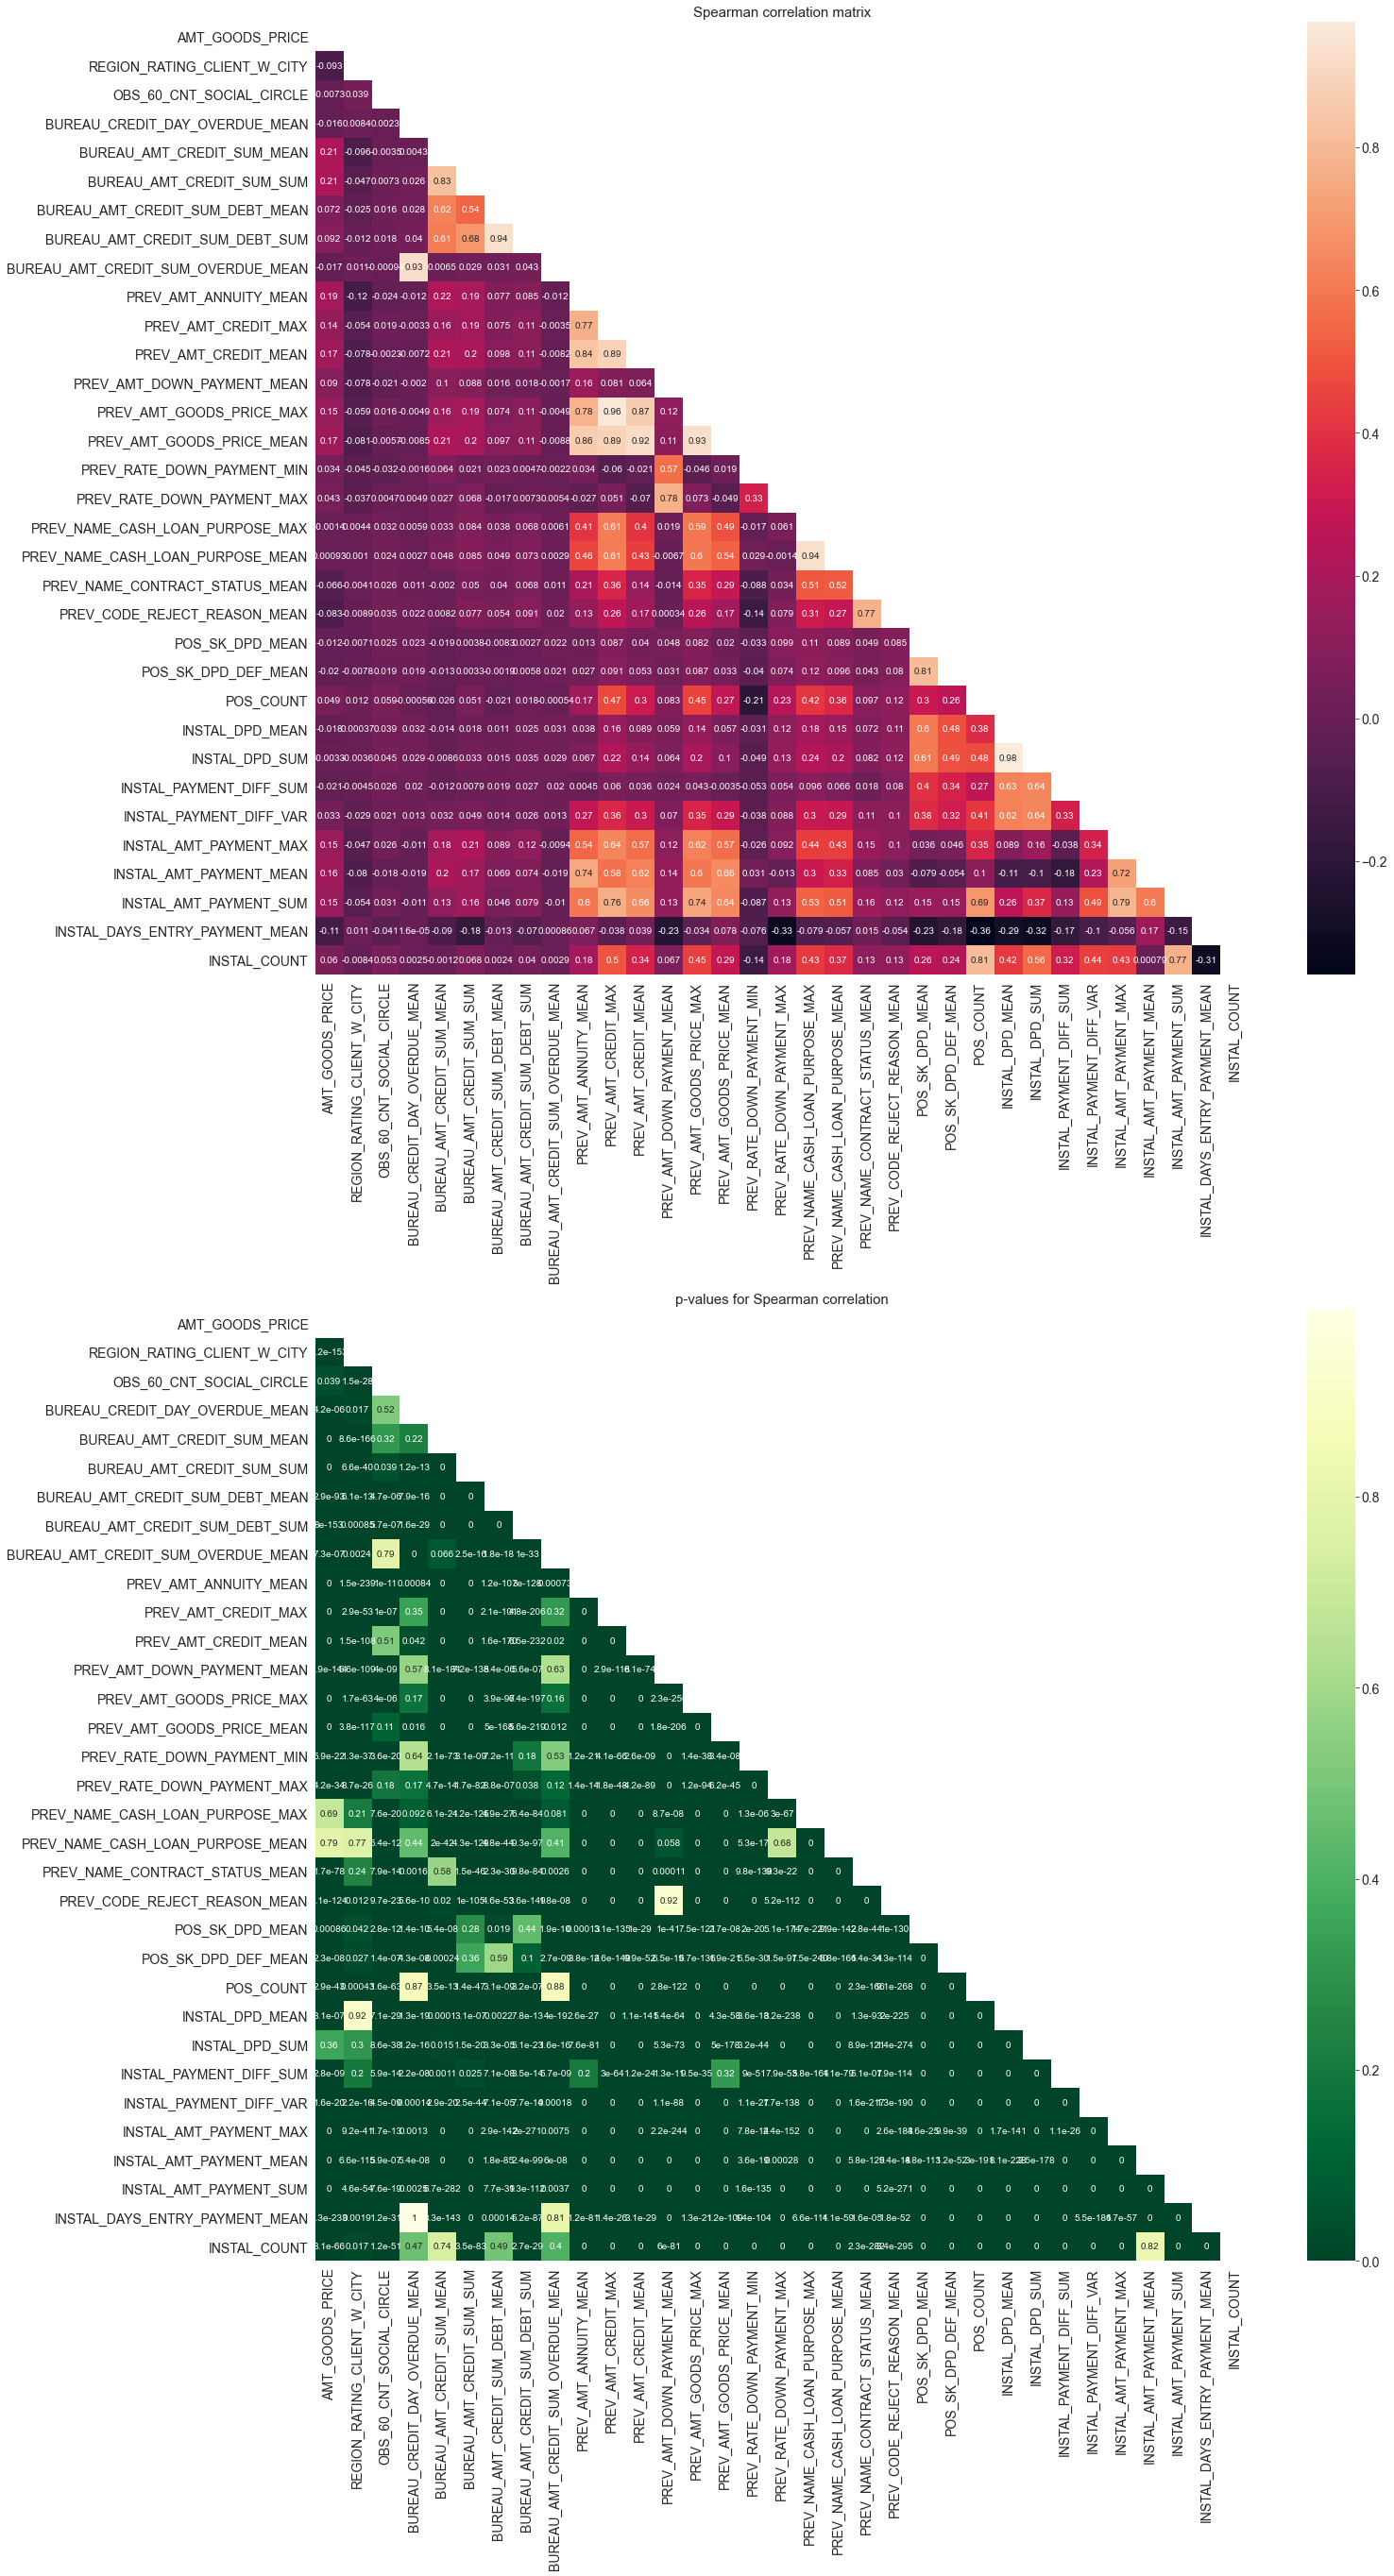

In [145]:
# Getting Spearman correlation on highly correlated variables only
spearman_correlation(data_train_cor[highly_correlated])

We will drop a good part of the correlated variables.

In [146]:
highly_correlated_to_drop = ["BUREAU_CREDIT_DAY_OVERDUE_MEAN",
                            "BUREAU_AMT_CREDIT_SUM_SUM",
                            "BUREAU_AMT_CREDIT_SUM_DEBT_SUM",
                            "PREV_AMT_CREDIT_MAX",
                            "PREV_AMT_CREDIT_MEAN",
                            "PREV_AMT_GOODS_PRICE_MAX",
                            "PREV_RATE_DOWN_PAYMENT_MIN",
                            "PREV_RATE_DOWN_PAYMENT_MAX",
                            "PREV_NAME_CASH_LOAN_PURPOSE_MAX",
                            "PREV_NAME_CONTRACT_STATUS_MEAN",
                            "POS_COUNT",
                            "INSTAL_COUNT",
                            "INSTAL_DPD_SUM",
                            "INSTAL_AMT_PAYMENT_MAX",
                            "INSTAL_AMT_PAYMENT_SUM",
                            "INSTAL_PAYMENT_DIFF_VAR",
                            "INSTAL_PAYMENT_DIFF_SUM",
                            "INSTAL_AMT_PAYMENT_MEAN",
                            "PREV_AMT_GOODS_PRICE_MEAN",
                            "BUREAU_AMT_CREDIT_SUM_MEAN",
                            "POS_SK_DPD_DEF_MEAN",
                            "INSTAL_DPD_MEAN"]

In [147]:
# Dropping correlated variables
data_train_cor.drop(highly_correlated_to_drop, axis=1, inplace=True)
new_highly_correlated = list(set(highly_correlated) - set(highly_correlated_to_drop))

Initial number of rows: 80725.
-----
Number of NaN values:
PREV_NAME_CASH_LOAN_PURPOSE_MEAN      0
AMT_GOODS_PRICE                       0
PREV_AMT_ANNUITY_MEAN                 0
PREV_AMT_DOWN_PAYMENT_MEAN            0
BUREAU_AMT_CREDIT_SUM_DEBT_MEAN       0
POS_SK_DPD_MEAN                       0
PREV_CODE_REJECT_REASON_MEAN          0
BUREAU_AMT_CREDIT_SUM_OVERDUE_MEAN    0
INSTAL_DAYS_ENTRY_PAYMENT_MEAN        0
OBS_60_CNT_SOCIAL_CIRCLE              0
REGION_RATING_CLIENT_W_CITY           0
dtype: int64.
-----
Removed 0 lines droping NaN.
Number of rows after droped NaN: 80725.


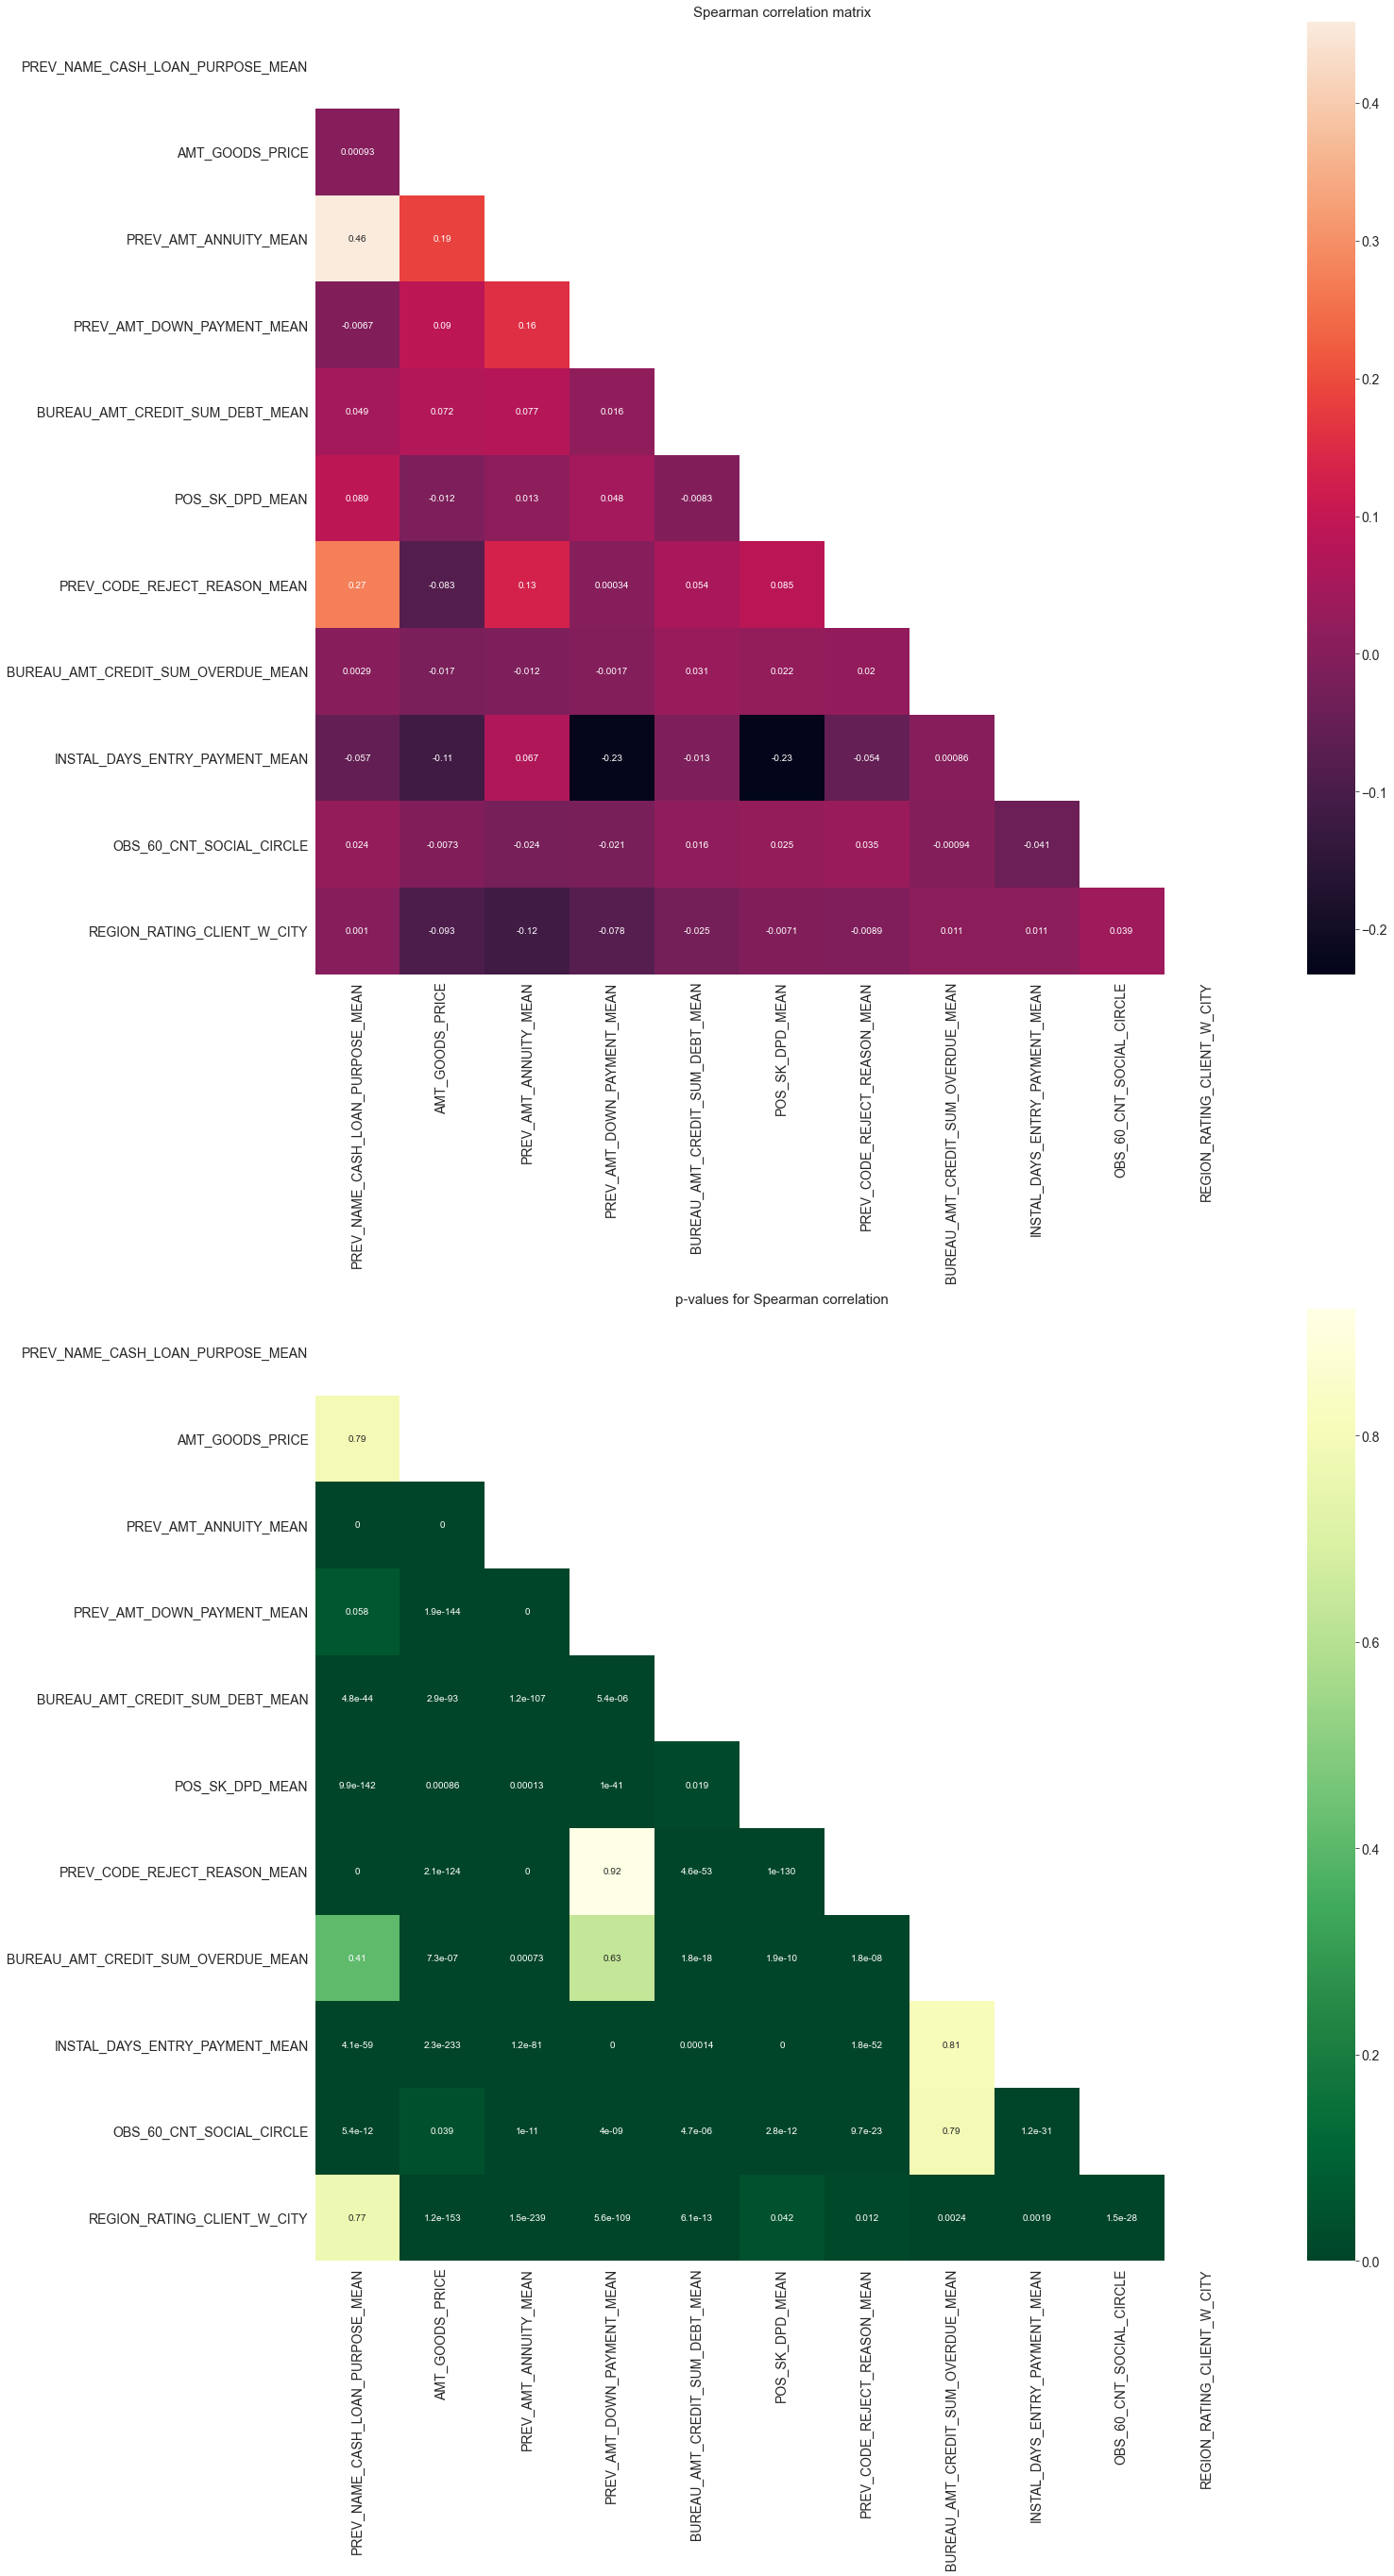

In [148]:
# Checking our remaining variables in the "highly correlated" group
spearman_correlation(data_train_cor[new_highly_correlated])

In [149]:
print(f"We have now {data_train_cor.shape[1]} numerical variables.")

We have now 126 numerical variables.


We make another run of variables selection on the moderately correlated variables.

In [150]:
highly_correlated, moderately_correlated, low_correlated = level_of_correlation(data_train_cor, 0.9, 0.7, 0.5)

There are 11 highly correlated variables, 47 moderately correlated, 40 low correlated.


Initial number of rows: 80725.
-----
Number of NaN values:
AMT_ANNUITY                          0
AMT_GOODS_PRICE                      0
CNT_FAM_MEMBERS                      0
LIVE_REGION_NOT_WORK_REGION          0
LIVE_CITY_NOT_WORK_CITY              0
DEF_60_CNT_SOCIAL_CIRCLE             0
INCOME_PER_PERSON                    0
BUREAU_DAYS_CREDIT_MEAN              0
BUREAU_DAYS_CREDIT_ENDDATE_MIN       0
BUREAU_DAYS_CREDIT_ENDDATE_MEAN      0
BUREAU_DAYS_CREDIT_UPDATE_MEAN       0
PREV_AMT_APPLICATION_MAX             0
PREV_AMT_APPLICATION_MEAN            0
PREV_AMT_CREDIT_MIN                  0
PREV_APP_CREDIT_PERC_MEAN            0
PREV_AMT_DOWN_PAYMENT_MAX            0
PREV_AMT_DOWN_PAYMENT_MEAN           0
PREV_AMT_GOODS_PRICE_MIN             0
PREV_HOUR_APPR_PROCESS_START_MEAN    0
PREV_RATE_DOWN_PAYMENT_MEAN          0
PREV_DAYS_DECISION_MEAN              0
PREV_CNT_PAYMENT_SUM                 0
PREV_NAME_CONTRACT_TYPE_MEAN         0
PREV_NAME_CASH_LOAN_PURPOSE_MEAN     0
PREV_

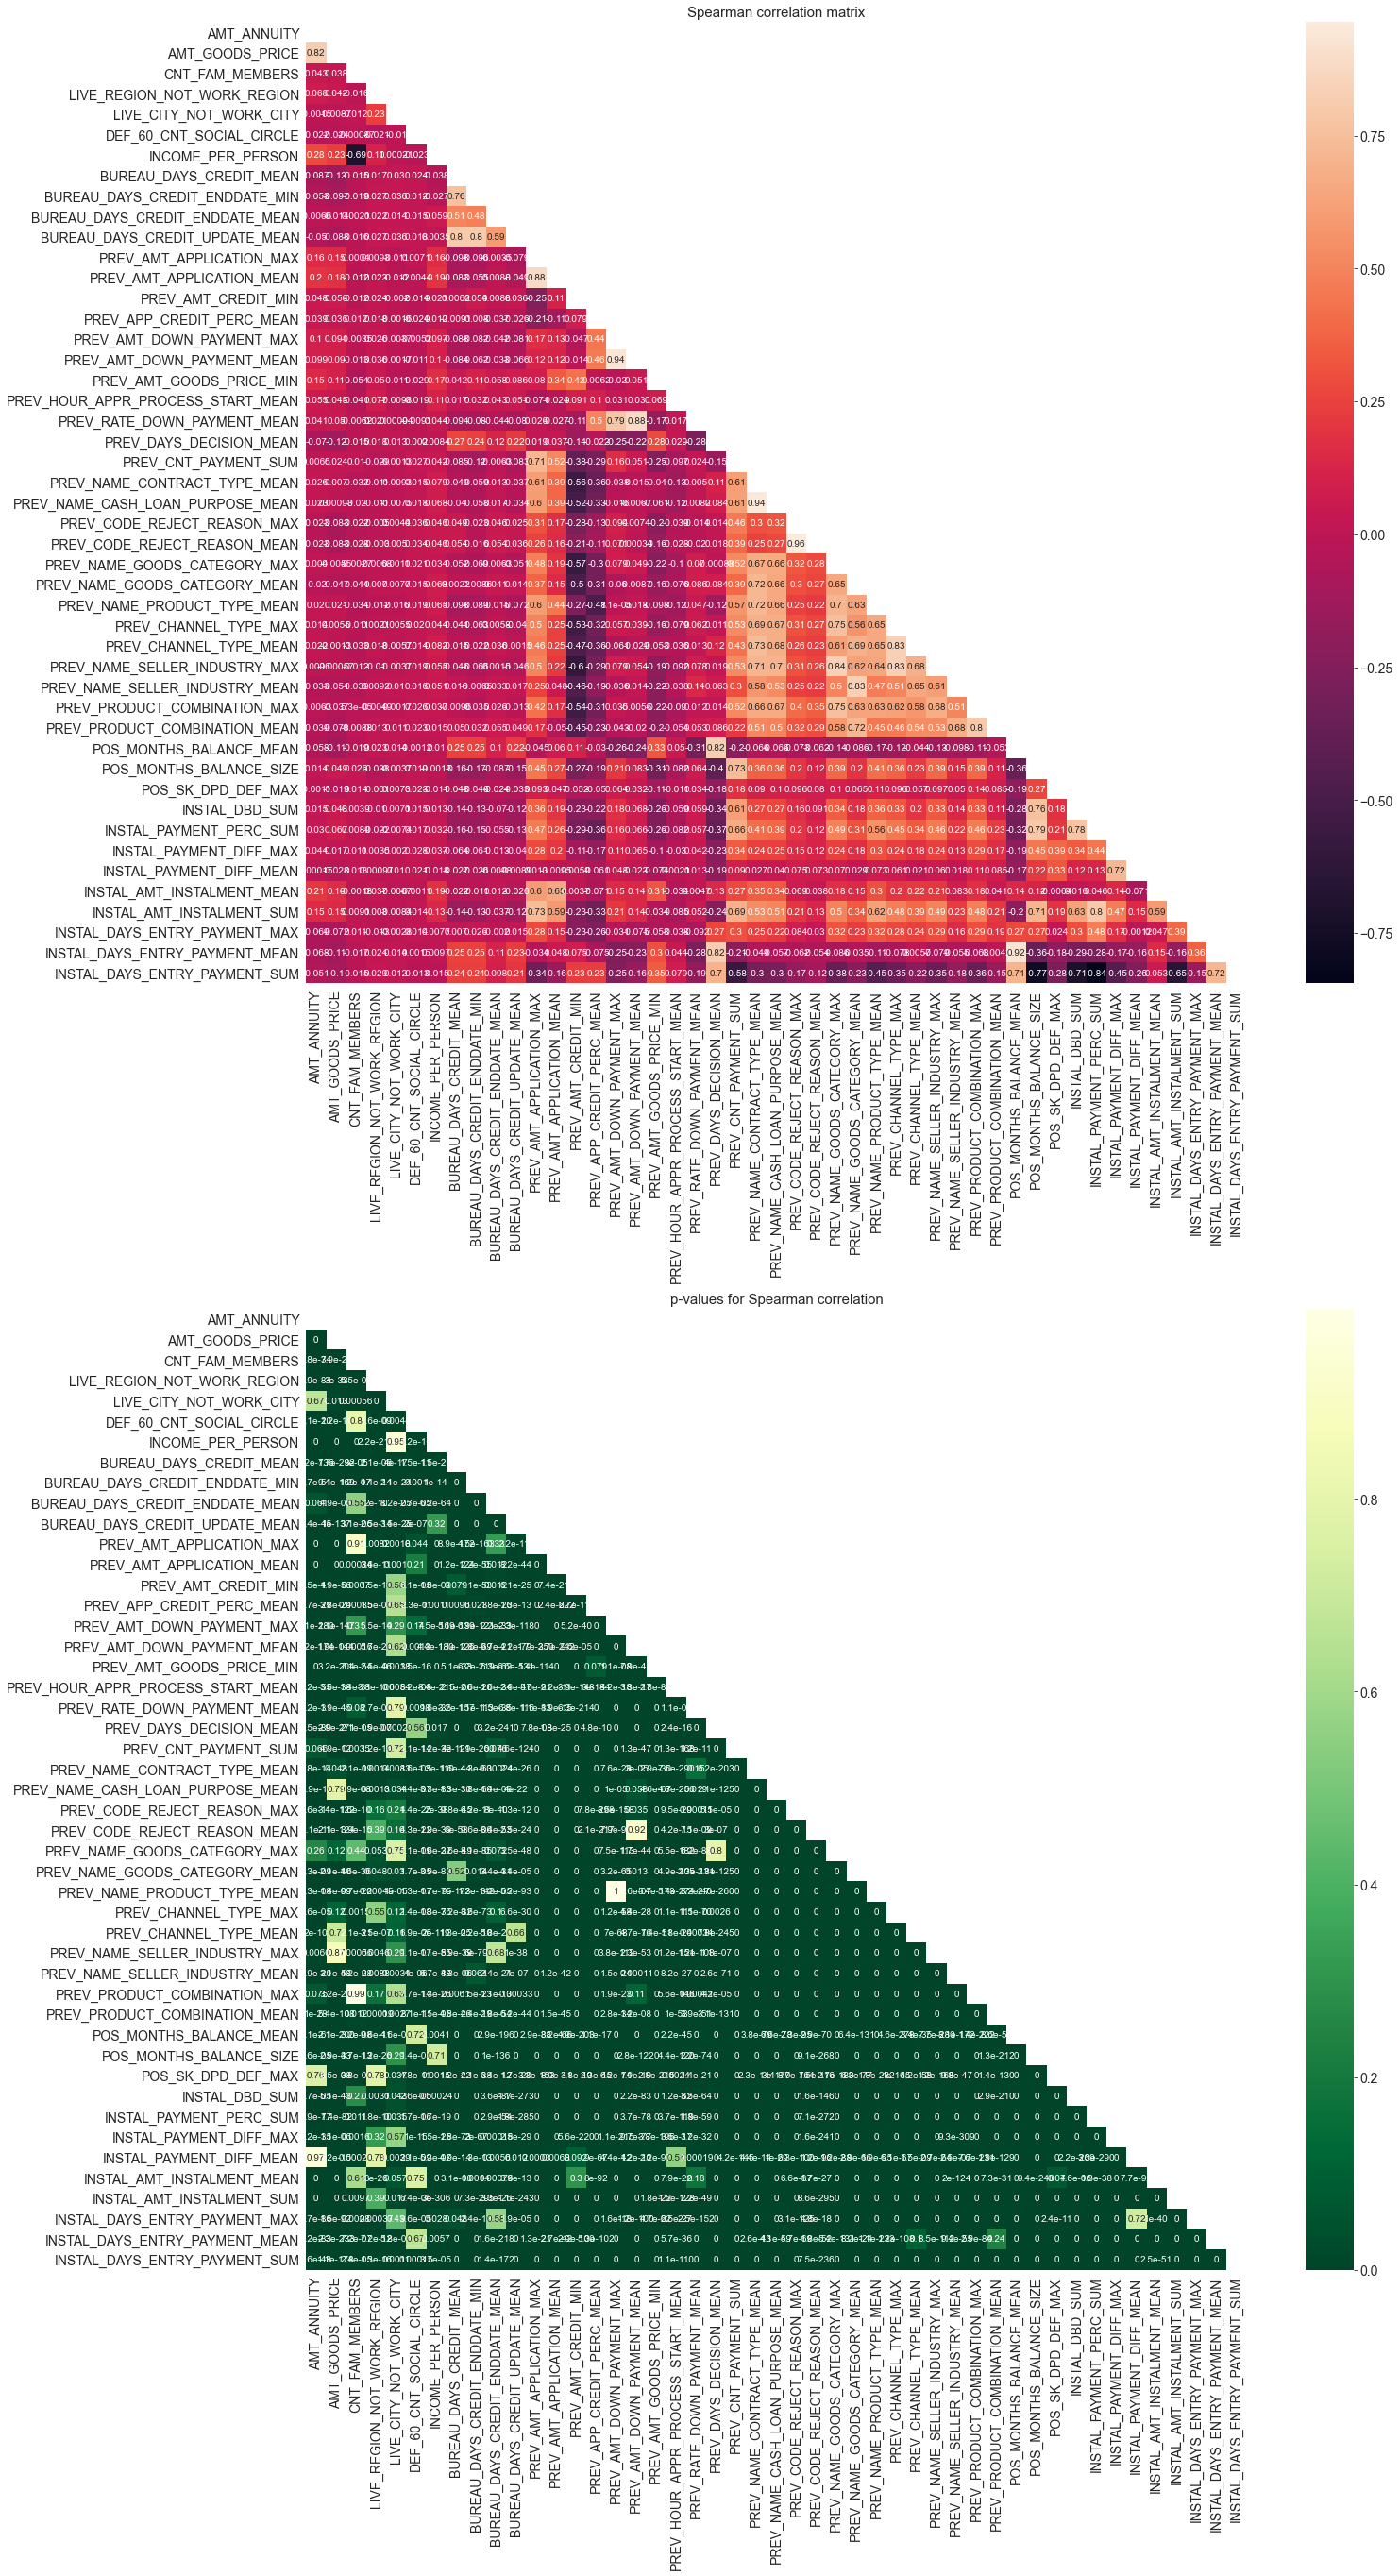

In [151]:
# Check "moderalety correlated" variables
spearman_correlation(data_train_cor[moderately_correlated])

In [152]:
# Dropping part of the moderately correlated variables
moderately_correlated_to_drop = ["PREV_AMT_APPLICATION_MAX",
                                "PREV_AMT_DOWN_PAYMENT_MAX",
                                "PREV_RATE_DOWN_PAYMENT_MEAN",
                                "PREV_DAYS_DECISION_MEAN",
                                "INSTAL_DAYS_ENTRY_PAYMENT_SUM",
                                "INSTAL_AMT_INSTALMENT_SUM",
                                "PREV_CODE_REJECT_REASON_MAX",
                                "PREV_NAME_GOODS_CATEGORY_MAX",
                                "PREV_CHANNEL_TYPE_MAX",
                                "PREV_NAME_SELLER_INDUSTRY_MAX",
                                "PREV_PRODUCT_COMBINATION_MAX",
                                "AMT_GOODS_PRICE",
                                "CNT_FAM_MEMBERS",
                                "POS_MONTHS_BALANCE_SIZE",
                                "PREV_NAME_CONTRACT_TYPE_MEAN",
                                "BUREAU_DAYS_CREDIT_ENDDATE_MIN",
                                "PREV_CHANNEL_TYPE_MEAN",
                                "INSTAL_PAYMENT_PERC_SUM",
                                "INSTAL_DAYS_ENTRY_PAYMENT_MEAN",
                                "PREV_NAME_SELLER_INDUSTRY_MEAN",
                                "BUREAU_DAYS_CREDIT_UPDATE_MEAN",
                                "PREV_NAME_PRODUCT_TYPE_MEAN",
                                "PREV_NAME_GOODS_CATEGORY_MEAN",
                                "PREV_CNT_PAYMENT_SUM",
                                "INSTAL_PAYMENT_DIFF_MAX",
                                "INSTAL_AMT_INSTALMENT_MEAN"]

In [153]:
# Dropping correlated variables
data_train_cor.drop(moderately_correlated_to_drop, axis=1, inplace=True)
new_moderately_correlated = list(set(moderately_correlated) - set(moderately_correlated_to_drop))

Initial number of rows: 80725.
-----
Number of NaN values:
PREV_PRODUCT_COMBINATION_MEAN        0
BUREAU_DAYS_CREDIT_ENDDATE_MEAN      0
INCOME_PER_PERSON                    0
INSTAL_DBD_SUM                       0
DEF_60_CNT_SOCIAL_CIRCLE             0
PREV_AMT_DOWN_PAYMENT_MEAN           0
POS_MONTHS_BALANCE_MEAN              0
PREV_CODE_REJECT_REASON_MEAN         0
PREV_AMT_APPLICATION_MEAN            0
PREV_AMT_GOODS_PRICE_MIN             0
POS_SK_DPD_DEF_MAX                   0
INSTAL_DAYS_ENTRY_PAYMENT_MAX        0
PREV_NAME_CASH_LOAN_PURPOSE_MEAN     0
PREV_HOUR_APPR_PROCESS_START_MEAN    0
LIVE_REGION_NOT_WORK_REGION          0
INSTAL_PAYMENT_DIFF_MEAN             0
PREV_APP_CREDIT_PERC_MEAN            0
PREV_AMT_CREDIT_MIN                  0
BUREAU_DAYS_CREDIT_MEAN              0
AMT_ANNUITY                          0
LIVE_CITY_NOT_WORK_CITY              0
dtype: int64.
-----
Removed 0 lines droping NaN.
Number of rows after droped NaN: 80725.


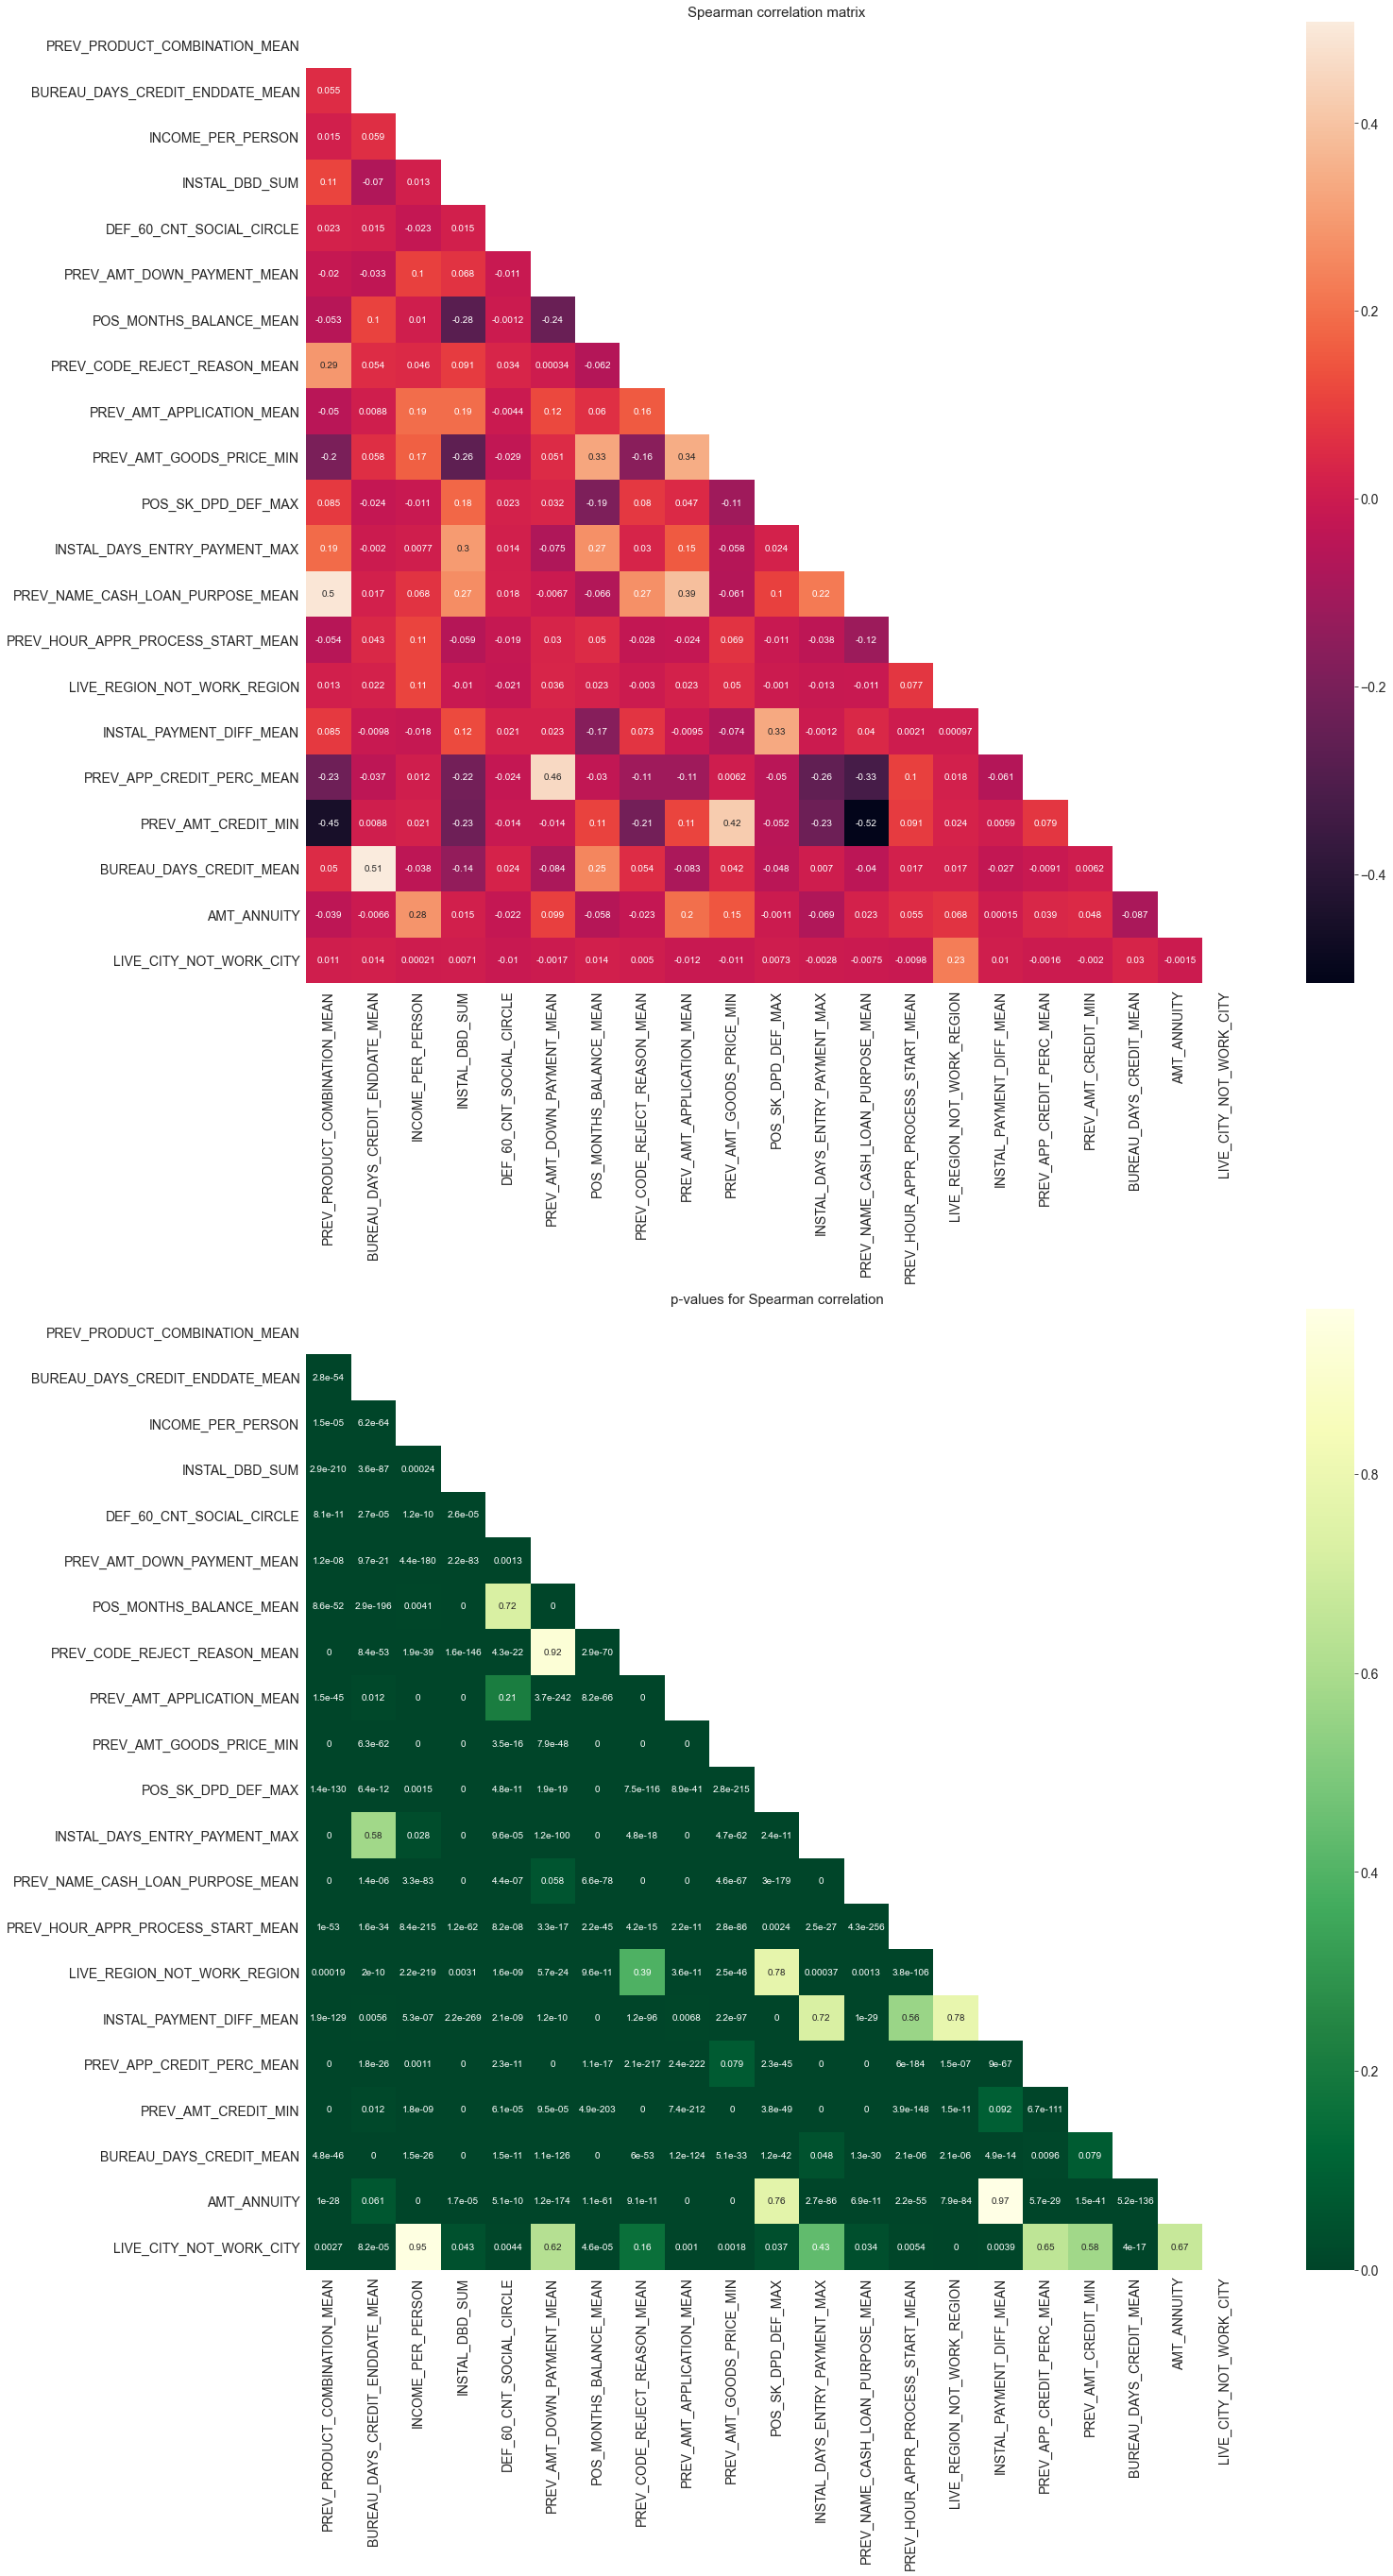

In [154]:
# Check "moderalety correlated" variables
spearman_correlation(data_train_cor[new_moderately_correlated])

Third and last run to clean the remaining correlated variables.

In [155]:
highly_correlated, moderately_correlated, low_correlated = level_of_correlation(data_train_cor, 0.9, 0.7, 0.5)

There are 6 highly correlated variables, 18 moderately correlated, 22 low correlated.


In [156]:
correlated = highly_correlated + moderately_correlated + low_correlated
correlated = list(set(correlated))

Initial number of rows: 80725.
-----
Number of NaN values:
PREV_PRODUCT_COMBINATION_MEAN         0
PREV_AMT_ANNUITY_MEAN                 0
BUREAU_DAYS_CREDIT_ENDDATE_MEAN       0
BUREAU_CREDIT_ACTIVE_SUM              0
BUREAU_CREDIT_ACTIVE_MEAN             0
INCOME_PER_PERSON                     0
PREV_NAME_CONTRACT_TYPE_MAX           0
INSTAL_DBD_SUM                        0
DEF_60_CNT_SOCIAL_CIRCLE              0
PREV_AMT_DOWN_PAYMENT_MEAN            0
POS_MONTHS_BALANCE_MEAN               0
PREV_CODE_REJECT_REASON_MEAN          0
PREV_AMT_APPLICATION_MEAN             0
BUREAU_CREDIT_TYPE_MAX                0
PREV_AMT_GOODS_PRICE_MIN              0
POS_SK_DPD_DEF_MAX                    0
INSTAL_DAYS_ENTRY_PAYMENT_MAX         0
PREV_NAME_CASH_LOAN_PURPOSE_MEAN      0
PAYMENT_RATE                          0
INSTAL_AMT_INSTALMENT_MAX             0
PREV_HOUR_APPR_PROCESS_START_MEAN     0
BUREAU_AMT_CREDIT_SUM_DEBT_MEAN       0
POS_SK_DPD_MEAN                       0
BUREAU_AMT_CREDIT_SUM

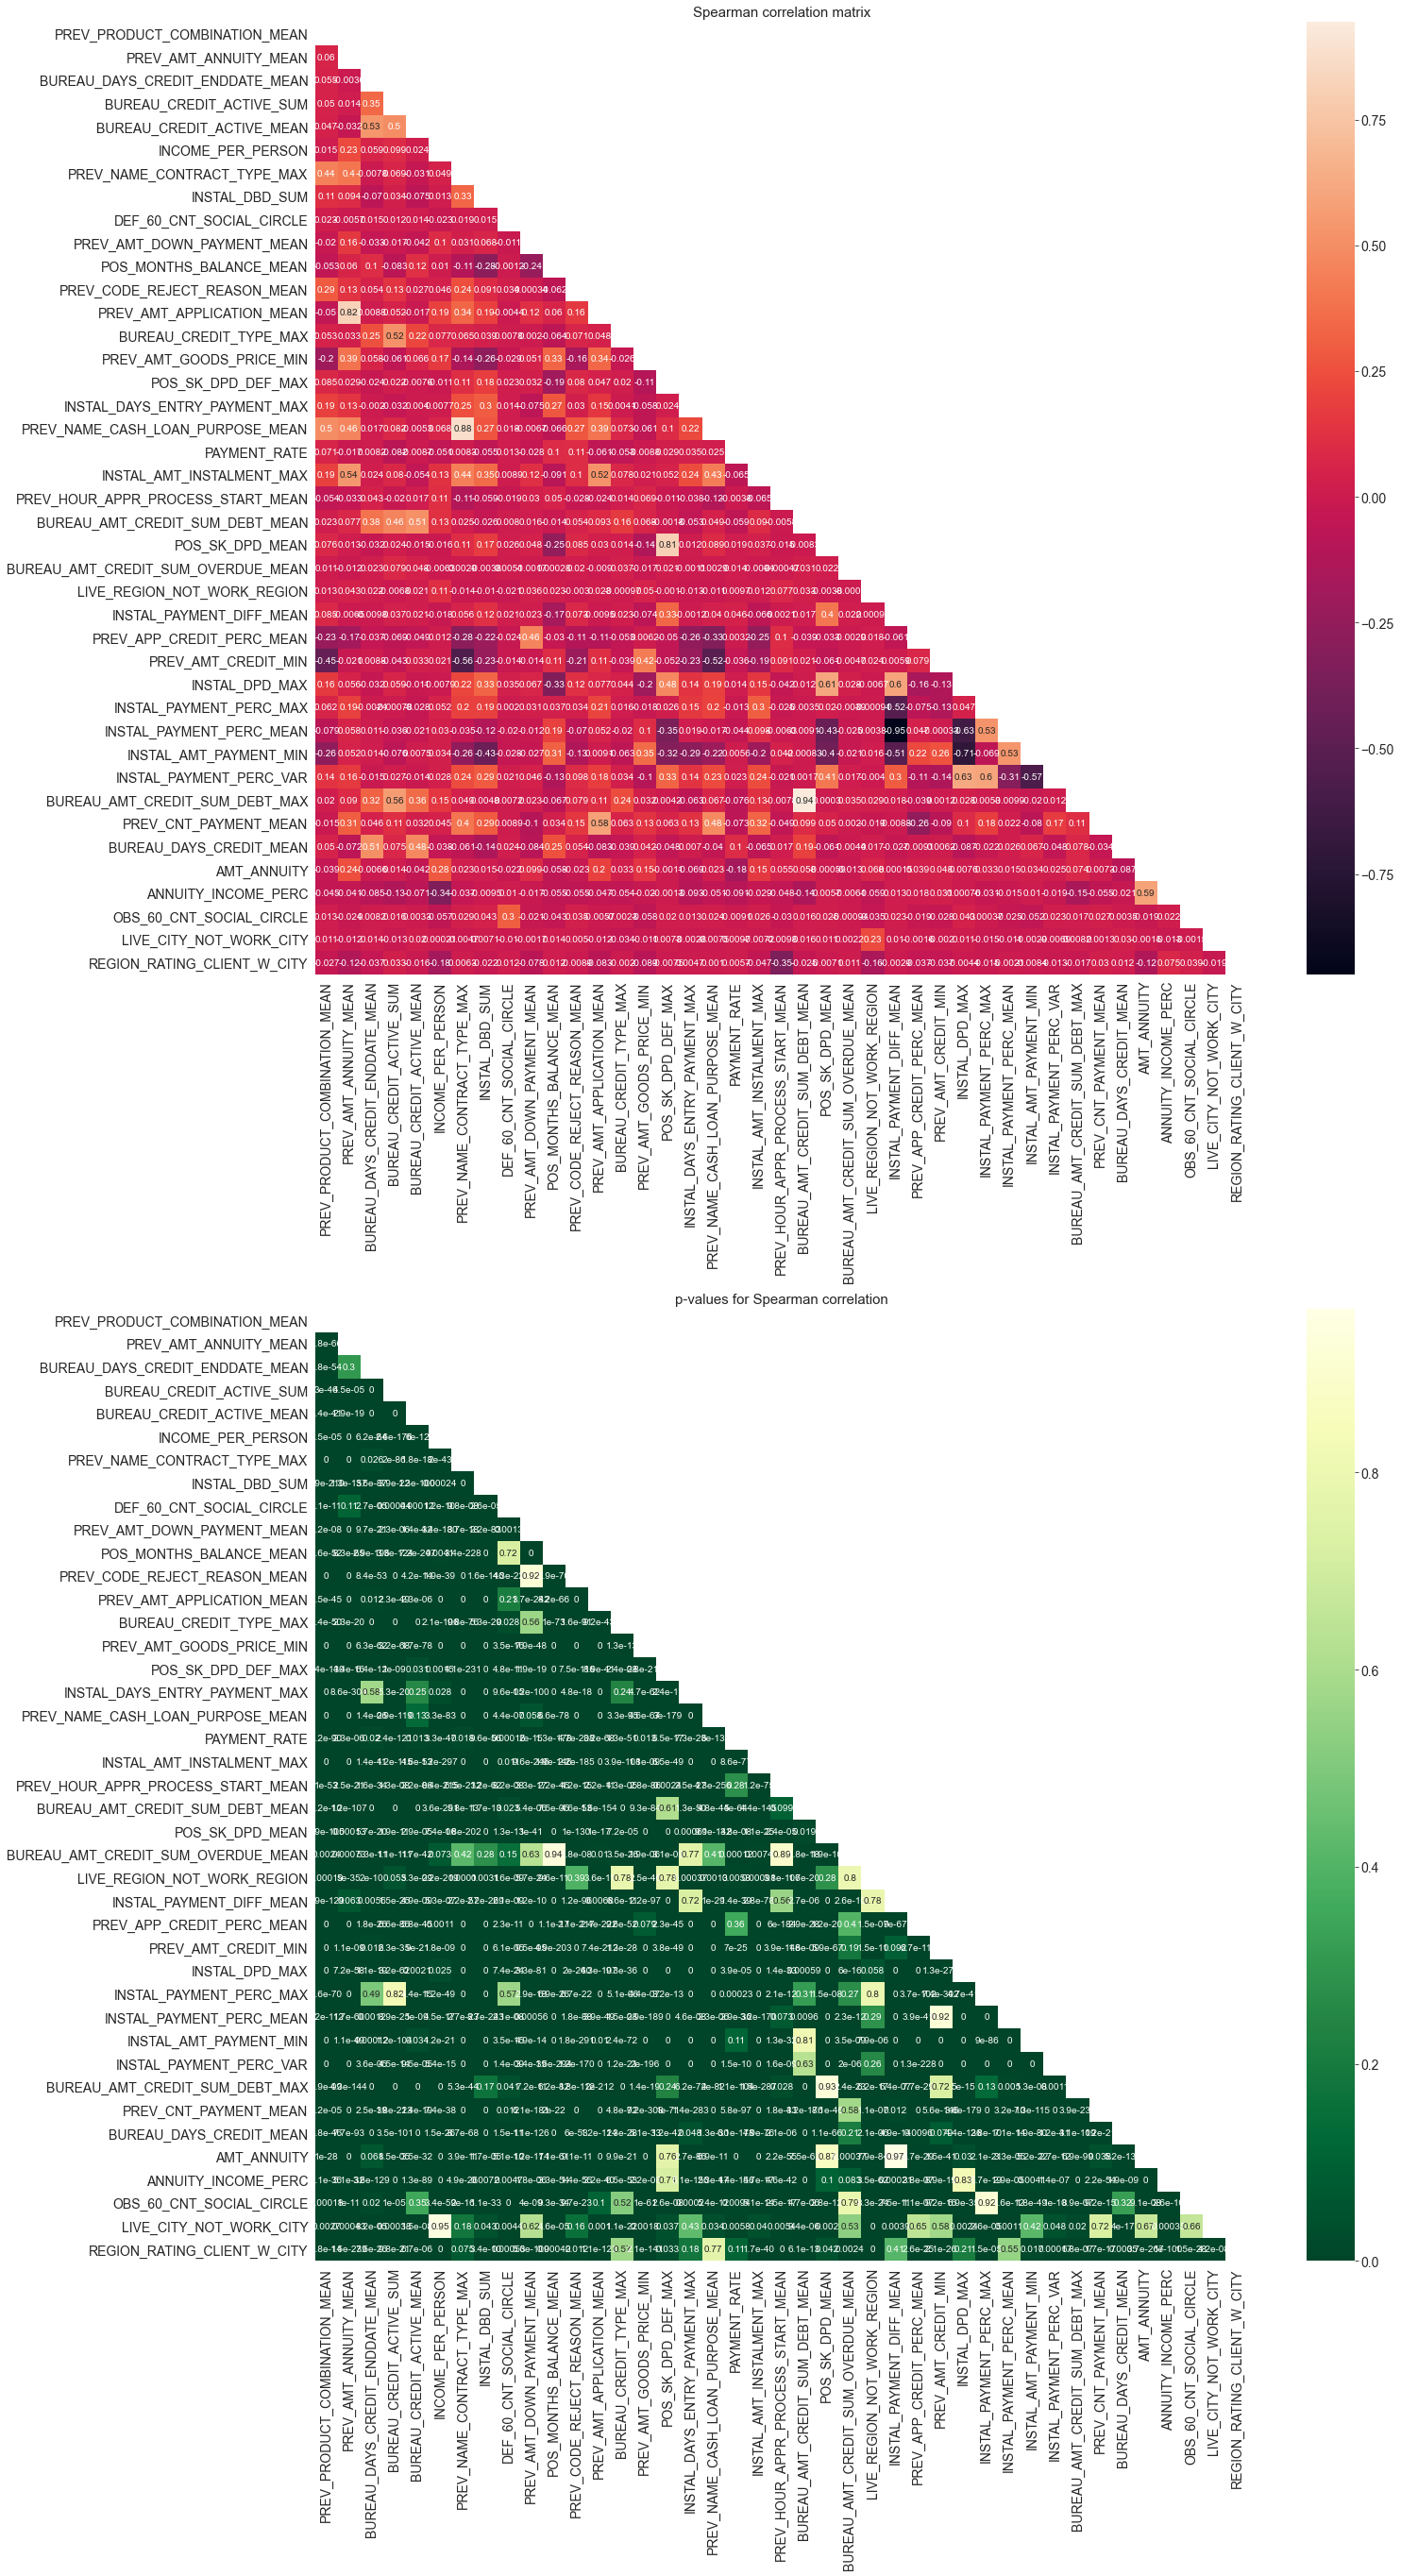

In [157]:
# Check "moderalety correlated" variables
spearman_correlation(data_train_cor[correlated])

In [158]:
correlated_to_drop = ["BUREAU_AMT_CREDIT_SUM_DEBT_MAX",
                    "PREV_AMT_APPLICATION_MEAN",
                    "PREV_NAME_CONTRACT_TYPE_MAX",
                    "INSTAL_DPD_MAX",
                    "POS_SK_DPD_MEAN",
                    "INSTAL_PAYMENT_PERC_MEAN",
                    "INSTAL_PAYMENT_PERC_VAR"]

In [159]:
# Dropping correlated variables
data_train_cor.drop(correlated_to_drop, axis=1, inplace=True)
new_correlated = list(set(correlated) - set(correlated_to_drop))

Initial number of rows: 80725.
-----
Number of NaN values:
PREV_PRODUCT_COMBINATION_MEAN         0
PREV_AMT_ANNUITY_MEAN                 0
BUREAU_CREDIT_ACTIVE_SUM              0
BUREAU_DAYS_CREDIT_ENDDATE_MEAN       0
BUREAU_CREDIT_ACTIVE_MEAN             0
INCOME_PER_PERSON                     0
INSTAL_DBD_SUM                        0
DEF_60_CNT_SOCIAL_CIRCLE              0
PREV_AMT_DOWN_PAYMENT_MEAN            0
POS_MONTHS_BALANCE_MEAN               0
PREV_CODE_REJECT_REASON_MEAN          0
BUREAU_CREDIT_TYPE_MAX                0
PREV_AMT_GOODS_PRICE_MIN              0
POS_SK_DPD_DEF_MAX                    0
INSTAL_DAYS_ENTRY_PAYMENT_MAX         0
PREV_NAME_CASH_LOAN_PURPOSE_MEAN      0
PAYMENT_RATE                          0
INSTAL_AMT_INSTALMENT_MAX             0
PREV_HOUR_APPR_PROCESS_START_MEAN     0
BUREAU_AMT_CREDIT_SUM_DEBT_MEAN       0
BUREAU_AMT_CREDIT_SUM_OVERDUE_MEAN    0
LIVE_REGION_NOT_WORK_REGION           0
INSTAL_PAYMENT_DIFF_MEAN              0
PREV_APP_CREDIT_PERC_

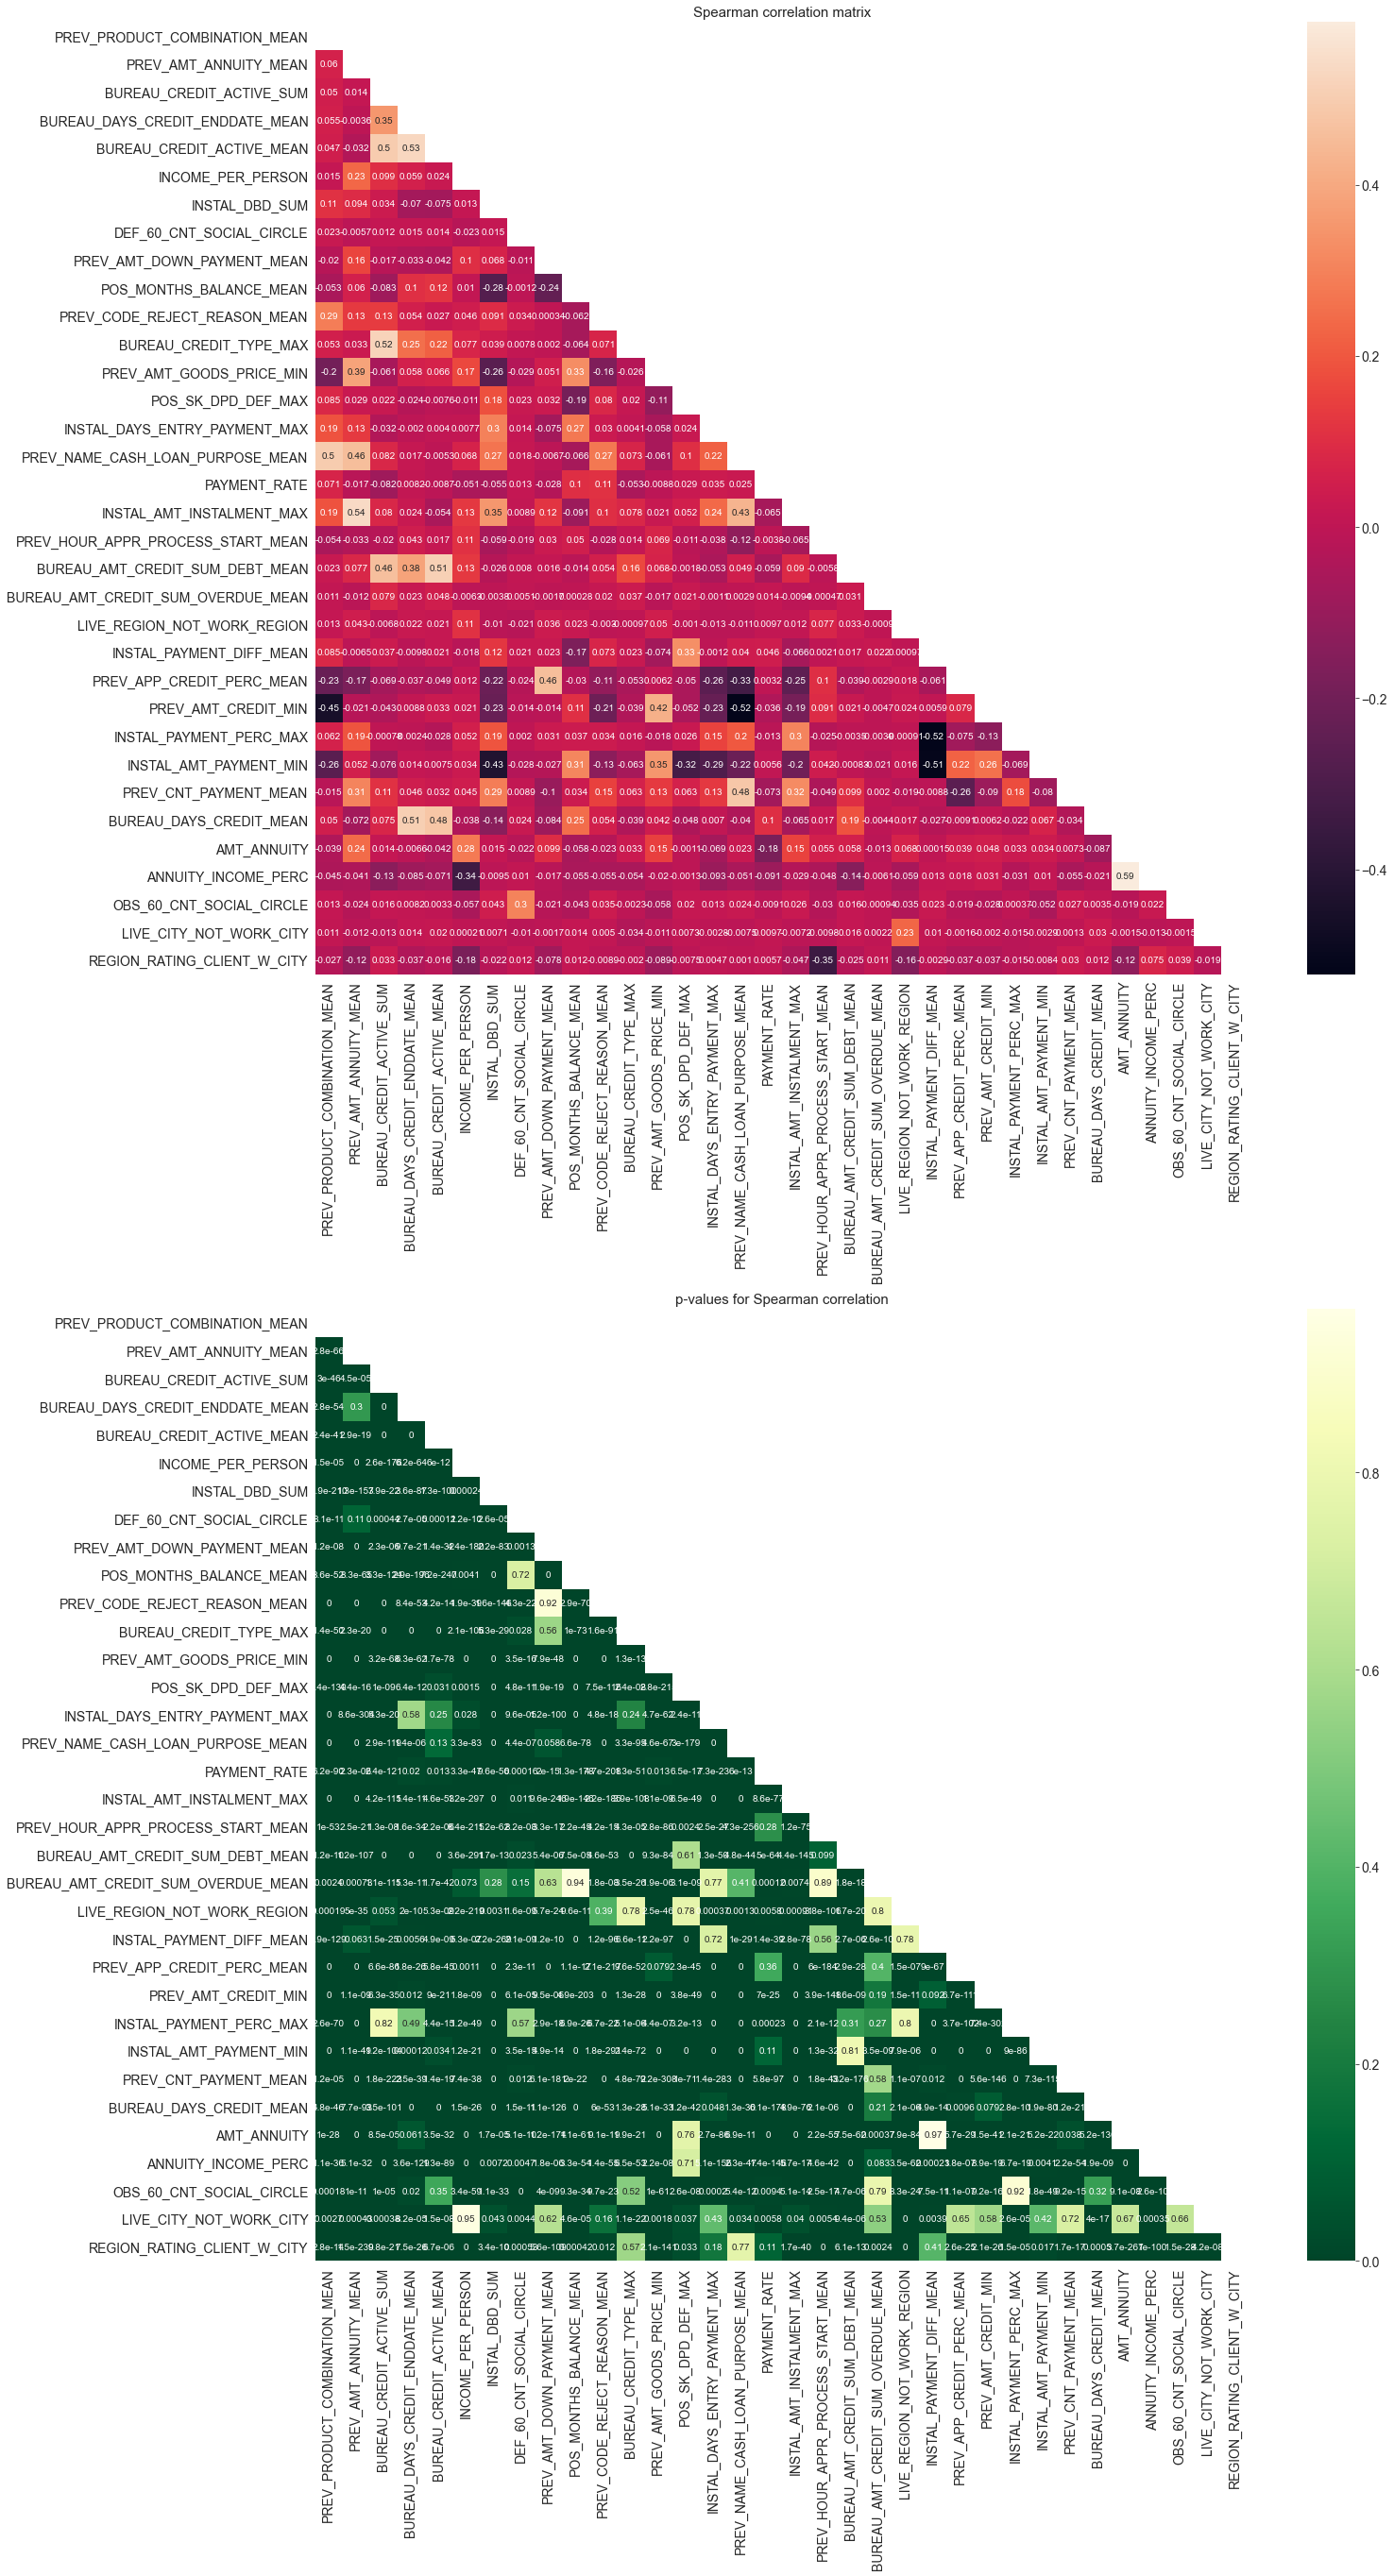

In [160]:
# Check last correlated variables
spearman_correlation(data_train_cor[new_correlated])

In [161]:
print(f"After cleaning correlated variables, we have {data_train_cor.shape[1]} numeric variables in our dataset.")

After cleaning correlated variables, we have 93 numeric variables in our dataset.


We cleaned most of correlated variables. We still have a few correlated variables with 0.5-0.6 correlation coefficient, but some may be important to determine default risk and have different signification. We will keep them.

## 10. PCA

We make a PCA to have insights into relationships between and see if it is worth using PCA axis as features in the modeling.

In [162]:
def cpa_custom(df, n_comp):
    """
    Drop NaN if any, scale data with Standard Scaler of scikit-learn and fit CPA.
    Return CPA object of scikit-learn and transformed data.
    """
    # Print info and drop NaN
    n_rows_initial = df.shape[0]
    print(f"Initial number of rows: {n_rows_initial}.\n-----")
    print(f"Number of NaN values:\n{df.isnull().sum()}.\n-----")
    df_clean=df.dropna()
    print(f"Removed {n_rows_initial - df_clean.shape[0]} lines droping NaN.")
    print(f"Number of rows after droped NaN: {df_clean.shape[0]}.")
    
    # Input data
    X = df_clean.values
    names = df_clean.index
    features = df_clean.columns
    
    # Scaling data
    std_scale = StandardScaler().fit(X)
    X_scaled = std_scale.transform(X)
    
    # Main axes calculation
    cpa = PCA(n_components=n_comp)
    cpa.fit(X_scaled)
    
    return cpa, X_scaled

In [163]:
acp, _ = cpa_custom(data_train_cor, 80)

Initial number of rows: 80725.
-----
Number of NaN values:
TARGET                                   0
CNT_CHILDREN                             0
AMT_INCOME_TOTAL                         0
AMT_CREDIT                               0
AMT_ANNUITY                              0
REGION_POPULATION_RELATIVE               0
DAYS_BIRTH                               0
DAYS_EMPLOYED                            0
DAYS_REGISTRATION                        0
DAYS_ID_PUBLISH                          0
REGION_RATING_CLIENT                     0
REGION_RATING_CLIENT_W_CITY              0
HOUR_APPR_PROCESS_START                  0
REG_REGION_NOT_LIVE_REGION               0
REG_REGION_NOT_WORK_REGION               0
LIVE_REGION_NOT_WORK_REGION              0
REG_CITY_NOT_LIVE_CITY                   0
REG_CITY_NOT_WORK_CITY                   0
LIVE_CITY_NOT_WORK_CITY                  0
EXT_SOURCE_1                             0
EXT_SOURCE_2                             0
EXT_SOURCE_3                          

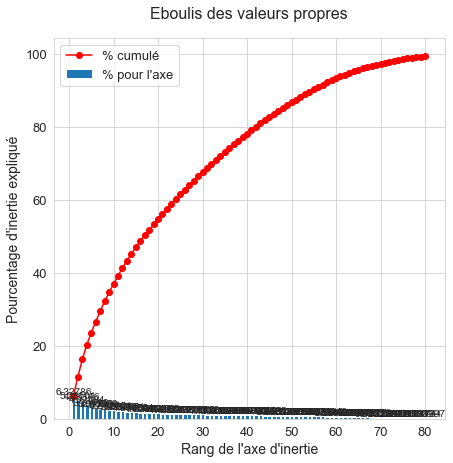

In [164]:
display_eigenvalues(acp, annotate=False)

In [165]:
print(f"The first main axis of PCA explains \
{round(np.cumsum(acp.explained_variance_ratio_ * 100)[0],2)} % of data variance.")
print(f"The first 4 main axis of PCA explain \
{round(np.cumsum(acp.explained_variance_ratio_ * 100)[3],2)} % of data variance.")
print(f"The first 6 main axis of PCA explain \
{round(np.cumsum(acp.explained_variance_ratio_ * 100)[5],2)} % of data variance.")

The first main axis of PCA explains 6.33 % of data variance.
The first 4 main axis of PCA explain 20.35 % of data variance.
The first 6 main axis of PCA explain 26.63 % of data variance.


We could get close to 95% of variance with about 70 PCA axis (out of 93 initial numeric variables). It would be interesting to reduce the number of features for modeling. However, we will loose a lot of explainability in the process. Since this model is to be used by insurers, it would be better to be able to relate decision making to real insurance-related variables (i.e. keeping a good explainability). The gain of 23 features is not enough to compensate for the need of this explainability.

## Final dataset

Now we concatenate with categorical and "flag" columns that we droped earlier for the correlation study.

In [166]:
cat_col = data_train_clean.select_dtypes(include="object")
flags_col = data_train_clean[to_remove]

In [167]:
# Concatenate all our features and putting back clients ID
data_train_clean_select = pd.concat([data_train_cor, cat_col], axis=1)
data_train_clean_select = pd.concat([data_train_clean_select, flags_col], axis=1)
#data_train_clean_select = pd.concat([data_train_clean_select, SK_ID_CURR], axis=1)

In [168]:
# One categorical variable with low impact on credit default, we drop it
data_train_clean_select.drop("NAME_TYPE_SUITE", axis=1, inplace=True)

In [169]:
data_train_clean_select

TARGET  CNT_CHILDREN  AMT_INCOME_TOTAL   AMT_CREDIT  AMT_ANNUITY  \
0           1             0       202500.0000  406597.5000   24700.5000   
1           0             1       171000.0000 1560726.0000   41301.0000   
2           0             1       112500.0000  652500.0000   21177.0000   
3           0             0        67500.0000   80865.0000    5881.5000   
4           0             0       157500.0000  299772.0000   20160.0000   
...       ...           ...               ...          ...          ...   
80720       0             0       180000.0000  270126.0000   12028.5000   
80721       0             0        81000.0000  225000.0000   12694.5000   
80722       0             0       261000.0000 1303812.0000   35982.0000   
80723       0             0       112500.0000  345510.0000   17770.5000   
80724       0             0       157500.0000  675000.0000   49117.5000   

       REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
0                          0.0188       -9461      -637.0000   
1                          0.0358      -13778     -3130.0000   
2                          0.0228      -10197      -679.0000   
3                          0.0313      -13439     -2717.0000   
4                          0.0207       -8728     -1157.0000   
...                           ...         ...            ...   
80720                      0.0070      -16679     -1222.0000   
80721                      0.0070      -16988     -8694.0000   
80722                      0.0313      -20390     -5326.0000   
80723                      0.0228      -11870      -399.0000   
80724                      0.0462      -16856     -1262.0000   

       DAYS_REGISTRATION  DAYS_ID_PUBLISH  REGION_RATING_CLIENT  \
0             -3648.0000            -2120                     2   
1             -1213.0000             -619                     2   
2             -4427.0000             -738                     2   
3              -311.0000            -3227                     2   
4             -3494.0000            -1368                     3   
...                  ...              ...                   ...   
80720         -1916.0000             -222                     2   
80721         -5396.0000             -509                     2   
80722          -157.0000            -3906                     2   
80723          -675.0000            -3936                     2   
80724         -5128.0000             -410                     1   

       REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
0                                2                       10   
1                                2                       16   
2                                2                       15   
3                                2                       10   
4                                3                        6   
...                            ...                      ...   
80720                            2                       13   
80721                            2                       15   
80722                            2                       10   
80723                            2                       11   
80724                            1                       20   

       REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                               0                           0   
1                               0                           0   
2                               0                           0   
3                               0                           0   
4                               0                           0   
...                           ...                         ...   
80720                           0                           0   
80721                           0                           0   
80722                           0                           0   
80723                           0                           0   
80724                           0                           

## Export data for modelling

We have:
- `data_train_clean`: cleaned dataset (no `NaN`) with 187 variables (all variables from aggregation)
- `data_train_clean_select`: cleaned dataset (no `NaN`) with 131 variables, from which we dropped strongly correlated variables

We will use the later for export and modeling. We also need `app_prev_train` to set-up cost function for modeling.

In [170]:
data_train_clean_select.head()

TARGET  CNT_CHILDREN  AMT_INCOME_TOTAL   AMT_CREDIT  AMT_ANNUITY  \
0       1             0       202500.0000  406597.5000   24700.5000   
1       0             1       171000.0000 1560726.0000   41301.0000   
2       0             1       112500.0000  652500.0000   21177.0000   
3       0             0        67500.0000   80865.0000    5881.5000   
4       0             0       157500.0000  299772.0000   20160.0000   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                      0.0188       -9461      -637.0000         -3648.0000   
1                      0.0358      -13778     -3130.0000         -1213.0000   
2                      0.0228      -10197      -679.0000         -4427.0000   
3                      0.0313      -13439     -2717.0000          -311.0000   
4                      0.0207       -8728     -1157.0000         -3494.0000   

   DAYS_ID_PUBLISH  REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0            -2120                     2                            2   
1             -619                     2                            2   
2             -738                     2                            2   
3            -3227                     2                            2   
4            -1368                     3                            3   

   HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
0                       10                           0   
1                       16                           0   
2                       15                           0   
3                       10                           0   
4                        6                           0   

   REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
0                           0                            0   
1                           0                            0   
2                           0                            0   
3                           0                            0   
4                           0                            0   

   REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  \
0                       0                       0                        0   
1                       0                       0                        0   
2                       0                       0                        0   
3                       0                       0                        0   
4                       1                       1                        0   

   EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  OBS_30_CNT_SOCIAL_CIRCLE  \
0        0.0830        0.2629        0.1394                    2.0000   
1        0.7748        0.7240        0.4921                    1.0000   
2        0.3198        0.6519        0.3639                    0.0000   
3        0.4648        0.7150        0.1767                    0.0000   
4        0.1156        0.3466        0.6786                    0.0000   

   DEF_30_CNT_SOCIAL_CIRCLE  OBS_60_CNT_SOCIAL_CIRCLE  \
0                    2.0000                    2.0000   
1                    0.0000                    1.0000   
2                    0.0000                    0.0000   
3                    0.0000                    0.0000   
4                    0.0000                    0.0000   

   DEF_60_CNT_SOCIAL_CIRCLE  DAYS_LAST_PHONE_CHANGE  \
0                    2.0000              -1134.0000   
1                    0.0000              -1562.0000   
2                    0.0000               -844.0000   
3                    0.0000              -2370.0000   
4                    0.0000               -925.0000   

   AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
0                      0.0000                     0.0000   
1                      0.0000                     0.0000   
2                      0.0000                     0.0000   
3                      0.0000                     0.0000   
4                      0.0000                     0.0000  

In [171]:
print(f"Our final dataset has {data_train_clean_select.shape[0]} rows and {data_train_clean_select.shape[1]} columns.")

Our final dataset has 80725 rows and 131 columns.


In [172]:
path_train_clean_select = os.path.join(path_to_csv, "data_train_clean_select.csv")
data_train_clean_select.to_csv(path_train_clean_select)

In [173]:
path_app_prev_train = os.path.join(path_to_csv, "app_prev_train.csv")
app_prev_train.to_csv(path_app_prev_train)

## Export data for dashboard

We will export the full cleaned clients dataframe and the raw data of 2 clients under excel format to test the dashboard/API later on.

In [174]:
app_train.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL   AMT_CREDIT  AMT_ANNUITY  \
0               Y             0       202500.0000  406597.5000   24700.5000   
1               N             0       270000.0000 1293502.5000   35698.5000   
2               Y             0        67500.0000  135000.0000    6750.0000   
3               Y             0       135000.0000  312682.5000   29686.5000   
4               Y             0       121500.0000  513000.0000   21865.5000   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0      351000.0000   Unaccompanied          Working   
1     1129500.0000          Family    State servant   
2      135000.0000   Unaccompanied          Working   
3      297000.0000   Unaccompanied          Working   
4      513000.0000   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                      0.0188       -9461           -637         -3648.0000   
1                      0.0035      -16765          -1188         -1186.0000   
2                      0.0100      -19046           -225         -4260.0000   
3                      0.0080      -19005          -3039         -9833.0000   
4                      0.0287      -19932          -3038         -4311.0000   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531      26.0000           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers           1.0000   
1                 1           1           0      Core staff           2.0000   
2                 1           1           0        Laborers           1.0000   
3                 1           0           0        Laborers           2.0000   
4                 1           0           0      Core staff           1.0000   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                  

In [175]:
# Export clients dataframe in two parts
data_train_clean_select.drop("TARGET", axis=1, inplace=True)

with open("pkl/all_data_clients.pickle", "wb") as pickle_out:
  pickle.dump(all_clients_data, pickle_out)

In [176]:
client_100002_application = app_train.loc[0, :]
client_100002_bureau = bureau[bureau["SK_ID_CURR"]==100002]
client_100002_previous_app = previous_app[previous_app["SK_ID_CURR"]==100002]
client_100002_installments = installments[installments["SK_ID_CURR"]==100002]
client_100002_pos_cash = pos_cash[pos_cash["SK_ID_CURR"]==100002]

In [177]:
# Check the bureau ID for our client
bureau[bureau["SK_ID_CURR"]==100002]["SK_ID_BUREAU"]

675684     6158904
675685     6158905
675686     6158906
675687     6158907
675688     6158908
675689     6158909
1337779    6158903
1486113    6113835
Name: SK_ID_BUREAU, dtype: int64

In [178]:
client_100002_bureau_balance = bureau_bal[(bureau_bal["SK_ID_BUREAU"]==6158904) | (bureau_bal["SK_ID_BUREAU"]==6158905) | 
                                        (bureau_bal["SK_ID_BUREAU"]==6158906) | (bureau_bal["SK_ID_BUREAU"]==6158907) |
                                        (bureau_bal["SK_ID_BUREAU"]==6158908) | (bureau_bal["SK_ID_BUREAU"]==6158909) |
                                        (bureau_bal["SK_ID_BUREAU"]==6158903) | (bureau_bal["SK_ID_BUREAU"]==6113835)]


In [179]:
path_100002_application = os.path.join(path_to_csv, "client_100002_application.csv")
path_100002_bureau = os.path.join(path_to_csv, "client_100002_bureau.csv")
path_100002_previous_app = os.path.join(path_to_csv, "client_100002_previous_app.csv")
path_100002_installments = os.path.join(path_to_csv, "client_100002_installments.csv")
path_100002_pos_cash = os.path.join(path_to_csv, "client_100002_pos_cash.csv")
path_100002_bureau_balance = os.path.join(path_to_csv, "client_100002_bureau_balance.csv")

In [180]:
# Convert to csv
client_100002_application.to_csv(path_100002_application)
client_100002_bureau.to_csv(path_100002_bureau)
client_100002_previous_app.to_csv(path_100002_previous_app)
client_100002_installments.to_csv(path_100002_installments)
client_100002_pos_cash.to_csv(path_100002_pos_cash)
client_100002_bureau_balance.to_csv(path_100002_bureau_balance)

Same for a second client.

In [181]:
app_train[app_train["SK_ID_CURR"]==380361]

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
242164      380361       0         Cash loans           F            Y   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
242164               Y             0       315000.0000 450000.0000   

        AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
242164   11871.0000      450000.0000   Unaccompanied    State servant   

                  NAME_EDUCATION_TYPE NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
242164  Secondary / secondary special     Civil marriage  House / apartment   

        REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
242164                      0.0326      -21077          -7738   

        DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
242164         -4280.0000            -4637       7.0000           1   

        FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
242164               1                0                 1           1   

        FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
242164           0         Drivers           2.0000                     1   

        REGION_RATING_CLIENT_W_CITY WEEKDAY_APPR_PROCESS_START  \
242164                            1                     MONDAY   

        HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
242164                       12                           0   

        REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
242164                           0                            0   

        REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  \
242164                       0                       0   

        LIVE_CITY_NOT_WORK_CITY ORGANIZATION_TYPE  EXT_SOURCE_1  EXT_SOURCE_2  \
242164                        0       Electricity        0.8546        0.6397   

        EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
242164        0.3774             NaN               NaN   

        YEARS_BEGINEXPLUATATION_AVG  YEARS_BUILD_AVG  COMMONAREA_AVG  \
242164                          NaN              NaN             NaN   

        ELEVATORS_AVG  ENTRANCES_AVG  FLOORSMAX_AVG  FLOORSMIN_AVG  \
242164            NaN            NaN            NaN            NaN   

        LANDAREA_AVG  LIVINGAPARTMENTS_AVG  LIVINGAREA_AVG  \
242164           NaN                   NaN             NaN   

        NONLIVINGAPARTMENTS_AVG  NONLIVINGAREA_AVG  APARTMENTS_MODE  \
242164                      NaN                NaN              NaN   

        BASEMENTAREA_MODE  YEARS_BEGINEXPLUATATION_MODE  YEARS_BUILD_MODE  \
242164                NaN                           NaN               NaN   

        COMMONAREA_MODE  ELEVATORS_MODE  ENTRANCES_MODE  FLOORSMAX_MODE  \
242164              NaN             NaN             NaN             NaN   

        FLOORSMIN_MODE  LANDAREA_MODE  LIVINGAPARTMENTS_MODE  LIVINGAREA_MODE  \
242164             NaN            NaN                    NaN              NaN   

        NONLIVINGAPARTMENTS_MODE  NONLIVINGAREA_MODE  APARTMENTS_MEDI  \
242164                       NaN                 NaN              NaN   

        BASEMENTAREA_MEDI  YEARS_BEGINEXPLUATATION_MEDI  YEARS_BUILD_MEDI  \
242164                NaN                           NaN               NaN   

        COMMONAREA_MEDI  ELEVATORS_MEDI  ENTRANCES_MEDI  FLOORSMAX_MEDI  \
242164              NaN             NaN             NaN             NaN   

        FLOORSMIN_MEDI  LANDAREA_MEDI  LIVINGAPARTMENTS_MEDI  LIVINGAREA_MEDI  \
242164             NaN            NaN                    NaN              NaN   

        NONLIVINGAPARTMENTS_MEDI  NONLIVINGAREA_MEDI FONDKAPREMONT_MODE  \
242164                       NaN                 NaN                NaN   

       HOUSETYPE_MODE  TOTALAREA_MODE WALLSMATERIAL_MODE EMERGENCYSTATE_MODE  \
242164            NaN             NaN                NaN                 NaN   

        OBS_30_CNT_SOCIAL_CIRCLE  DEF_30_CNT_SOCIAL_CIRCLE  \
242164                    0.000

In [182]:
client_380361_application = app_train.loc[242164, :]
client_380361_bureau = bureau[bureau["SK_ID_CURR"]==380361]
client_380361_previous_app = previous_app[previous_app["SK_ID_CURR"]==380361]
client_380361_installments = installments[installments["SK_ID_CURR"]==380361]
client_380361_pos_cash = pos_cash[pos_cash["SK_ID_CURR"]==380361]

In [183]:
# Check the bureau ID for our client
bureau[bureau["SK_ID_CURR"]==380361]

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
768          380361       5715448        Active      currency 1         -820   
769          380361       5715449        Active      currency 1         -357   
770          380361       5715451        Closed      currency 1         -917   
771          380361       5715452        Closed      currency 1         -993   
772          380361       5715453        Closed      currency 1        -1146   
773          380361       5715454        Closed      currency 1        -1622   
774          380361       5715455        Closed      currency 1        -2631   
775          380361       5715456        Closed      currency 1        -1449   
776          380361       5715457        Active      currency 1         -222   
777          380361       5715458        Closed      currency 1         -749   
778          380361       5715459        Active      currency 1         -629   
779          380361       5715460        Active      currency 1         -233   
780          380361       5715461        Active      currency 1         -112   
384156       380361       5180513        Closed      currency 1        -1146   
1672450      380361       5715447        Closed      currency 1         -537   
1672451      380361       5715450        Closed      currency 1         -427   
1672452      380361       5715462        Active      currency 1         -840   

         CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
768                       0           31069.0000                NaN   
769                       0            1119.0000                NaN   
770                       0            -187.0000          -759.0000   
771                       0           31039.0000          -831.0000   
772                       0             681.0000          -780.0000   
773                       0           -1074.0000         -1073.0000   
774                       0            -804.0000         -1096.0000   
775                       0           -1084.0000         -1267.0000   
776                       0             874.0000                NaN   
777                       0            -111.0000          -110.0000   
778                       0           31069.0000                NaN   
779                       0             498.0000                NaN   
780                       0            2445.0000                NaN   
384156                    0             743.0000          -539.0000   
1672450                   0            -356.0000          -356.0000   
1672451                   0             669.0000          -118.0000   
1672452                   0            1716.0000                NaN   

         AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
768                         NaN                   0      67500.0000   
769                         NaN                   0      45000.0000   
770                         NaN                   0      74439.0000   
771                         NaN                   0     315000.0000   
772                         NaN                   0    2025000.0000   
773                         NaN                   0     540000.0000   
774                         NaN                   0    2205000.0000   
775                         NaN                   0      60480.0000   
776                         NaN                   0     202500.0000   
777                         NaN                   0    1267843.5000   
778                         NaN                   0      72873.0000   
779                         NaN                   0     168525.0000   
780                         NaN                   0    2187000.0000   
384156                      NaN                   0    1575000.0000   
1672450                     NaN                   0      45000.0000   
1672451                     NaN                   0     337500.0000   
1672452                     NaN                   0     904500.0000   

         A

In [184]:
client_380361_bureau_balance = bureau_bal[(bureau_bal["SK_ID_BUREAU"]==5715448) | (bureau_bal["SK_ID_BUREAU"]==5715449) |
                                        (bureau_bal["SK_ID_BUREAU"]==5715451) | (bureau_bal["SK_ID_BUREAU"]==5715452) |
                                        (bureau_bal["SK_ID_BUREAU"]==5715453) | (bureau_bal["SK_ID_BUREAU"]==5715454) |
                                        (bureau_bal["SK_ID_BUREAU"]==5715455) | (bureau_bal["SK_ID_BUREAU"]==5715456) |
                                        (bureau_bal["SK_ID_BUREAU"]==5715457) | (bureau_bal["SK_ID_BUREAU"]==5715458) |
                                        (bureau_bal["SK_ID_BUREAU"]==5715459) | (bureau_bal["SK_ID_BUREAU"]==5715460) |
                                        (bureau_bal["SK_ID_BUREAU"]==5715461) | (bureau_bal["SK_ID_BUREAU"]==5180513) |
                                        (bureau_bal["SK_ID_BUREAU"]==5715447) | (bureau_bal["SK_ID_BUREAU"]==5715450) |
                                        (bureau_bal["SK_ID_BUREAU"]==5715462)]

In [185]:
path_380361_application = os.path.join(path_to_csv, "client_380361_application.csv")
path_380361_bureau = os.path.join(path_to_csv, "client_380361_bureau.csv")
path_380361_previous_app = os.path.join(path_to_csv, "client_380361_previous_app.csv")
path_380361_installments = os.path.join(path_to_csv, "client_380361_installments.csv")
path_380361_pos_cash = os.path.join(path_to_csv, "client_380361_pos_cash.csv")
path_380361_bureau_balance = os.path.join(path_to_csv, "client_380361_bureau_balance.csv")

In [186]:
# Convert to csv
client_380361_application.to_csv(path_380361_application)
client_380361_bureau.to_csv(path_380361_bureau)
client_380361_previous_app.to_csv(path_380361_previous_app)
client_380361_installments.to_csv(path_380361_installments)
client_380361_pos_cash.to_csv(path_380361_pos_cash)
client_380361_bureau_balance.to_csv(path_380361_bureau_balance)

We also need to export dictionnaries used to transform categorical to ordinal or numerical variables.

In [187]:
cat_to_num = {"categ_bb_status": categ_bb_status,
            "categ_b_currency": categ_b_currency,
            "categ_b_credit_active": categ_b_credit_active,
            "categ_prev_name_contract_type": categ_prev_name_contract_type,
            "categ_prev_name_contract_status": categ_prev_name_contract_status,
            "categ_prev_name_yield_group": categ_prev_name_yield_group,
            "categ_prev_name_product_type": categ_prev_name_product_type,
            "categ_prev_flag_last_appl_per_contract": categ_prev_flag_last_appl_per_contract,
            "categ_pos_name_contract_status": categ_pos_name_contract_status,
            "score_credit_type": score_credit_type,
            "score_code_reject_reason": score_code_reject_reason,
            "score_name_cash_loan_purpose": score_name_cash_loan_purpose,
            "score_product_combination": score_product_combination,
            "score_channel_type": score_channel_type,
            "score_name_seller_industry": score_name_seller_industry,
            "score_name_goods_category": score_name_goods_category}

In [188]:
# Export categorical to numerical scores
with open("pkl/cat_to_num.pickle", "wb") as pickle_out:
  pickle.dump(cat_to_num, pickle_out)